In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input

In [11]:
img_width=150; img_height=150
batch_size=64

In [12]:
TRAINING_DIR = '/content/drive/MyDrive/dataset/splitted_modern-office-31/train'
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True
                                   )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))
VALIDATION_DIR = '/content/drive/MyDrive/dataset/splitted_modern-office-31/val'

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 2243 images belonging to 31 classes.
Found 574 images belonging to 31 classes.


In [ ]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')        
# autosave best Model
best_model_file = '/content/drive/MyDrive/Colab Notebooks/capstone/resnet101_drop_batch_best_weights_256.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [ ]:
wp = '/content/drive/MyDrive/dataset/resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet101_base = ResNet101(include_top=False, weights=wp,
                           input_tensor=None, input_shape=(img_height, img_width,3))

In [ ]:
print('Adding new layers...')
output = resnet101_base.get_layer(index = -1).output  
output = Flatten()(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(31, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [ ]:
resnet101_model = Model(resnet101_base.input, output)
for layer in resnet101_model.layers[:-7]:
    layer.trainable = False

resnet101_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(resnet101_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
resnet101_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])

In [ ]:
history = resnet101_model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [callbacks, best_model]
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
36/36 [==============================] - 757s 21s/step - loss: 1.6783 - accuracy: 0.5667 - val_loss: 0.9941 - val_accuracy: 0.8031

Epoch 00001: val_accuracy improved from -inf to 0.80314, saving model to /content/drive/MyDrive/Colab Notebooks/capstone/resnet101_drop_batch_best_weights_256.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
36/36 [==============================] - 497s 14s/step - loss: 0.6564 - accuracy: 0.8078 - val_loss: 0.4714 - val_accuracy: 0.8955

Epoch 00002: val_accuracy improved from 0.80314 to 0.89547, saving model to /content/drive/MyDrive/Colab Notebooks/capstone/resnet101_drop_batch_best_weights_256.h5
Epoch 3/30
36/36 [==============================] - 438s 12s/step - loss: 0.5095 - accuracy: 0.8551 - val_loss: 0.3993 - val_accuracy: 0.9077

Epoch 00003: val_accuracy improved from 0.89547 to 0.90767, saving model to /content/drive/MyDrive/Colab Notebooks/capstone/resnet101_drop_batch_best_weights_256.h5
Epoch 4/30
36/36 [==============================] - 439s 12s/step - loss: 0.4139 - accuracy: 0.8752 - val_loss: 0.3386 - val_accuracy: 0.9111

Epoch 00004: val_accuracy improved from 0.90767 to 0.91115, saving model to /content/drive/MyDrive/Colab Notebooks/capstone/resnet101_drop_batch_best_weights_256.h5
Epoch 5/30
36/36 [==============================] - 437s 12s/step - loss: 0.

In [ ]:
target_dir = '/content/drive/MyDrive/Colab Notebooks/capstone/resnet101_drop_batch_best_weights_256.h5'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
resnet101_model.save(target_dir + 'resnet101_model.h5')
resnet101_model.save_weights(target_dir + 'resnet101_weights.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

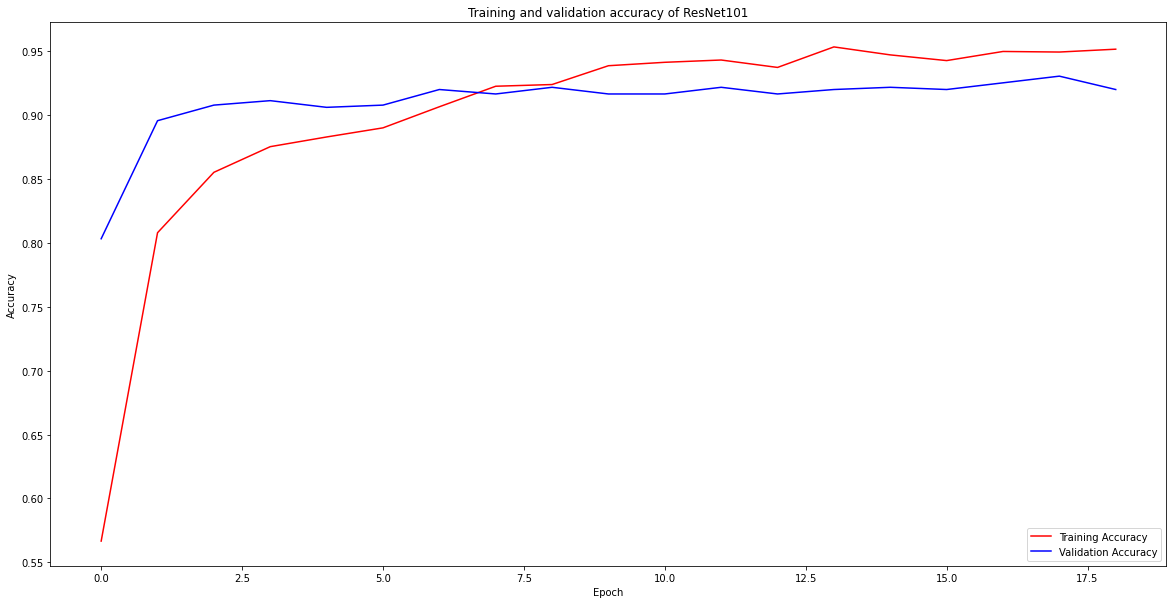

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy of ResNet101')
#plt.ylim([0.7, 1])
plt.legend(loc='lower right')
#plt.show()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/capstone/Accuracy_curve_resnet101_drop_batch_256.jpg')

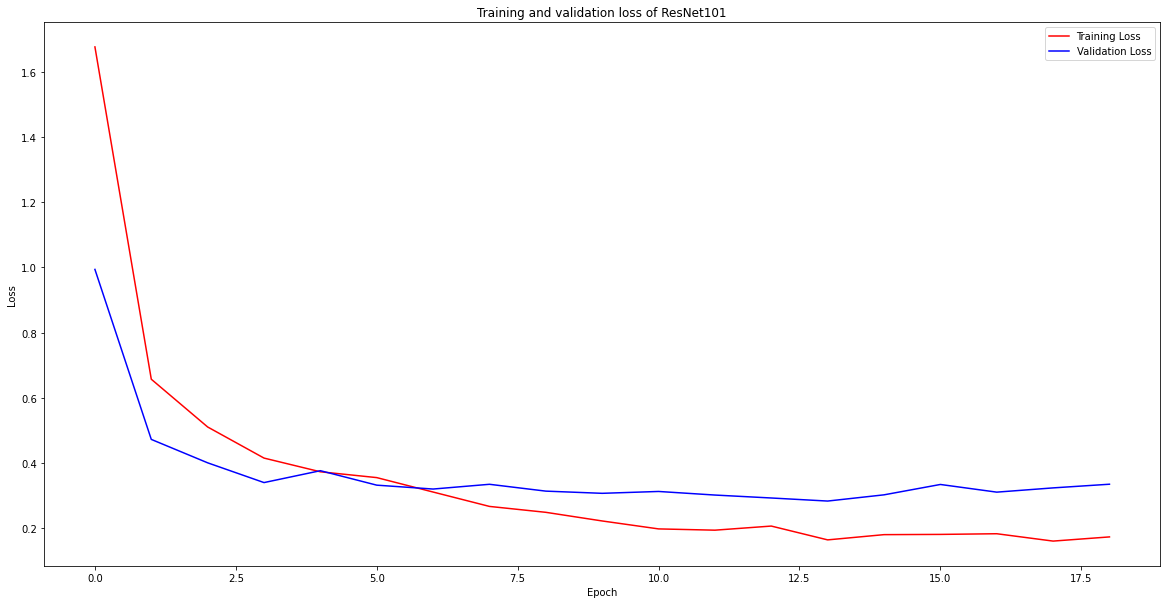

In [ ]:
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss of ResNet101')
fig2.savefig('/content/drive/MyDrive/Colab Notebooks/capstone/Loss_curve_resnet101_drop_batch_256.jpg')

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from keras.models import load_model
model_path = '/content/drive/MyDrive/Colab Notebooks/capstone/Final Model, evaluasi, deployment file/Model and Evaluasi FIile/resnet101_drop_batch_best_weights_256.h5resnet101_model.h5'
model = load_model(model_path)

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  # print(fn)
  # print(classes)
  # print("lala", classes[0][1])
  # print("hahah")
  if classes[0][0]>0.9:
    print(fn + "is a Back Pack")
  elif classes[0][1]>0.9:
    print(fn + "is a Bike")
  elif classes[0][2]>0.9:
    print(fn + " is a Bike Helmet")
  elif classes[0][3]>0.9:
    print(fn + " is a Bookcase")
  elif classes[0][4]>0.9:
    print(fn + " is a Bottle")
  elif classes[0][5]>0.9:
    print(fn + " is a Canculator")
  elif classes[0][6]>0.9:
    print(fn + " is a Desk Chair")
  elif classes[0][7]>0.9:
    print(fn + " is a Desk Lamp")
  elif classes[0][8]>0.9:
    print(fn + " is a Desktop Computer")
  elif classes[0][9]>0.9:
    print(fn + " is a File Cabinet")
  elif classes[0][10]>0.9:
    print(fn + " is a Headphones")
  elif classes[0][11]>0.9:
    print(fn + "is a Keyboard")
  elif classes[0][12]>0.9:
    print(fn + " is a Laptop Computer")
  elif classes[0][13]>0.9:
    print(fn + " is a Letter Tray")
  elif classes[0][14]>0.9:
    print(fn + " is a Mobile Phone")
  elif classes[0][15]>0.9:
    print(fn + " is a Monitor")
  elif classes[0][16]>0.9:
    print(fn + " is a Mouse")
  elif classes[0][17]>0.9:
    print(fn + " is a Mug")
  elif classes[0][18]>0.9:
    print(fn + " is a Paper Notebook")
  elif classes[0][19]>0.9:
    print(fn + " is a Pen")
  elif classes[0][20]>0.9:
    print(fn + " is a Phone")
  elif classes[0][21]>0.9:
    print(fn + "is a Printer")
  elif classes[0][22]>0.9:
    print(fn + " is a Projector")
  elif classes[0][23]>0.9:
    print(fn + " is a Punchers")
  elif classes[0][24]>0.9:
    print(fn + " is a Ring Binder")
  elif classes[0][25]>0.9:
    print(fn + " is a Ruler")
  elif classes[0][26]>0.9:
    print(fn + " is a Scissor")
  elif classes[0][27]>0.9:
    print(fn + " is a Speaker")
  elif classes[0][28]>0.9:
    print(fn + " is a Stapler")
  elif classes[0][29]>0.9:
    print(fn + " is a Tape Dispenser")
  elif classes[0][30]>0.9:
    print(fn + " is a Trash Can")
  else :
    print("not recognation")

  # kursi kelas 7 
  # sepeda kelas ke 7

In [ ]:
import os
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import tensorflow as tf
from google.colab import files
from keras.preprocessing import image
# from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import applications
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet152V2
# from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tqdm import tqdm
from zipfile import ZipFile

%matplotlib inline

In [ ]:
path_base = '/content/drive/MyDrive/dataset/splitted_modern-office-31'

path_train = os.path.join(path_base, 'train')

path_val = os.path.join(path_base, 'val')

path_val_BackPack = os.path.join(path_val, 'back_pack')
path_val_Bike = os.path.join(path_val, 'bike')
path_val_BikeHelmet = os.path.join(path_val, 'bike_helmet')
path_val_BookCase = os.path.join(path_val, 'bookcase')
path_val_Bottle = os.path.join(path_val, 'bottle')
path_val_Calculator = os.path.join(path_val, 'calculator')
path_val_DeskChair = os.path.join(path_val, 'desk_chair')
path_val_DeskLamp = os.path.join(path_val, 'desk_lamp')
path_val_DesktopComputer = os.path.join(path_val, 'desktop_computer')
path_val_FileCabinet = os.path.join(path_val, 'file_cabinet')
path_val_Headphones = os.path.join(path_val, 'headphones')
path_val_Keyboard = os.path.join(path_val, 'keyboard')
path_val_LaptopComputer = os.path.join(path_val, 'laptop_computer')
path_val_LetterTray = os.path.join(path_val, 'letter_tray')
path_val_MobilePhone = os.path.join(path_val, 'mobile_phone')
path_val_Monitor = os.path.join(path_val, 'monitor')
path_val_Mouse = os.path.join(path_val, 'mouse')
path_val_Mug = os.path.join(path_val, 'mug')
path_val_PaperNotebook = os.path.join(path_val, 'paper_notebook')
path_val_Pen = os.path.join(path_val, 'pen')
path_val_Phone = os.path.join(path_val, 'phone')
path_val_Printer = os.path.join(path_val, 'printer')
path_val_Projector = os.path.join(path_val, 'projector')
path_val_Punchers = os.path.join(path_val, 'punchers')
path_val_RingBinder = os.path.join(path_val, 'ring_binder')
path_val_Ruler = os.path.join(path_val, 'ruler')
path_val_Scissor = os.path.join(path_val, 'scissors')
path_val_Speaker = os.path.join(path_val, 'speaker')
path_val_Stapler = os.path.join(path_val, 'stapler')
path_val_TapeDIspenser = os.path.join(path_val, 'tape_dispenser')
path_val_TrashCan = os.path.join(path_val, 'trash_can')

In [ ]:
# menampilkan prediksi pada semua file yang ada di direktori 'test_paper_dir'
dir_1 = path_val_BackPack
dir_2 = path_val_Bike
dir_3 = path_val_BikeHelmet
dir_4 = path_val_BookCase
dir_5 = path_val_Bottle
dir_6 = path_val_Calculator
dir_7 = path_val_DeskChair
dir_8 = path_val_DeskLamp
dir_9 = path_val_DesktopComputer
dir_10 = path_val_FileCabinet
dir_11 = path_val_Headphones
dir_12 = path_val_Keyboard
dir_13 = path_val_LaptopComputer
dir_14 = path_val_LetterTray
dir_15 = path_val_MobilePhone
dir_16 = path_val_Monitor
dir_17 = path_val_Mouse
dir_18 = path_val_Mug
dir_19 = path_val_PaperNotebook
dir_20 = path_val_Pen
dir_21 = path_val_Phone
dir_22 = path_val_Printer
dir_23 = path_val_Projector
dir_24 = path_val_Punchers
dir_25 = path_val_RingBinder
dir_26 = path_val_Ruler
dir_27 = path_val_Scissor
dir_28 = path_val_Speaker
dir_29 = path_val_Stapler
dir_30 = path_val_TapeDIspenser
dir_31 = path_val_TrashCan


predicted_value_1 = []
for img in os.listdir(dir_1):
  img = os.path.join(dir_1, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_1.append(img)

predicted_value_2 = []
for img in os.listdir(dir_2):
  img = os.path.join(dir_2, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_2.append(img)

predicted_value_3 = []
for img in os.listdir(dir_3):
  img = os.path.join(dir_3, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_3.append(img)

predicted_value_4 = []
for img in os.listdir(dir_4):
  img = os.path.join(dir_4, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_4.append(img)

predicted_value_5 = []
for img in os.listdir(dir_5):
  img = os.path.join(dir_5, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_5.append(img)

predicted_value_6 = []
for img in os.listdir(dir_6):
  img = os.path.join(dir_6, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_6.append(img)

predicted_value_7 = []
for img in os.listdir(dir_7):
  img = os.path.join(dir_7, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_7.append(img)

predicted_value_8 = []
for img in os.listdir(dir_8):
  img = os.path.join(dir_8, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_8.append(img)

predicted_value_9 = []
for img in os.listdir(dir_9):
  img = os.path.join(dir_9, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_9.append(img)

predicted_value_10 = []
for img in os.listdir(dir_10):
  img = os.path.join(dir_10, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_10.append(img)

predicted_value_11 = []
for img in os.listdir(dir_11):
  img = os.path.join(dir_11, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_11.append(img)

predicted_value_12 = []
for img in os.listdir(dir_12):
  img = os.path.join(dir_12, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_12.append(img)

predicted_value_13 = []
for img in os.listdir(dir_13):
  img = os.path.join(dir_13, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_13.append(img)

predicted_value_14 = []
for img in os.listdir(dir_14):
  img = os.path.join(dir_14, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_14.append(img)

predicted_value_15 = []
for img in os.listdir(dir_15):
  img = os.path.join(dir_15, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_15.append(img)

predicted_value_16 = []
for img in os.listdir(dir_16):
  img = os.path.join(dir_16, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_16.append(img)

predicted_value_17 = []
for img in os.listdir(dir_17):
  img = os.path.join(dir_17, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_17.append(img)

predicted_value_18 = []
for img in os.listdir(dir_18):
  img = os.path.join(dir_18, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_18.append(img)

predicted_value_19 = []
for img in os.listdir(dir_19):
  img = os.path.join(dir_19, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_19.append(img)

predicted_value_20 = []
for img in os.listdir(dir_20):
  img = os.path.join(dir_20, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_20.append(img)


predicted_value_21 = []
for img in os.listdir(dir_21):
  img = os.path.join(dir_21, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_21.append(img)

predicted_value_22 = []
for img in os.listdir(dir_22):
  img = os.path.join(dir_22, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_22.append(img)

predicted_value_23 = []
for img in os.listdir(dir_23):
  img = os.path.join(dir_23, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_23.append(img)

predicted_value_24 = []
for img in os.listdir(dir_24):
  img = os.path.join(dir_24, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_24.append(img)

predicted_value_25 = []
for img in os.listdir(dir_25):
  img = os.path.join(dir_25, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_25.append(img)


predicted_value_26 = []
for img in os.listdir(dir_26):
  img = os.path.join(dir_26, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_26.append(img)

predicted_value_27 = []
for img in os.listdir(dir_27):
  img = os.path.join(dir_27, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_27.append(img)

predicted_value_28 = []
for img in os.listdir(dir_28):
  img = os.path.join(dir_28, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_28.append(img)

predicted_value_29 = []
for img in os.listdir(dir_29):
  img = os.path.join(dir_29, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_29.append(img)

predicted_value_30 = []
for img in os.listdir(dir_30):
  img = os.path.join(dir_30, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_30.append(img)

predicted_value_31 = []
for img in os.listdir(dir_31):
  img = os.path.join(dir_31, img)
  img = image.load_img(img, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predicted_value_31.append(img)


predicted_value_1 = np.vstack(predicted_value_1)
classes = np.argmax(model.predict(predicted_value_1), axis=-1)

count_BackPack = 0
count_Bike = 0
count_BikeHelmet = 0
count_BookCase = 0
count_Bottle = 0
count_Calculator = 0
count_DeskChair = 0
count_DeskLamp = 0
count_DeskComputer = 0
count_FileCabinet = 0
count_Headphones = 0
count_Keyboard = 0
count_LaptopComputer = 0
count_LetterTray = 0
count_MobilePhone = 0
count_Monitor = 0
count_Mouse = 0
count_Mug = 0
count_PaperNotebook = 0
count_Pen = 0
count_Phone = 0
count_Printer = 0
count_Projector = 0
count_Punchers = 0
count_RingBinder = 0
count_Ruler = 0
count_Scissor = 0
count_Speaker = 0
count_Stapler = 0
count_TapeDispenser = 0
count_TrashCan = 0
count_Other =0

predicted_value_1 = []
for value in classes:
  if value == 0:
    predicted_value_1.append('back_pack')
    count_BackPack += 1
  elif value == 1:
    predicted_value_1.append('bike')
    count_Bike += 1
  elif value == 2:
    predicted_value_1.append('bike_helmet')
    count_BikeHelmet += 1
  elif value == 3:
    predicted_value_1.append('bookcase')
    count_BookCase += 1
  elif value == 4:
    predicted_value_1.append('bottle')
    count_Bottle += 1
  elif value == 5:
    predicted_value_1.append('calculator')
    count_Calculator += 1
  elif value == 6:
    predicted_value_1.append('desk_chair')
    count_DeskChair += 1
  elif value == 7:
    predicted_value_1.append('desk_lamp')
    count_DeskLamp += 1
  elif value == 8:
    predicted_value_1.append('desktop_computer')
    count_DeskComputer += 1
  elif value == 9:
    predicted_value_1.append('file_cabinet')
    count_FileCabinet += 1
  elif value == 10:
    predicted_value_1.append('headphones')
    count_Headphones += 1
  elif value == 11:
    predicted_value_1.append('keyboard')
    count_Keyboard += 1
  elif value == 12:
    predicted_value_1.append('laptop_computer')
    count_LaptopComputer += 1
  elif value == 13:
    predicted_value_1.append('letter_tray')
    count_LetterTray += 1
  elif value == 14:
    predicted_value_1.append('mobile_phone')
    count_MobilePhone += 1
  elif value == 15:
    predicted_value_1.append('monitor')
    count_Monitor += 1
  elif value == 16:
    predicted_value_1.append('mouse')
    count_Mouse += 1
  elif value == 17:
    predicted_value_1.append('mug')
    count_Mug += 1
  elif value == 18:
    predicted_value_1.append('paper_notebook')
    count_PaperNotebook += 1
  elif value == 19:
    predicted_value_1.append('pen')
    count_Phone += 1
  elif value == 20:
    predicted_value_1.append('phone')
    count_Phone += 1
  elif value == 21:
    predicted_value_1.append('printer')
    count_Printer += 1
  elif value == 22:
    predicted_value_1.append('projector')
    count_Projector += 1
  elif value == 23:
    predicted_value_1.append('punchers')
    count_Punchers += 1
  elif value == 24:
    predicted_value_1.append('ring_binder')
    count_RingBinder += 1
  elif value == 25:
    predicted_value_1.append('ruler')
    count_Ruler += 1
  elif value == 26:
    predicted_value_1.append('scissors')
    count_Scissor += 1
  elif value == 27:
    predicted_value_1.append('speaker')
    count_Speaker += 1
  elif value == 28:
    predicted_value_1.append('stapler')
    count_Stapler += 1
  elif value == 29:
    predicted_value_1.append('tape_dispenser')
    count_TapeDispenser += 1
  elif value == 30:
    predicted_value_1.append('trash_can')
    count_TrashCan += 1
  else :
    predicted_value_1.append('Other')
    count_Other += 1

print("=========================================================")
print("Kelas BACK PACK")
print("Back Pack: ", count_BackPack)
print("Bike: ", count_Bike)
print("Bike Helmet: ", count_BikeHelmet)
print("Bookcase: ", count_BookCase)
print("Bottle: ", count_Bottle)
print("Calculator: ", count_Calculator)
print("Desk Chair: ", count_DeskChair)
print("Desk Lamp: ", count_DeskLamp)
print("Desktop Computer: ", count_DeskComputer)
print("File Cabinet: ", count_FileCabinet)
print("Headphones: ", count_Headphones)
print("Keyboard: ", count_Keyboard)
print("Laptop Computer: ", count_LaptopComputer)
print("Letter Tray: ", count_LetterTray)
print("Mobile Phone: ", count_MobilePhone)
print("Monitor: ", count_Monitor)
print("Mouse: ", count_Mouse)
print("Mug: ", count_Mug)
print("Paper Notebook: ", count_PaperNotebook)
print("Pen: ", count_Pen)
print("Phone: ", count_Phone)
print("Printer: ", count_Printer)
print("Projector: ", count_Projector)
print("Puncher: ", count_Punchers)
print("Ring Binder: ", count_RingBinder)
print("Ruler: ", count_Ruler)
print("Scissor: ", count_Scissor)
print("Speaker: ", count_Speaker)
print("Stapler: ", count_Stapler)
print("Tape Dispenser: ", count_TapeDispenser)
print("Trash Can: ", count_TrashCan)
print("Other: ", count_Other)

# =====================Bike=============================
predicted_value_2 = np.vstack(predicted_value_2)
classes = np.argmax(model.predict(predicted_value_2), axis=-1)

count_2_BackPack = 0
count_2_Bike = 0
count_2_BikeHelmet = 0
count_2_BookCase = 0
count_2_Bottle = 0
count_2_Calculator = 0
count_2_DeskChair = 0
count_2_DeskLamp = 0
count_2_DeskComputer = 0
count_2_FileCabinet = 0
count_2_Headphones = 0
count_2_Keyboard = 0
count_2_LaptopComputer = 0
count_2_LetterTray = 0
count_2_MobilePhone = 0
count_2_Monitor = 0
count_2_Mouse = 0
count_2_Mug = 0
count_2_PaperNotebook = 0
count_2_Pen = 0
count_2_Phone = 0
count_2_Printer = 0
count_2_Projector = 0
count_2_Punchers = 0
count_2_RingBinder = 0
count_2_Ruler = 0
count_2_Scissor = 0
count_2_Speaker = 0
count_2_Stapler = 0
count_2_TapeDispenser = 0
count_2_TrashCan = 0
count_2_Other =0

predicted_value_2 = []
for value in classes:
  if value == 0:
    predicted_value_2.append('back_pack')
    count_2_BackPack += 1
  elif value == 1:
    predicted_value_2.append('bike')
    count_2_Bike += 1
  elif value == 2:
    predicted_value_2.append('bike_helmet')
    count_2_BikeHelmet += 1
  elif value == 3:
    predicted_value_2.append('bookcase')
    count_2_BookCase += 1
  elif value == 4:
    predicted_value_2.append('bottle')
    count_2_Bottle += 1
  elif value == 5:
    predicted_value_2.append('calculator')
    count_2_Calculator += 1
  elif value == 6:
    predicted_value_2.append('desk_chair')
    count_2_DeskChair += 1
  elif value == 7:
    predicted_value_2.append('desk_lamp')
    count_2_DeskLamp += 1
  elif value == 8:
    predicted_value_2.append('desktop_computer')
    count_2_DeskComputer += 1
  elif value == 9:
    predicted_value_2.append('file_cabinet')
    count_2_FileCabinet += 1
  elif value == 10:
    predicted_value_2.append('headphones')
    count_2_Headphones += 1
  elif value == 11:
    predicted_value_2.append('keyboard')
    count_2_Keyboard += 1
  elif value == 12:
    predicted_value_2.append('laptop_computer')
    count_2_LaptopComputer += 1
  elif value == 13:
    predicted_value_2.append('letter_tray')
    count_2_LetterTray += 1
  elif value == 14:
    predicted_value_2.append('mobile_phone')
    count_2_MobilePhone += 1
  elif value == 15:
    predicted_value_2.append('monitor')
    count_2_Monitor += 1
  elif value == 16:
    predicted_value_2.append('mouse')
    count_2_Mouse += 1
  elif value == 17:
    predicted_value_2.append('mug')
    count_2_Mug += 1
  elif value == 18:
    predicted_value_2.append('paper_notebook')
    count_2_PaperNotebook += 1
  elif value == 19:
    predicted_value_2.append('pen')
    count_2_Phone += 1
  elif value == 20:
    predicted_value_2.append('phone')
    count_2_Phone += 1
  elif value == 21:
    predicted_value_2.append('printer')
    count_2_Printer += 1
  elif value == 22:
    predicted_value_2.append('projector')
    count_2_Projector += 1
  elif value == 23:
    predicted_value_2.append('punchers')
    count_2_Punchers += 1
  elif value == 24:
    predicted_value_2.append('ring_binder')
    count_2_RingBinder += 1
  elif value == 25:
    predicted_value_2.append('ruler')
    count_2_Ruler += 1
  elif value == 26:
    predicted_value_2.append('scissors')
    count_2_Scissor += 1
  elif value == 27:
    predicted_value_2.append('speaker')
    count_2_Speaker += 1
  elif value == 28:
    predicted_value_2.append('stapler')
    count_2_Stapler += 1
  elif value == 29:
    predicted_value_2.append('tape_dispenser')
    count_2_TapeDispenser += 1
  elif value == 30:
    predicted_value_2.append('trash_can')
    count_2_TrashCan += 1
  else :
    predicted_value_2.append('Other')
    count_2_Other += 1

print('\n================================================================')
print("Kelas BIKE")
print("Back Pack: ", count_2_BackPack)
print("Bike: ", count_2_Bike)
print("Bike Helmet: ", count_2_BikeHelmet)
print("Bookcase: ", count_2_BookCase)
print("Bottle: ", count_2_Bottle)
print("Calculator: ", count_2_Calculator)
print("Desk Chair: ", count_2_DeskChair)
print("Desk Lamp: ", count_2_DeskLamp)
print("Desktop Computer: ", count_2_DeskComputer)
print("File Cabinet: ", count_2_FileCabinet)
print("Headphones: ", count_2_Headphones)
print("Keyboard: ", count_2_Keyboard)
print("Laptop Computer: ", count_2_LaptopComputer)
print("Letter Tray: ", count_2_LetterTray)
print("Mobile Phone: ", count_2_MobilePhone)
print("Monitor: ", count_2_Monitor)
print("Mouse: ", count_2_Mouse)
print("Mug: ", count_2_Mug)
print("Paper Notebook: ", count_2_PaperNotebook)
print("Pen: ", count_2_Pen)
print("Phone: ", count_2_Phone)
print("Printer: ", count_2_Printer)
print("Projector: ", count_2_Projector)
print("Puncher: ", count_2_Punchers)
print("Ring Binder: ", count_2_RingBinder)
print("Ruler: ", count_2_Ruler)
print("Scissor: ", count_2_Scissor)
print("Speaker: ", count_2_Speaker)
print("Stapler: ", count_2_Stapler)
print("Tape Dispenser: ", count_2_TapeDispenser)
print("Trash Can: ", count_2_TrashCan)
print("Other: ", count_2_Other)


# =====================BIKE HELMET=============================
predicted_value_3 = np.vstack(predicted_value_3)
classes = np.argmax(model.predict(predicted_value_3), axis=-1)

count_3_BackPack = 0
count_3_Bike = 0
count_3_BikeHelmet = 0
count_3_BookCase = 0
count_3_Bottle = 0
count_3_Calculator = 0
count_3_DeskChair = 0
count_3_DeskLamp = 0
count_3_DeskComputer = 0
count_3_FileCabinet = 0
count_3_Headphones = 0
count_3_Keyboard = 0
count_3_LaptopComputer = 0
count_3_LetterTray = 0
count_3_MobilePhone = 0
count_3_Monitor = 0
count_3_Mouse = 0
count_3_Mug = 0
count_3_PaperNotebook = 0
count_3_Pen = 0
count_3_Phone = 0
count_3_Printer = 0
count_3_Projector = 0
count_3_Punchers = 0
count_3_RingBinder = 0
count_3_Ruler = 0
count_3_Scissor = 0
count_3_Speaker = 0
count_3_Stapler = 0
count_3_TapeDispenser = 0
count_3_TrashCan = 0
count_3_Other =0

predicted_value_3 = []
for value in classes:
  if value == 0:
    predicted_value_3.append('back_pack')
    count_3_BackPack += 1
  elif value == 1:
    predicted_value_3.append('bike')
    count_3_Bike += 1
  elif value == 2:
    predicted_value_3.append('bike_helmet')
    count_3_BikeHelmet += 1
  elif value == 3:
    predicted_value_3.append('bookcase')
    count_3_BookCase += 1
  elif value == 4:
    predicted_value_3.append('bottle')
    count_3_Bottle += 1
  elif value == 5:
    predicted_value_3.append('calculator')
    count_3_Calculator += 1
  elif value == 6:
    predicted_value_3.append('desk_chair')
    count_3_DeskChair += 1
  elif value == 7:
    predicted_value_3.append('desk_lamp')
    count_3_DeskLamp += 1
  elif value == 8:
    predicted_value_3.append('desktop_computer')
    count_3_DeskComputer += 1
  elif value == 9:
    predicted_value_3.append('file_cabinet')
    count_3_FileCabinet += 1
  elif value == 10:
    predicted_value_3.append('headphones')
    count_3_Headphones += 1
  elif value == 11:
    predicted_value_3.append('keyboard')
    count_3_Keyboard += 1
  elif value == 12:
    predicted_value_3.append('laptop_computer')
    count_3_LaptopComputer += 1
  elif value == 13:
    predicted_value_3.append('letter_tray')
    count_3_LetterTray += 1
  elif value == 14:
    predicted_value_3.append('mobile_phone')
    count_3_MobilePhone += 1
  elif value == 15:
    predicted_value_3.append('monitor')
    count_3_Monitor += 1
  elif value == 16:
    predicted_value_3.append('mouse')
    count_3_Mouse += 1
  elif value == 17:
    predicted_value_3.append('mug')
    count_3_Mug += 1
  elif value == 18:
    predicted_value_3.append('paper_notebook')
    count_3_PaperNotebook += 1
  elif value == 19:
    predicted_value_3.append('pen')
    count_3_Phone += 1
  elif value == 20:
    predicted_value_3.append('phone')
    count_3_Phone += 1
  elif value == 21:
    predicted_value_3.append('printer')
    count_3_Printer += 1
  elif value == 22:
    predicted_value_3.append('projector')
    count_3_Projector += 1
  elif value == 23:
    predicted_value_3.append('punchers')
    count_3_Punchers += 1
  elif value == 24:
    predicted_value_3.append('ring_binder')
    count_3_RingBinder += 1
  elif value == 25:
    predicted_value_3.append('ruler')
    count_3_Ruler += 1
  elif value == 26:
    predicted_value_3.append('scissors')
    count_3_Scissor += 1
  elif value == 27:
    predicted_value_3.append('speaker')
    count_3_Speaker += 1
  elif value == 28:
    predicted_value_3.append('stapler')
    count_3_Stapler += 1
  elif value == 29:
    predicted_value_3.append('tape_dispenser')
    count_3_TapeDispenser += 1
  elif value == 30:
    predicted_value_3.append('trash_can')
    count_3_TrashCan += 1
  else :
    predicted_value_3.append('Other')
    count_3_Other += 1

print('\n================================================================')
print("Kelas BIKE HELMET")
print("Back Pack: ", count_3_BackPack)
print("Bike: ", count_3_Bike)
print("Bike Helmet: ", count_3_BikeHelmet)
print("Bookcase: ", count_3_BookCase)
print("Bottle: ", count_3_Bottle)
print("Calculator: ", count_3_Calculator)
print("Desk Chair: ", count_3_DeskChair)
print("Desk Lamp: ", count_3_DeskLamp)
print("Desktop Computer: ", count_3_DeskComputer)
print("File Cabinet: ", count_3_FileCabinet)
print("Headphones: ", count_3_Headphones)
print("Keyboard: ", count_3_Keyboard)
print("Laptop Computer: ", count_3_LaptopComputer)
print("Letter Tray: ", count_3_LetterTray)
print("Mobile Phone: ", count_3_MobilePhone)
print("Monitor: ", count_3_Monitor)
print("Mouse: ", count_3_Mouse)
print("Mug: ", count_3_Mug)
print("Paper Notebook: ", count_3_PaperNotebook)
print("Pen: ", count_3_Pen)
print("Phone: ", count_3_Phone)
print("Printer: ", count_3_Printer)
print("Projector: ", count_3_Projector)
print("Puncher: ", count_3_Punchers)
print("Ring Binder: ", count_3_RingBinder)
print("Ruler: ", count_3_Ruler)
print("Scissor: ", count_3_Scissor)
print("Speaker: ", count_3_Speaker)
print("Stapler: ", count_3_Stapler)
print("Tape Dispenser: ", count_3_TapeDispenser)
print("Trash Can: ", count_3_TrashCan)
print("Other: ", count_3_Other)


# =====================BOOKCASE=============================
predicted_value_4 = np.vstack(predicted_value_4)
classes = np.argmax(model.predict(predicted_value_4), axis=-1)

count_4_BackPack = 0
count_4_Bike = 0
count_4_BikeHelmet = 0
count_4_BookCase = 0
count_4_Bottle = 0
count_4_Calculator = 0
count_4_DeskChair = 0
count_4_DeskLamp = 0
count_4_DeskComputer = 0
count_4_FileCabinet = 0
count_4_Headphones = 0
count_4_Keyboard = 0
count_4_LaptopComputer = 0
count_4_LetterTray = 0
count_4_MobilePhone = 0
count_4_Monitor = 0
count_4_Mouse = 0
count_4_Mug = 0
count_4_PaperNotebook = 0
count_4_Pen = 0
count_4_Phone = 0
count_4_Printer = 0
count_4_Projector = 0
count_4_Punchers = 0
count_4_RingBinder = 0
count_4_Ruler = 0
count_4_Scissor = 0
count_4_Speaker = 0
count_4_Stapler = 0
count_4_TapeDispenser = 0
count_4_TrashCan = 0
count_4_Other =0

predicted_value_4 = []
for value in classes:
  if value == 0:
    predicted_value_4.append('back_pack')
    count_4_BackPack += 1
  elif value == 1:
    predicted_value_4.append('bike')
    count_4_Bike += 1
  elif value == 2:
    predicted_value_4.append('bike_helmet')
    count_4_BikeHelmet += 1
  elif value == 3:
    predicted_value_4.append('bookcase')
    count_4_BookCase += 1
  elif value == 4:
    predicted_value_4.append('bottle')
    count_4_Bottle += 1
  elif value == 5:
    predicted_value_4.append('calculator')
    count_4_Calculator += 1
  elif value == 6:
    predicted_value_4.append('desk_chair')
    count_4_DeskChair += 1
  elif value == 7:
    predicted_value_4.append('desk_lamp')
    count_4_DeskLamp += 1
  elif value == 8:
    predicted_value_4.append('desktop_computer')
    count_4_DeskComputer += 1
  elif value == 9:
    predicted_value_4.append('file_cabinet')
    count_4_FileCabinet += 1
  elif value == 10:
    predicted_value_4.append('headphones')
    count_4_Headphones += 1
  elif value == 11:
    predicted_value_4.append('keyboard')
    count_4_Keyboard += 1
  elif value == 12:
    predicted_value_4.append('laptop_computer')
    count_4_LaptopComputer += 1
  elif value == 13:
    predicted_value_4.append('letter_tray')
    count_4_LetterTray += 1
  elif value == 14:
    predicted_value_4.append('mobile_phone')
    count_4_MobilePhone += 1
  elif value == 15:
    predicted_value_4.append('monitor')
    count_4_Monitor += 1
  elif value == 16:
    predicted_value_4.append('mouse')
    count_4_Mouse += 1
  elif value == 17:
    predicted_value_4.append('mug')
    count_4_Mug += 1
  elif value == 18:
    predicted_value_4.append('paper_notebook')
    count_4_PaperNotebook += 1
  elif value == 19:
    predicted_value_4.append('pen')
    count_4_Phone += 1
  elif value == 20:
    predicted_value_4.append('phone')
    count_4_Phone += 1
  elif value == 21:
    predicted_value_4.append('printer')
    count_4_Printer += 1
  elif value == 22:
    predicted_value_4.append('projector')
    count_4_Projector += 1
  elif value == 23:
    predicted_value_4.append('punchers')
    count_4_Punchers += 1
  elif value == 24:
    predicted_value_4.append('ring_binder')
    count_4_RingBinder += 1
  elif value == 25:
    predicted_value_4.append('ruler')
    count_4_Ruler += 1
  elif value == 26:
    predicted_value_4.append('scissors')
    count_4_Scissor += 1
  elif value == 27:
    predicted_value_4.append('speaker')
    count_4_Speaker += 1
  elif value == 28:
    predicted_value_4.append('stapler')
    count_4_Stapler += 1
  elif value == 29:
    predicted_value_4.append('tape_dispenser')
    count_4_TapeDispenser += 1
  elif value == 30:
    predicted_value_4.append('trash_can')
    count_4_TrashCan += 1
  else :
    predicted_value_4.append('Other')
    count_4_Other += 1

print('\n================================================================')
print("Kelas BOOK CASE")
print("Back Pack: ", count_4_BackPack)
print("Bike: ", count_4_Bike)
print("Bike Helmet: ", count_4_BikeHelmet)
print("Bookcase: ", count_4_BookCase)
print("Bottle: ", count_4_Bottle)
print("Calculator: ", count_4_Calculator)
print("Desk Chair: ", count_4_DeskChair)
print("Desk Lamp: ", count_4_DeskLamp)
print("Desktop Computer: ", count_4_DeskComputer)
print("File Cabinet: ", count_4_FileCabinet)
print("Headphones: ", count_4_Headphones)
print("Keyboard: ", count_4_Keyboard)
print("Laptop Computer: ", count_4_LaptopComputer)
print("Letter Tray: ", count_4_LetterTray)
print("Mobile Phone: ", count_4_MobilePhone)
print("Monitor: ", count_4_Monitor)
print("Mouse: ", count_4_Mouse)
print("Mug: ", count_4_Mug)
print("Paper Notebook: ", count_4_PaperNotebook)
print("Pen: ", count_4_Pen)
print("Phone: ", count_4_Phone)
print("Printer: ", count_4_Printer)
print("Projector: ", count_4_Projector)
print("Puncher: ", count_4_Punchers)
print("Ring Binder: ", count_4_RingBinder)
print("Ruler: ", count_4_Ruler)
print("Scissor: ", count_4_Scissor)
print("Speaker: ", count_4_Speaker)
print("Stapler: ", count_4_Stapler)
print("Tape Dispenser: ", count_4_TapeDispenser)
print("Trash Can: ", count_4_TrashCan)
print("Other: ", count_4_Other)


# =====================BOTTLE=============================
predicted_value_5 = np.vstack(predicted_value_5)
classes = np.argmax(model.predict(predicted_value_5), axis=-1)

count_5_BackPack = 0
count_5_Bike = 0
count_5_BikeHelmet = 0
count_5_BookCase = 0
count_5_Bottle = 0
count_5_Calculator = 0
count_5_DeskChair = 0
count_5_DeskLamp = 0
count_5_DeskComputer = 0
count_5_FileCabinet = 0
count_5_Headphones = 0
count_5_Keyboard = 0
count_5_LaptopComputer = 0
count_5_LetterTray = 0
count_5_MobilePhone = 0
count_5_Monitor = 0
count_5_Mouse = 0
count_5_Mug = 0
count_5_PaperNotebook = 0
count_5_Pen = 0
count_5_Phone = 0
count_5_Printer = 0
count_5_Projector = 0
count_5_Punchers = 0
count_5_RingBinder = 0
count_5_Ruler = 0
count_5_Scissor = 0
count_5_Speaker = 0
count_5_Stapler = 0
count_5_TapeDispenser = 0
count_5_TrashCan = 0
count_5_Other =0

predicted_value_5 = []
for value in classes:
  if value == 0:
    predicted_value_5.append('back_pack')
    count_5_BackPack += 1
  elif value == 1:
    predicted_value_5.append('bike')
    count_5_Bike += 1
  elif value == 2:
    predicted_value_5.append('bike_helmet')
    count_5_BikeHelmet += 1
  elif value == 3:
    predicted_value_5.append('bookcase')
    count_5_BookCase += 1
  elif value == 4:
    predicted_value_5.append('bottle')
    count_5_Bottle += 1
  elif value == 5:
    predicted_value_5.append('calculator')
    count_5_Calculator += 1
  elif value == 6:
    predicted_value_5.append('desk_chair')
    count_5_DeskChair += 1
  elif value == 7:
    predicted_value_5.append('desk_lamp')
    count_5_DeskLamp += 1
  elif value == 8:
    predicted_value_5.append('desktop_computer')
    count_5_DeskComputer += 1
  elif value == 9:
    predicted_value_5.append('file_cabinet')
    count_5_FileCabinet += 1
  elif value == 10:
    predicted_value_5.append('headphones')
    count_5_Headphones += 1
  elif value == 11:
    predicted_value_5.append('keyboard')
    count_5_Keyboard += 1
  elif value == 12:
    predicted_value_5.append('laptop_computer')
    count_5_LaptopComputer += 1
  elif value == 13:
    predicted_value_5.append('letter_tray')
    count_5_LetterTray += 1
  elif value == 14:
    predicted_value_5.append('mobile_phone')
    count_5_MobilePhone += 1
  elif value == 15:
    predicted_value_5.append('monitor')
    count_5_Monitor += 1
  elif value == 16:
    predicted_value_5.append('mouse')
    count_5_Mouse += 1
  elif value == 17:
    predicted_value_5.append('mug')
    count_5_Mug += 1
  elif value == 18:
    predicted_value_5.append('paper_notebook')
    count_5_PaperNotebook += 1
  elif value == 19:
    predicted_value_5.append('pen')
    count_5_Phone += 1
  elif value == 20:
    predicted_value_5.append('phone')
    count_5_Phone += 1
  elif value == 21:
    predicted_value_5.append('printer')
    count_5_Printer += 1
  elif value == 22:
    predicted_value_5.append('projector')
    count_5_Projector += 1
  elif value == 23:
    predicted_value_5.append('punchers')
    count_5_Punchers += 1
  elif value == 24:
    predicted_value_5.append('ring_binder')
    count_5_RingBinder += 1
  elif value == 25:
    predicted_value_5.append('ruler')
    count_5_Ruler += 1
  elif value == 26:
    predicted_value_5.append('scissors')
    count_5_Scissor += 1
  elif value == 27:
    predicted_value_5.append('speaker')
    count_5_Speaker += 1
  elif value == 28:
    predicted_value_5.append('stapler')
    count_5_Stapler += 1
  elif value == 29:
    predicted_value_5.append('tape_dispenser')
    count_5_TapeDispenser += 1
  elif value == 30:
    predicted_value_5.append('trash_can')
    count_5_TrashCan += 1
  else :
    predicted_value_5.append('Other')
    count_5_Other += 1

print('\n================================================================')
print("Kelas BOTTLE")
print("Back Pack: ", count_5_BackPack)
print("Bike: ", count_5_Bike)
print("Bike Helmet: ", count_5_BikeHelmet)
print("Bookcase: ", count_5_BookCase)
print("Bottle: ", count_5_Bottle)
print("Calculator: ", count_5_Calculator)
print("Desk Chair: ", count_5_DeskChair)
print("Desk Lamp: ", count_5_DeskLamp)
print("Desktop Computer: ", count_5_DeskComputer)
print("File Cabinet: ", count_5_FileCabinet)
print("Headphones: ", count_5_Headphones)
print("Keyboard: ", count_5_Keyboard)
print("Laptop Computer: ", count_5_LaptopComputer)
print("Letter Tray: ", count_5_LetterTray)
print("Mobile Phone: ", count_5_MobilePhone)
print("Monitor: ", count_5_Monitor)
print("Mouse: ", count_5_Mouse)
print("Mug: ", count_5_Mug)
print("Paper Notebook: ", count_5_PaperNotebook)
print("Pen: ", count_5_Pen)
print("Phone: ", count_5_Phone)
print("Printer: ", count_5_Printer)
print("Projector: ", count_5_Projector)
print("Puncher: ", count_5_Punchers)
print("Ring Binder: ", count_5_RingBinder)
print("Ruler: ", count_5_Ruler)
print("Scissor: ", count_5_Scissor)
print("Speaker: ", count_5_Speaker)
print("Stapler: ", count_5_Stapler)
print("Tape Dispenser: ", count_5_TapeDispenser)
print("Trash Can: ", count_5_TrashCan)
print("Other: ", count_5_Other)


# =====================CALCULATOR=============================
predicted_value_6 = np.vstack(predicted_value_6)
classes = np.argmax(model.predict(predicted_value_6), axis=-1)

count_6_BackPack = 0
count_6_Bike = 0
count_6_BikeHelmet = 0
count_6_BookCase = 0
count_6_Bottle = 0
count_6_Calculator = 0
count_6_DeskChair = 0
count_6_DeskLamp = 0
count_6_DeskComputer = 0
count_6_FileCabinet = 0
count_6_Headphones = 0
count_6_Keyboard = 0
count_6_LaptopComputer = 0
count_6_LetterTray = 0
count_6_MobilePhone = 0
count_6_Monitor = 0
count_6_Mouse = 0
count_6_Mug = 0
count_6_PaperNotebook = 0
count_6_Pen = 0
count_6_Phone = 0
count_6_Printer = 0
count_6_Projector = 0
count_6_Punchers = 0
count_6_RingBinder = 0
count_6_Ruler = 0
count_6_Scissor = 0
count_6_Speaker = 0
count_6_Stapler = 0
count_6_TapeDispenser = 0
count_6_TrashCan = 0
count_6_Other =0

predicted_value_6 = []
for value in classes:
  if value == 0:
    predicted_value_6.append('back_pack')
    count_6_BackPack += 1
  elif value == 1:
    predicted_value_6.append('bike')
    count_6_Bike += 1
  elif value == 2:
    predicted_value_6.append('bike_helmet')
    count_6_BikeHelmet += 1
  elif value == 3:
    predicted_value_6.append('bookcase')
    count_6_BookCase += 1
  elif value == 4:
    predicted_value_6.append('bottle')
    count_6_Bottle += 1
  elif value == 5:
    predicted_value_6.append('calculator')
    count_6_Calculator += 1
  elif value == 6:
    predicted_value_6.append('desk_chair')
    count_6_DeskChair += 1
  elif value == 7:
    predicted_value_6.append('desk_lamp')
    count_6_DeskLamp += 1
  elif value == 8:
    predicted_value_6.append('desktop_computer')
    count_6_DeskComputer += 1
  elif value == 9:
    predicted_value_6.append('file_cabinet')
    count_6_FileCabinet += 1
  elif value == 10:
    predicted_value_6.append('headphones')
    count_6_Headphones += 1
  elif value == 11:
    predicted_value_6.append('keyboard')
    count_6_Keyboard += 1
  elif value == 12:
    predicted_value_6.append('laptop_computer')
    count_6_LaptopComputer += 1
  elif value == 13:
    predicted_value_6.append('letter_tray')
    count_6_LetterTray += 1
  elif value == 14:
    predicted_value_6.append('mobile_phone')
    count_6_MobilePhone += 1
  elif value == 15:
    predicted_value_6.append('monitor')
    count_6_Monitor += 1
  elif value == 16:
    predicted_value_6.append('mouse')
    count_6_Mouse += 1
  elif value == 17:
    predicted_value_6.append('mug')
    count_6_Mug += 1
  elif value == 18:
    predicted_value_6.append('paper_notebook')
    count_6_PaperNotebook += 1
  elif value == 19:
    predicted_value_6.append('pen')
    count_6_Phone += 1
  elif value == 20:
    predicted_value_6.append('phone')
    count_6_Phone += 1
  elif value == 21:
    predicted_value_6.append('printer')
    count_6_Printer += 1
  elif value == 22:
    predicted_value_6.append('projector')
    count_6_Projector += 1
  elif value == 23:
    predicted_value_6.append('punchers')
    count_6_Punchers += 1
  elif value == 24:
    predicted_value_6.append('ring_binder')
    count_6_RingBinder += 1
  elif value == 25:
    predicted_value_6.append('ruler')
    count_6_Ruler += 1
  elif value == 26:
    predicted_value_6.append('scissors')
    count_6_Scissor += 1
  elif value == 27:
    predicted_value_6.append('speaker')
    count_6_Speaker += 1
  elif value == 28:
    predicted_value_6.append('stapler')
    count_6_Stapler += 1
  elif value == 29:
    predicted_value_6.append('tape_dispenser')
    count_6_TapeDispenser += 1
  elif value == 30:
    predicted_value_6.append('trash_can')
    count_6_TrashCan += 1
  else :
    predicted_value_6.append('Other')
    count_6_Other += 1

print('\n================================================================')
print("Kelas CALCULATOR")
print("Back Pack: ", count_6_BackPack)
print("Bike: ", count_6_Bike)
print("Bike Helmet: ", count_6_BikeHelmet)
print("Bookcase: ", count_6_BookCase)
print("Bottle: ", count_6_Bottle)
print("Calculator: ", count_6_Calculator)
print("Desk Chair: ", count_6_DeskChair)
print("Desk Lamp: ", count_6_DeskLamp)
print("Desktop Computer: ", count_6_DeskComputer)
print("File Cabinet: ", count_6_FileCabinet)
print("Headphones: ", count_6_Headphones)
print("Keyboard: ", count_6_Keyboard)
print("Laptop Computer: ", count_6_LaptopComputer)
print("Letter Tray: ", count_6_LetterTray)
print("Mobile Phone: ", count_6_MobilePhone)
print("Monitor: ", count_6_Monitor)
print("Mouse: ", count_6_Mouse)
print("Mug: ", count_6_Mug)
print("Paper Notebook: ", count_6_PaperNotebook)
print("Pen: ", count_6_Pen)
print("Phone: ", count_6_Phone)
print("Printer: ", count_6_Printer)
print("Projector: ", count_6_Projector)
print("Puncher: ", count_6_Punchers)
print("Ring Binder: ", count_6_RingBinder)
print("Ruler: ", count_6_Ruler)
print("Scissor: ", count_6_Scissor)
print("Speaker: ", count_6_Speaker)
print("Stapler: ", count_6_Stapler)
print("Tape Dispenser: ", count_6_TapeDispenser)
print("Trash Can: ", count_6_TrashCan)
print("Other: ", count_6_Other)

# =====================DESK CHAIR=============================
predicted_value_7 = np.vstack(predicted_value_7)
classes = np.argmax(model.predict(predicted_value_7), axis=-1)

count_7_BackPack = 0
count_7_Bike = 0
count_7_BikeHelmet = 0
count_7_BookCase = 0
count_7_Bottle = 0
count_7_Calculator = 0
count_7_DeskChair = 0
count_7_DeskLamp = 0
count_7_DeskComputer = 0
count_7_FileCabinet = 0
count_7_Headphones = 0
count_7_Keyboard = 0
count_7_LaptopComputer = 0
count_7_LetterTray = 0
count_7_MobilePhone = 0
count_7_Monitor = 0
count_7_Mouse = 0
count_7_Mug = 0
count_7_PaperNotebook = 0
count_7_Pen = 0
count_7_Phone = 0
count_7_Printer = 0
count_7_Projector = 0
count_7_Punchers = 0
count_7_RingBinder = 0
count_7_Ruler = 0
count_7_Scissor = 0
count_7_Speaker = 0
count_7_Stapler = 0
count_7_TapeDispenser = 0
count_7_TrashCan = 0
count_7_Other =0

predicted_value_7 = []
for value in classes:
  if value == 0:
    predicted_value_7.append('back_pack')
    count_7_BackPack += 1
  elif value == 1:
    predicted_value_7.append('bike')
    count_7_Bike += 1
  elif value == 2:
    predicted_value_7.append('bike_helmet')
    count_7_BikeHelmet += 1
  elif value == 3:
    predicted_value_7.append('bookcase')
    count_7_BookCase += 1
  elif value == 4:
    predicted_value_7.append('bottle')
    count_7_Bottle += 1
  elif value == 5:
    predicted_value_7.append('calculator')
    count_7_Calculator += 1
  elif value == 6:
    predicted_value_7.append('desk_chair')
    count_7_DeskChair += 1
  elif value == 7:
    predicted_value_7.append('desk_lamp')
    count_7_DeskLamp += 1
  elif value == 8:
    predicted_value_7.append('desktop_computer')
    count_7_DeskComputer += 1
  elif value == 9:
    predicted_value_7.append('file_cabinet')
    count_7_FileCabinet += 1
  elif value == 10:
    predicted_value_7.append('headphones')
    count_7_Headphones += 1
  elif value == 11:
    predicted_value_7.append('keyboard')
    count_7_Keyboard += 1
  elif value == 12:
    predicted_value_7.append('laptop_computer')
    count_7_LaptopComputer += 1
  elif value == 13:
    predicted_value_7.append('letter_tray')
    count_7_LetterTray += 1
  elif value == 14:
    predicted_value_7.append('mobile_phone')
    count_7_MobilePhone += 1
  elif value == 15:
    predicted_value_7.append('monitor')
    count_7_Monitor += 1
  elif value == 16:
    predicted_value_7.append('mouse')
    count_7_Mouse += 1
  elif value == 17:
    predicted_value_7.append('mug')
    count_7_Mug += 1
  elif value == 18:
    predicted_value_7.append('paper_notebook')
    count_7_PaperNotebook += 1
  elif value == 19:
    predicted_value_7.append('pen')
    count_7_Phone += 1
  elif value == 20:
    predicted_value_7.append('phone')
    count_7_Phone += 1
  elif value == 21:
    predicted_value_7.append('printer')
    count_7_Printer += 1
  elif value == 22:
    predicted_value_7.append('projector')
    count_7_Projector += 1
  elif value == 23:
    predicted_value_7.append('punchers')
    count_7_Punchers += 1
  elif value == 24:
    predicted_value_7.append('ring_binder')
    count_7_RingBinder += 1
  elif value == 25:
    predicted_value_7.append('ruler')
    count_7_Ruler += 1
  elif value == 26:
    predicted_value_7.append('scissors')
    count_7_Scissor += 1
  elif value == 27:
    predicted_value_7.append('speaker')
    count_7_Speaker += 1
  elif value == 28:
    predicted_value_7.append('stapler')
    count_7_Stapler += 1
  elif value == 29:
    predicted_value_7.append('tape_dispenser')
    count_7_TapeDispenser += 1
  elif value == 30:
    predicted_value_7.append('trash_can')
    count_7_TrashCan += 1
  else :
    predicted_value_7.append('Other')
    count_7_Other += 1

print('\n================================================================')
print("Kelas DESK CHAIR")
print("Back Pack: ", count_7_BackPack)
print("Bike: ", count_7_Bike)
print("Bike Helmet: ", count_7_BikeHelmet)
print("Bookcase: ", count_7_BookCase)
print("Bottle: ", count_7_Bottle)
print("Calculator: ", count_7_Calculator)
print("Desk Chair: ", count_7_DeskChair)
print("Desk Lamp: ", count_7_DeskLamp)
print("Desktop Computer: ", count_7_DeskComputer)
print("File Cabinet: ", count_7_FileCabinet)
print("Headphones: ", count_7_Headphones)
print("Keyboard: ", count_7_Keyboard)
print("Laptop Computer: ", count_7_LaptopComputer)
print("Letter Tray: ", count_7_LetterTray)
print("Mobile Phone: ", count_7_MobilePhone)
print("Monitor: ", count_7_Monitor)
print("Mouse: ", count_7_Mouse)
print("Mug: ", count_7_Mug)
print("Paper Notebook: ", count_7_PaperNotebook)
print("Pen: ", count_7_Pen)
print("Phone: ", count_7_Phone)
print("Printer: ", count_7_Printer)
print("Projector: ", count_7_Projector)
print("Puncher: ", count_7_Punchers)
print("Ring Binder: ", count_7_RingBinder)
print("Ruler: ", count_7_Ruler)
print("Scissor: ", count_7_Scissor)
print("Speaker: ", count_7_Speaker)
print("Stapler: ", count_7_Stapler)
print("Tape Dispenser: ", count_7_TapeDispenser)
print("Trash Can: ", count_7_TrashCan)
print("Other: ", count_7_Other)

# =====================DESK LAMP=============================
predicted_value_8 = np.vstack(predicted_value_8)
classes = np.argmax(model.predict(predicted_value_8), axis=-1)

count_8_BackPack = 0
count_8_Bike = 0
count_8_BikeHelmet = 0
count_8_BookCase = 0
count_8_Bottle = 0
count_8_Calculator = 0
count_8_DeskChair = 0
count_8_DeskLamp = 0
count_8_DeskComputer = 0
count_8_FileCabinet = 0
count_8_Headphones = 0
count_8_Keyboard = 0
count_8_LaptopComputer = 0
count_8_LetterTray = 0
count_8_MobilePhone = 0
count_8_Monitor = 0
count_8_Mouse = 0
count_8_Mug = 0
count_8_PaperNotebook = 0
count_8_Pen = 0
count_8_Phone = 0
count_8_Printer = 0
count_8_Projector = 0
count_8_Punchers = 0
count_8_RingBinder = 0
count_8_Ruler = 0
count_8_Scissor = 0
count_8_Speaker = 0
count_8_Stapler = 0
count_8_TapeDispenser = 0
count_8_TrashCan = 0
count_8_Other =0

predicted_value_8 = []
for value in classes:
  if value == 0:
    predicted_value_8.append('back_pack')
    count_8_BackPack += 1
  elif value == 1:
    predicted_value_8.append('bike')
    count_8_Bike += 1
  elif value == 2:
    predicted_value_8.append('bike_helmet')
    count_8_BikeHelmet += 1
  elif value == 3:
    predicted_value_8.append('bookcase')
    count_8_BookCase += 1
  elif value == 4:
    predicted_value_8.append('bottle')
    count_8_Bottle += 1
  elif value == 5:
    predicted_value_8.append('calculator')
    count_8_Calculator += 1
  elif value == 6:
    predicted_value_8.append('desk_chair')
    count_8_DeskChair += 1
  elif value == 7:
    predicted_value_8.append('desk_lamp')
    count_8_DeskLamp += 1
  elif value == 8:
    predicted_value_8.append('desktop_computer')
    count_8_DeskComputer += 1
  elif value == 9:
    predicted_value_8.append('file_cabinet')
    count_8_FileCabinet += 1
  elif value == 10:
    predicted_value_8.append('headphones')
    count_8_Headphones += 1
  elif value == 11:
    predicted_value_8.append('keyboard')
    count_8_Keyboard += 1
  elif value == 12:
    predicted_value_8.append('laptop_computer')
    count_8_LaptopComputer += 1
  elif value == 13:
    predicted_value_8.append('letter_tray')
    count_8_LetterTray += 1
  elif value == 14:
    predicted_value_8.append('mobile_phone')
    count_8_MobilePhone += 1
  elif value == 15:
    predicted_value_8.append('monitor')
    count_8_Monitor += 1
  elif value == 16:
    predicted_value_8.append('mouse')
    count_8_Mouse += 1
  elif value == 17:
    predicted_value_8.append('mug')
    count_8_Mug += 1
  elif value == 18:
    predicted_value_8.append('paper_notebook')
    count_8_PaperNotebook += 1
  elif value == 19:
    predicted_value_8.append('pen')
    count_8_Phone += 1
  elif value == 20:
    predicted_value_8.append('phone')
    count_8_Phone += 1
  elif value == 21:
    predicted_value_8.append('printer')
    count_8_Printer += 1
  elif value == 22:
    predicted_value_8.append('projector')
    count_8_Projector += 1
  elif value == 23:
    predicted_value_8.append('punchers')
    count_8_Punchers += 1
  elif value == 24:
    predicted_value_8.append('ring_binder')
    count_8_RingBinder += 1
  elif value == 25:
    predicted_value_8.append('ruler')
    count_8_Ruler += 1
  elif value == 26:
    predicted_value_8.append('scissors')
    count_8_Scissor += 1
  elif value == 27:
    predicted_value_8.append('speaker')
    count_8_Speaker += 1
  elif value == 28:
    predicted_value_8.append('stapler')
    count_8_Stapler += 1
  elif value == 29:
    predicted_value_8.append('tape_dispenser')
    count_8_TapeDispenser += 1
  elif value == 30:
    predicted_value_8.append('trash_can')
    count_8_TrashCan += 1
  else :
    predicted_value_8.append('Other')
    count_8_Other += 1

print('\n================================================================')
print("Kelas DESK LAMP")
print("Back Pack: ", count_8_BackPack)
print("Bike: ", count_8_Bike)
print("Bike Helmet: ", count_8_BikeHelmet)
print("Bookcase: ", count_8_BookCase)
print("Bottle: ", count_8_Bottle)
print("Calculator: ", count_8_Calculator)
print("Desk Chair: ", count_8_DeskChair)
print("Desk Lamp: ", count_8_DeskLamp)
print("Desktop Computer: ", count_8_DeskComputer)
print("File Cabinet: ", count_8_FileCabinet)
print("Headphones: ", count_8_Headphones)
print("Keyboard: ", count_8_Keyboard)
print("Laptop Computer: ", count_8_LaptopComputer)
print("Letter Tray: ", count_8_LetterTray)
print("Mobile Phone: ", count_8_MobilePhone)
print("Monitor: ", count_8_Monitor)
print("Mouse: ", count_8_Mouse)
print("Mug: ", count_8_Mug)
print("Paper Notebook: ", count_8_PaperNotebook)
print("Pen: ", count_8_Pen)
print("Phone: ", count_8_Phone)
print("Printer: ", count_8_Printer)
print("Projector: ", count_8_Projector)
print("Puncher: ", count_8_Punchers)
print("Ring Binder: ", count_8_RingBinder)
print("Ruler: ", count_8_Ruler)
print("Scissor: ", count_8_Scissor)
print("Speaker: ", count_8_Speaker)
print("Stapler: ", count_8_Stapler)
print("Tape Dispenser: ", count_8_TapeDispenser)
print("Trash Can: ", count_8_TrashCan)
print("Other: ", count_8_Other)

# =====================DESK COMPUTER=============================
predicted_value_9 = np.vstack(predicted_value_9)
classes = np.argmax(model.predict(predicted_value_9), axis=-1)

count_9_BackPack = 0
count_9_Bike = 0
count_9_BikeHelmet = 0
count_9_BookCase = 0
count_9_Bottle = 0
count_9_Calculator = 0
count_9_DeskChair = 0
count_9_DeskLamp = 0
count_9_DeskComputer = 0
count_9_FileCabinet = 0
count_9_Headphones = 0
count_9_Keyboard = 0
count_9_LaptopComputer = 0
count_9_LetterTray = 0
count_9_MobilePhone = 0
count_9_Monitor = 0
count_9_Mouse = 0
count_9_Mug = 0
count_9_PaperNotebook = 0
count_9_Pen = 0
count_9_Phone = 0
count_9_Printer = 0
count_9_Projector = 0
count_9_Punchers = 0
count_9_RingBinder = 0
count_9_Ruler = 0
count_9_Scissor = 0
count_9_Speaker = 0
count_9_Stapler = 0
count_9_TapeDispenser = 0
count_9_TrashCan = 0
count_9_Other =0

predicted_value_9 = []
for value in classes:
  if value == 0:
    predicted_value_9.append('back_pack')
    count_9_BackPack += 1
  elif value == 1:
    predicted_value_9.append('bike')
    count_9_Bike += 1
  elif value == 2:
    predicted_value_9.append('bike_helmet')
    count_9_BikeHelmet += 1
  elif value == 3:
    predicted_value_9.append('bookcase')
    count_9_BookCase += 1
  elif value == 4:
    predicted_value_9.append('bottle')
    count_9_Bottle += 1
  elif value == 5:
    predicted_value_9.append('calculator')
    count_9_Calculator += 1
  elif value == 6:
    predicted_value_9.append('desk_chair')
    count_9_DeskChair += 1
  elif value == 7:
    predicted_value_9.append('desk_lamp')
    count_9_DeskLamp += 1
  elif value == 8:
    predicted_value_9.append('desktop_computer')
    count_9_DeskComputer += 1
  elif value == 9:
    predicted_value_9.append('file_cabinet')
    count_9_FileCabinet += 1
  elif value == 10:
    predicted_value_9.append('headphones')
    count_9_Headphones += 1
  elif value == 11:
    predicted_value_9.append('keyboard')
    count_9_Keyboard += 1
  elif value == 12:
    predicted_value_9.append('laptop_computer')
    count_9_LaptopComputer += 1
  elif value == 13:
    predicted_value_9.append('letter_tray')
    count_9_LetterTray += 1
  elif value == 14:
    predicted_value_9.append('mobile_phone')
    count_9_MobilePhone += 1
  elif value == 15:
    predicted_value_9.append('monitor')
    count_9_Monitor += 1
  elif value == 16:
    predicted_value_9.append('mouse')
    count_9_Mouse += 1
  elif value == 17:
    predicted_value_9.append('mug')
    count_9_Mug += 1
  elif value == 18:
    predicted_value_9.append('paper_notebook')
    count_9_PaperNotebook += 1
  elif value == 19:
    predicted_value_9.append('pen')
    count_9_Phone += 1
  elif value == 20:
    predicted_value_9.append('phone')
    count_9_Phone += 1
  elif value == 21:
    predicted_value_9.append('printer')
    count_9_Printer += 1
  elif value == 22:
    predicted_value_9.append('projector')
    count_9_Projector += 1
  elif value == 23:
    predicted_value_9.append('punchers')
    count_9_Punchers += 1
  elif value == 24:
    predicted_value_9.append('ring_binder')
    count_9_RingBinder += 1
  elif value == 25:
    predicted_value_9.append('ruler')
    count_9_Ruler += 1
  elif value == 26:
    predicted_value_9.append('scissors')
    count_9_Scissor += 1
  elif value == 27:
    predicted_value_9.append('speaker')
    count_9_Speaker += 1
  elif value == 28:
    predicted_value_9.append('stapler')
    count_9_Stapler += 1
  elif value == 29:
    predicted_value_9.append('tape_dispenser')
    count_9_TapeDispenser += 1
  elif value == 30:
    predicted_value_9.append('trash_can')
    count_9_TrashCan += 1
  else :
    predicted_value_9.append('Other')
    count_9_Other += 1

print('\n================================================================')
print("Kelas DESKTOP COMPUTER")
print("Back Pack: ", count_9_BackPack)
print("Bike: ", count_9_Bike)
print("Bike Helmet: ", count_9_BikeHelmet)
print("Bookcase: ", count_9_BookCase)
print("Bottle: ", count_9_Bottle)
print("Calculator: ", count_9_Calculator)
print("Desk Chair: ", count_9_DeskChair)
print("Desk Lamp: ", count_9_DeskLamp)
print("Desktop Computer: ", count_9_DeskComputer)
print("File Cabinet: ", count_9_FileCabinet)
print("Headphones: ", count_9_Headphones)
print("Keyboard: ", count_9_Keyboard)
print("Laptop Computer: ", count_9_LaptopComputer)
print("Letter Tray: ", count_9_LetterTray)
print("Mobile Phone: ", count_9_MobilePhone)
print("Monitor: ", count_9_Monitor)
print("Mouse: ", count_9_Mouse)
print("Mug: ", count_9_Mug)
print("Paper Notebook: ", count_9_PaperNotebook)
print("Pen: ", count_9_Pen)
print("Phone: ", count_9_Phone)
print("Printer: ", count_9_Printer)
print("Projector: ", count_9_Projector)
print("Puncher: ", count_9_Punchers)
print("Ring Binder: ", count_9_RingBinder)
print("Ruler: ", count_9_Ruler)
print("Scissor: ", count_9_Scissor)
print("Speaker: ", count_9_Speaker)
print("Stapler: ", count_9_Stapler)
print("Tape Dispenser: ", count_9_TapeDispenser)
print("Trash Can: ", count_9_TrashCan)
print("Other: ", count_9_Other)


# =====================FILE CABINET=============================
predicted_value_10 = np.vstack(predicted_value_10)
classes = np.argmax(model.predict(predicted_value_10), axis=-1)

count_10_BackPack = 0
count_10_Bike = 0
count_10_BikeHelmet = 0
count_10_BookCase = 0
count_10_Bottle = 0
count_10_Calculator = 0
count_10_DeskChair = 0
count_10_DeskLamp = 0
count_10_DeskComputer = 0
count_10_FileCabinet = 0
count_10_Headphones = 0
count_10_Keyboard = 0
count_10_LaptopComputer = 0
count_10_LetterTray = 0
count_10_MobilePhone = 0
count_10_Monitor = 0
count_10_Mouse = 0
count_10_Mug = 0
count_10_PaperNotebook = 0
count_10_Pen = 0
count_10_Phone = 0
count_10_Printer = 0
count_10_Projector = 0
count_10_Punchers = 0
count_10_RingBinder = 0
count_10_Ruler = 0
count_10_Scissor = 0
count_10_Speaker = 0
count_10_Stapler = 0
count_10_TapeDispenser = 0
count_10_TrashCan = 0
count_10_Other =0

predicted_value_10 = []
for value in classes:
  if value == 0:
    predicted_value_10.append('back_pack')
    count_10_BackPack += 1
  elif value == 1:
    predicted_value_10.append('bike')
    count_10_Bike += 1
  elif value == 2:
    predicted_value_10.append('bike_helmet')
    count_10_BikeHelmet += 1
  elif value == 3:
    predicted_value_10.append('bookcase')
    count_10_BookCase += 1
  elif value == 4:
    predicted_value_10.append('bottle')
    count_10_Bottle += 1
  elif value == 5:
    predicted_value_10.append('calculator')
    count_10_Calculator += 1
  elif value == 6:
    predicted_value_10.append('desk_chair')
    count_10_DeskChair += 1
  elif value == 7:
    predicted_value_10.append('desk_lamp')
    count_10_DeskLamp += 1
  elif value == 8:
    predicted_value_10.append('desktop_computer')
    count_10_DeskComputer += 1
  elif value == 9:
    predicted_value_10.append('file_cabinet')
    count_10_FileCabinet += 1
  elif value == 10:
    predicted_value_10.append('headphones')
    count_10_Headphones += 1
  elif value == 11:
    predicted_value_10.append('keyboard')
    count_10_Keyboard += 1
  elif value == 12:
    predicted_value_10.append('laptop_computer')
    count_10_LaptopComputer += 1
  elif value == 13:
    predicted_value_10.append('letter_tray')
    count_10_LetterTray += 1
  elif value == 14:
    predicted_value_10.append('mobile_phone')
    count_10_MobilePhone += 1
  elif value == 15:
    predicted_value_10.append('monitor')
    count_10_Monitor += 1
  elif value == 16:
    predicted_value_10.append('mouse')
    count_10_Mouse += 1
  elif value == 17:
    predicted_value_10.append('mug')
    count_10_Mug += 1
  elif value == 18:
    predicted_value_10.append('paper_notebook')
    count_10_PaperNotebook += 1
  elif value == 19:
    predicted_value_10.append('pen')
    count_10_Phone += 1
  elif value == 20:
    predicted_value_10.append('phone')
    count_10_Phone += 1
  elif value == 21:
    predicted_value_10.append('printer')
    count_10_Printer += 1
  elif value == 22:
    predicted_value_10.append('projector')
    count_10_Projector += 1
  elif value == 23:
    predicted_value_10.append('punchers')
    count_10_Punchers += 1
  elif value == 24:
    predicted_value_10.append('ring_binder')
    count_10_RingBinder += 1
  elif value == 25:
    predicted_value_10.append('ruler')
    count_10_Ruler += 1
  elif value == 26:
    predicted_value_10.append('scissors')
    count_10_Scissor += 1
  elif value == 27:
    predicted_value_10.append('speaker')
    count_10_Speaker += 1
  elif value == 28:
    predicted_value_10.append('stapler')
    count_10_Stapler += 1
  elif value == 29:
    predicted_value_10.append('tape_dispenser')
    count_10_TapeDispenser += 1
  elif value == 30:
    predicted_value_10.append('trash_can')
    count_10_TrashCan += 1
  else :
    predicted_value_10.append('Other')
    count_10_Other += 1

print('\n================================================================')
print("Kelas FILE CABINET")
print("Back Pack: ", count_10_BackPack)
print("Bike: ", count_10_Bike)
print("Bike Helmet: ", count_10_BikeHelmet)
print("Bookcase: ", count_10_BookCase)
print("Bottle: ", count_10_Bottle)
print("Calculator: ", count_10_Calculator)
print("Desk Chair: ", count_10_DeskChair)
print("Desk Lamp: ", count_10_DeskLamp)
print("Desktop Computer: ", count_10_DeskComputer)
print("File Cabinet: ", count_10_FileCabinet)
print("Headphones: ", count_10_Headphones)
print("Keyboard: ", count_10_Keyboard)
print("Laptop Computer: ", count_10_LaptopComputer)
print("Letter Tray: ", count_10_LetterTray)
print("Mobile Phone: ", count_10_MobilePhone)
print("Monitor: ", count_10_Monitor)
print("Mouse: ", count_10_Mouse)
print("Mug: ", count_10_Mug)
print("Paper Notebook: ", count_10_PaperNotebook)
print("Pen: ", count_10_Pen)
print("Phone: ", count_10_Phone)
print("Printer: ", count_10_Printer)
print("Projector: ", count_10_Projector)
print("Puncher: ", count_10_Punchers)
print("Ring Binder: ", count_10_RingBinder)
print("Ruler: ", count_10_Ruler)
print("Scissor: ", count_10_Scissor)
print("Speaker: ", count_10_Speaker)
print("Stapler: ", count_10_Stapler)
print("Tape Dispenser: ", count_10_TapeDispenser)
print("Trash Can: ", count_10_TrashCan)
print("Other: ", count_10_Other)

# =====================HEADPHONES=============================
predicted_value_11 = np.vstack(predicted_value_11)
classes = np.argmax(model.predict(predicted_value_11), axis=-1)

count_11_BackPack = 0
count_11_Bike = 0
count_11_BikeHelmet = 0
count_11_BookCase = 0
count_11_Bottle = 0
count_11_Calculator = 0
count_11_DeskChair = 0
count_11_DeskLamp = 0
count_11_DeskComputer = 0
count_11_FileCabinet = 0
count_11_Headphones = 0
count_11_Keyboard = 0
count_11_LaptopComputer = 0
count_11_LetterTray = 0
count_11_MobilePhone = 0
count_11_Monitor = 0
count_11_Mouse = 0
count_11_Mug = 0
count_11_PaperNotebook = 0
count_11_Pen = 0
count_11_Phone = 0
count_11_Printer = 0
count_11_Projector = 0
count_11_Punchers = 0
count_11_RingBinder = 0
count_11_Ruler = 0
count_11_Scissor = 0
count_11_Speaker = 0
count_11_Stapler = 0
count_11_TapeDispenser = 0
count_11_TrashCan = 0
count_11_Other =0

predicted_value_11 = []
for value in classes:
  if value == 0:
    predicted_value_11.append('back_pack')
    count_11_BackPack += 1
  elif value == 1:
    predicted_value_11.append('bike')
    count_11_Bike += 1
  elif value == 2:
    predicted_value_11.append('bike_helmet')
    count_11_BikeHelmet += 1
  elif value == 3:
    predicted_value_11.append('bookcase')
    count_11_BookCase += 1
  elif value == 4:
    predicted_value_11.append('bottle')
    count_11_Bottle += 1
  elif value == 5:
    predicted_value_11.append('calculator')
    count_11_Calculator += 1
  elif value == 6:
    predicted_value_11.append('desk_chair')
    count_11_DeskChair += 1
  elif value == 7:
    predicted_value_11.append('desk_lamp')
    count_11_DeskLamp += 1
  elif value == 8:
    predicted_value_11.append('desktop_computer')
    count_11_DeskComputer += 1
  elif value == 9:
    predicted_value_11.append('file_cabinet')
    count_11_FileCabinet += 1
  elif value == 10:
    predicted_value_11.append('headphones')
    count_11_Headphones += 1
  elif value == 11:
    predicted_value_11.append('keyboard')
    count_11_Keyboard += 1
  elif value == 12:
    predicted_value_11.append('laptop_computer')
    count_11_LaptopComputer += 1
  elif value == 13:
    predicted_value_11.append('letter_tray')
    count_11_LetterTray += 1
  elif value == 14:
    predicted_value_11.append('mobile_phone')
    count_11_MobilePhone += 1
  elif value == 15:
    predicted_value_11.append('monitor')
    count_11_Monitor += 1
  elif value == 16:
    predicted_value_11.append('mouse')
    count_11_Mouse += 1
  elif value == 17:
    predicted_value_11.append('mug')
    count_11_Mug += 1
  elif value == 18:
    predicted_value_11.append('paper_notebook')
    count_11_PaperNotebook += 1
  elif value == 19:
    predicted_value_11.append('pen')
    count_11_Phone += 1
  elif value == 20:
    predicted_value_11.append('phone')
    count_11_Phone += 1
  elif value == 21:
    predicted_value_11.append('printer')
    count_11_Printer += 1
  elif value == 22:
    predicted_value_11.append('projector')
    count_11_Projector += 1
  elif value == 23:
    predicted_value_11.append('punchers')
    count_11_Punchers += 1
  elif value == 24:
    predicted_value_11.append('ring_binder')
    count_11_RingBinder += 1
  elif value == 25:
    predicted_value_11.append('ruler')
    count_11_Ruler += 1
  elif value == 26:
    predicted_value_11.append('scissors')
    count_11_Scissor += 1
  elif value == 27:
    predicted_value_11.append('speaker')
    count_11_Speaker += 1
  elif value == 28:
    predicted_value_11.append('stapler')
    count_11_Stapler += 1
  elif value == 29:
    predicted_value_11.append('tape_dispenser')
    count_11_TapeDispenser += 1
  elif value == 30:
    predicted_value_11.append('trash_can')
    count_11_TrashCan += 1
  else :
    predicted_value_11.append('Other')
    count_11_Other += 1

print('\n================================================================')
print("Kelas HEADPHONES")
print("Back Pack: ", count_11_BackPack)
print("Bike: ", count_11_Bike)
print("Bike Helmet: ", count_11_BikeHelmet)
print("Bookcase: ", count_11_BookCase)
print("Bottle: ", count_11_Bottle)
print("Calculator: ", count_11_Calculator)
print("Desk Chair: ", count_11_DeskChair)
print("Desk Lamp: ", count_11_DeskLamp)
print("Desktop Computer: ", count_11_DeskComputer)
print("File Cabinet: ", count_11_FileCabinet)
print("Headphones: ", count_11_Headphones)
print("Keyboard: ", count_11_Keyboard)
print("Laptop Computer: ", count_11_LaptopComputer)
print("Letter Tray: ", count_11_LetterTray)
print("Mobile Phone: ", count_11_MobilePhone)
print("Monitor: ", count_11_Monitor)
print("Mouse: ", count_11_Mouse)
print("Mug: ", count_11_Mug)
print("Paper Notebook: ", count_11_PaperNotebook)
print("Pen: ", count_11_Pen)
print("Phone: ", count_11_Phone)
print("Printer: ", count_11_Printer)
print("Projector: ", count_11_Projector)
print("Puncher: ", count_11_Punchers)
print("Ring Binder: ", count_11_RingBinder)
print("Ruler: ", count_11_Ruler)
print("Scissor: ", count_11_Scissor)
print("Speaker: ", count_11_Speaker)
print("Stapler: ", count_11_Stapler)
print("Tape Dispenser: ", count_11_TapeDispenser)
print("Trash Can: ", count_11_TrashCan)
print("Other: ", count_11_Other)

# =====================KEYBOARD=============================
predicted_value_12 = np.vstack(predicted_value_12)
classes = np.argmax(model.predict(predicted_value_12), axis=-1)

count_12_BackPack = 0
count_12_Bike = 0
count_12_BikeHelmet = 0
count_12_BookCase = 0
count_12_Bottle = 0
count_12_Calculator = 0
count_12_DeskChair = 0
count_12_DeskLamp = 0
count_12_DeskComputer = 0
count_12_FileCabinet = 0
count_12_Headphones = 0
count_12_Keyboard = 0
count_12_LaptopComputer = 0
count_12_LetterTray = 0
count_12_MobilePhone = 0
count_12_Monitor = 0
count_12_Mouse = 0
count_12_Mug = 0
count_12_PaperNotebook = 0
count_12_Pen = 0
count_12_Phone = 0
count_12_Printer = 0
count_12_Projector = 0
count_12_Punchers = 0
count_12_RingBinder = 0
count_12_Ruler = 0
count_12_Scissor = 0
count_12_Speaker = 0
count_12_Stapler = 0
count_12_TapeDispenser = 0
count_12_TrashCan = 0
count_12_Other =0

predicted_value_12 = []
for value in classes:
  if value == 0:
    predicted_value_12.append('back_pack')
    count_12_BackPack += 1
  elif value == 1:
    predicted_value_12.append('bike')
    count_12_Bike += 1
  elif value == 2:
    predicted_value_12.append('bike_helmet')
    count_12_BikeHelmet += 1
  elif value == 3:
    predicted_value_12.append('bookcase')
    count_12_BookCase += 1
  elif value == 4:
    predicted_value_12.append('bottle')
    count_12_Bottle += 1
  elif value == 5:
    predicted_value_12.append('calculator')
    count_12_Calculator += 1
  elif value == 6:
    predicted_value_12.append('desk_chair')
    count_12_DeskChair += 1
  elif value == 7:
    predicted_value_12.append('desk_lamp')
    count_12_DeskLamp += 1
  elif value == 8:
    predicted_value_12.append('desktop_computer')
    count_12_DeskComputer += 1
  elif value == 9:
    predicted_value_12.append('file_cabinet')
    count_12_FileCabinet += 1
  elif value == 10:
    predicted_value_12.append('headphones')
    count_12_Headphones += 1
  elif value == 11:
    predicted_value_12.append('keyboard')
    count_12_Keyboard += 1
  elif value == 12:
    predicted_value_12.append('laptop_computer')
    count_12_LaptopComputer += 1
  elif value == 13:
    predicted_value_12.append('letter_tray')
    count_12_LetterTray += 1
  elif value == 14:
    predicted_value_12.append('mobile_phone')
    count_12_MobilePhone += 1
  elif value == 15:
    predicted_value_12.append('monitor')
    count_12_Monitor += 1
  elif value == 16:
    predicted_value_12.append('mouse')
    count_12_Mouse += 1
  elif value == 17:
    predicted_value_12.append('mug')
    count_12_Mug += 1
  elif value == 18:
    predicted_value_12.append('paper_notebook')
    count_12_PaperNotebook += 1
  elif value == 19:
    predicted_value_12.append('pen')
    count_12_Phone += 1
  elif value == 20:
    predicted_value_12.append('phone')
    count_12_Phone += 1
  elif value == 21:
    predicted_value_12.append('printer')
    count_12_Printer += 1
  elif value == 22:
    predicted_value_12.append('projector')
    count_12_Projector += 1
  elif value == 23:
    predicted_value_12.append('punchers')
    count_12_Punchers += 1
  elif value == 24:
    predicted_value_12.append('ring_binder')
    count_12_RingBinder += 1
  elif value == 25:
    predicted_value_12.append('ruler')
    count_12_Ruler += 1
  elif value == 26:
    predicted_value_12.append('scissors')
    count_12_Scissor += 1
  elif value == 27:
    predicted_value_12.append('speaker')
    count_12_Speaker += 1
  elif value == 28:
    predicted_value_12.append('stapler')
    count_12_Stapler += 1
  elif value == 29:
    predicted_value_12.append('tape_dispenser')
    count_12_TapeDispenser += 1
  elif value == 30:
    predicted_value_12.append('trash_can')
    count_12_TrashCan += 1
  else :
    predicted_value_12.append('Other')
    count_12_Other += 1

print('\n================================================================')
print("Kelas KEYBOARD")
print("Back Pack: ", count_12_BackPack)
print("Bike: ", count_12_Bike)
print("Bike Helmet: ", count_12_BikeHelmet)
print("Bookcase: ", count_12_BookCase)
print("Bottle: ", count_12_Bottle)
print("Calculator: ", count_12_Calculator)
print("Desk Chair: ", count_12_DeskChair)
print("Desk Lamp: ", count_12_DeskLamp)
print("Desktop Computer: ", count_12_DeskComputer)
print("File Cabinet: ", count_12_FileCabinet)
print("Headphones: ", count_12_Headphones)
print("Keyboard: ", count_12_Keyboard)
print("Laptop Computer: ", count_12_LaptopComputer)
print("Letter Tray: ", count_12_LetterTray)
print("Mobile Phone: ", count_12_MobilePhone)
print("Monitor: ", count_12_Monitor)
print("Mouse: ", count_12_Mouse)
print("Mug: ", count_12_Mug)
print("Paper Notebook: ", count_12_PaperNotebook)
print("Pen: ", count_12_Pen)
print("Phone: ", count_12_Phone)
print("Printer: ", count_12_Printer)
print("Projector: ", count_12_Projector)
print("Puncher: ", count_12_Punchers)
print("Ring Binder: ", count_12_RingBinder)
print("Ruler: ", count_12_Ruler)
print("Scissor: ", count_12_Scissor)
print("Speaker: ", count_12_Speaker)
print("Stapler: ", count_12_Stapler)
print("Tape Dispenser: ", count_12_TapeDispenser)
print("Trash Can: ", count_12_TrashCan)
print("Other: ", count_12_Other)

# =====================LAPTOP COMPUTER=============================
predicted_value_13 = np.vstack(predicted_value_13)
classes = np.argmax(model.predict(predicted_value_13), axis=-1)

count_13_BackPack = 0
count_13_Bike = 0
count_13_BikeHelmet = 0
count_13_BookCase = 0
count_13_Bottle = 0
count_13_Calculator = 0
count_13_DeskChair = 0
count_13_DeskLamp = 0
count_13_DeskComputer = 0
count_13_FileCabinet = 0
count_13_Headphones = 0
count_13_Keyboard = 0
count_13_LaptopComputer = 0
count_13_LetterTray = 0
count_13_MobilePhone = 0
count_13_Monitor = 0
count_13_Mouse = 0
count_13_Mug = 0
count_13_PaperNotebook = 0
count_13_Pen = 0
count_13_Phone = 0
count_13_Printer = 0
count_13_Projector = 0
count_13_Punchers = 0
count_13_RingBinder = 0
count_13_Ruler = 0
count_13_Scissor = 0
count_13_Speaker = 0
count_13_Stapler = 0
count_13_TapeDispenser = 0
count_13_TrashCan = 0
count_13_Other =0

predicted_value_13 = []
for value in classes:
  if value == 0:
    predicted_value_13.append('back_pack')
    count_13_BackPack += 1
  elif value == 1:
    predicted_value_13.append('bike')
    count_13_Bike += 1
  elif value == 2:
    predicted_value_13.append('bike_helmet')
    count_13_BikeHelmet += 1
  elif value == 3:
    predicted_value_13.append('bookcase')
    count_13_BookCase += 1
  elif value == 4:
    predicted_value_13.append('bottle')
    count_13_Bottle += 1
  elif value == 5:
    predicted_value_13.append('calculator')
    count_13_Calculator += 1
  elif value == 6:
    predicted_value_13.append('desk_chair')
    count_13_DeskChair += 1
  elif value == 7:
    predicted_value_13.append('desk_lamp')
    count_13_DeskLamp += 1
  elif value == 8:
    predicted_value_13.append('desktop_computer')
    count_13_DeskComputer += 1
  elif value == 9:
    predicted_value_13.append('file_cabinet')
    count_13_FileCabinet += 1
  elif value == 10:
    predicted_value_13.append('headphones')
    count_13_Headphones += 1
  elif value == 11:
    predicted_value_13.append('keyboard')
    count_13_Keyboard += 1
  elif value == 12:
    predicted_value_13.append('laptop_computer')
    count_13_LaptopComputer += 1
  elif value == 13:
    predicted_value_13.append('letter_tray')
    count_13_LetterTray += 1
  elif value == 14:
    predicted_value_13.append('mobile_phone')
    count_13_MobilePhone += 1
  elif value == 15:
    predicted_value_13.append('monitor')
    count_13_Monitor += 1
  elif value == 16:
    predicted_value_13.append('mouse')
    count_13_Mouse += 1
  elif value == 17:
    predicted_value_13.append('mug')
    count_13_Mug += 1
  elif value == 18:
    predicted_value_13.append('paper_notebook')
    count_13_PaperNotebook += 1
  elif value == 19:
    predicted_value_13.append('pen')
    count_13_Phone += 1
  elif value == 20:
    predicted_value_13.append('phone')
    count_13_Phone += 1
  elif value == 21:
    predicted_value_13.append('printer')
    count_13_Printer += 1
  elif value == 22:
    predicted_value_13.append('projector')
    count_13_Projector += 1
  elif value == 23:
    predicted_value_13.append('punchers')
    count_13_Punchers += 1
  elif value == 24:
    predicted_value_13.append('ring_binder')
    count_13_RingBinder += 1
  elif value == 25:
    predicted_value_13.append('ruler')
    count_13_Ruler += 1
  elif value == 26:
    predicted_value_13.append('scissors')
    count_13_Scissor += 1
  elif value == 27:
    predicted_value_13.append('speaker')
    count_13_Speaker += 1
  elif value == 28:
    predicted_value_13.append('stapler')
    count_13_Stapler += 1
  elif value == 29:
    predicted_value_13.append('tape_dispenser')
    count_13_TapeDispenser += 1
  elif value == 30:
    predicted_value_13.append('trash_can')
    count_13_TrashCan += 1
  else :
    predicted_value_13.append('Other')
    count_13_Other += 1

print('\n================================================================')
print("Kelas LAPTOP COMPUTER")
print("Back Pack: ", count_13_BackPack)
print("Bike: ", count_13_Bike)
print("Bike Helmet: ", count_13_BikeHelmet)
print("Bookcase: ", count_13_BookCase)
print("Bottle: ", count_13_Bottle)
print("Calculator: ", count_13_Calculator)
print("Desk Chair: ", count_13_DeskChair)
print("Desk Lamp: ", count_13_DeskLamp)
print("Desktop Computer: ", count_13_DeskComputer)
print("File Cabinet: ", count_13_FileCabinet)
print("Headphones: ", count_13_Headphones)
print("Keyboard: ", count_13_Keyboard)
print("Laptop Computer: ", count_13_LaptopComputer)
print("Letter Tray: ", count_13_LetterTray)
print("Mobile Phone: ", count_13_MobilePhone)
print("Monitor: ", count_13_Monitor)
print("Mouse: ", count_13_Mouse)
print("Mug: ", count_13_Mug)
print("Paper Notebook: ", count_13_PaperNotebook)
print("Pen: ", count_13_Pen)
print("Phone: ", count_13_Phone)
print("Printer: ", count_13_Printer)
print("Projector: ", count_13_Projector)
print("Puncher: ", count_13_Punchers)
print("Ring Binder: ", count_13_RingBinder)
print("Ruler: ", count_13_Ruler)
print("Scissor: ", count_13_Scissor)
print("Speaker: ", count_13_Speaker)
print("Stapler: ", count_13_Stapler)
print("Tape Dispenser: ", count_13_TapeDispenser)
print("Trash Can: ", count_13_TrashCan)
print("Other: ", count_13_Other)

# =====================LETTER TRAY=============================
predicted_value_14 = np.vstack(predicted_value_14)
classes = np.argmax(model.predict(predicted_value_14), axis=-1)

count_14_BackPack = 0
count_14_Bike = 0
count_14_BikeHelmet = 0
count_14_BookCase = 0
count_14_Bottle = 0
count_14_Calculator = 0
count_14_DeskChair = 0
count_14_DeskLamp = 0
count_14_DeskComputer = 0
count_14_FileCabinet = 0
count_14_Headphones = 0
count_14_Keyboard = 0
count_14_LaptopComputer = 0
count_14_LetterTray = 0
count_14_MobilePhone = 0
count_14_Monitor = 0
count_14_Mouse = 0
count_14_Mug = 0
count_14_PaperNotebook = 0
count_14_Pen = 0
count_14_Phone = 0
count_14_Printer = 0
count_14_Projector = 0
count_14_Punchers = 0
count_14_RingBinder = 0
count_14_Ruler = 0
count_14_Scissor = 0
count_14_Speaker = 0
count_14_Stapler = 0
count_14_TapeDispenser = 0
count_14_TrashCan = 0
count_14_Other =0

predicted_value_14 = []
for value in classes:
  if value == 0:
    predicted_value_14.append('back_pack')
    count_14_BackPack += 1
  elif value == 1:
    predicted_value_14.append('bike')
    count_14_Bike += 1
  elif value == 2:
    predicted_value_14.append('bike_helmet')
    count_14_BikeHelmet += 1
  elif value == 3:
    predicted_value_14.append('bookcase')
    count_14_BookCase += 1
  elif value == 4:
    predicted_value_14.append('bottle')
    count_14_Bottle += 1
  elif value == 5:
    predicted_value_14.append('calculator')
    count_14_Calculator += 1
  elif value == 6:
    predicted_value_14.append('desk_chair')
    count_14_DeskChair += 1
  elif value == 7:
    predicted_value_14.append('desk_lamp')
    count_14_DeskLamp += 1
  elif value == 8:
    predicted_value_14.append('desktop_computer')
    count_14_DeskComputer += 1
  elif value == 9:
    predicted_value_14.append('file_cabinet')
    count_14_FileCabinet += 1
  elif value == 10:
    predicted_value_14.append('headphones')
    count_14_Headphones += 1
  elif value == 11:
    predicted_value_14.append('keyboard')
    count_14_Keyboard += 1
  elif value == 12:
    predicted_value_14.append('laptop_computer')
    count_14_LaptopComputer += 1
  elif value == 13:
    predicted_value_14.append('letter_tray')
    count_14_LetterTray += 1
  elif value == 14:
    predicted_value_14.append('mobile_phone')
    count_14_MobilePhone += 1
  elif value == 15:
    predicted_value_14.append('monitor')
    count_14_Monitor += 1
  elif value == 16:
    predicted_value_14.append('mouse')
    count_14_Mouse += 1
  elif value == 17:
    predicted_value_14.append('mug')
    count_14_Mug += 1
  elif value == 18:
    predicted_value_14.append('paper_notebook')
    count_14_PaperNotebook += 1
  elif value == 19:
    predicted_value_14.append('pen')
    count_14_Phone += 1
  elif value == 20:
    predicted_value_14.append('phone')
    count_14_Phone += 1
  elif value == 21:
    predicted_value_14.append('printer')
    count_14_Printer += 1
  elif value == 22:
    predicted_value_14.append('projector')
    count_14_Projector += 1
  elif value == 23:
    predicted_value_14.append('punchers')
    count_14_Punchers += 1
  elif value == 24:
    predicted_value_14.append('ring_binder')
    count_14_RingBinder += 1
  elif value == 25:
    predicted_value_14.append('ruler')
    count_14_Ruler += 1
  elif value == 26:
    predicted_value_14.append('scissors')
    count_14_Scissor += 1
  elif value == 27:
    predicted_value_14.append('speaker')
    count_14_Speaker += 1
  elif value == 28:
    predicted_value_14.append('stapler')
    count_14_Stapler += 1
  elif value == 29:
    predicted_value_14.append('tape_dispenser')
    count_14_TapeDispenser += 1
  elif value == 30:
    predicted_value_14.append('trash_can')
    count_14_TrashCan += 1
  else :
    predicted_value_14.append('Other')
    count_14_Other += 1

print('\n================================================================')
print("Kelas LETTER TRAY")
print("Back Pack: ", count_14_BackPack)
print("Bike: ", count_14_Bike)
print("Bike Helmet: ", count_14_BikeHelmet)
print("Bookcase: ", count_14_BookCase)
print("Bottle: ", count_14_Bottle)
print("Calculator: ", count_14_Calculator)
print("Desk Chair: ", count_14_DeskChair)
print("Desk Lamp: ", count_14_DeskLamp)
print("Desktop Computer: ", count_14_DeskComputer)
print("File Cabinet: ", count_14_FileCabinet)
print("Headphones: ", count_14_Headphones)
print("Keyboard: ", count_14_Keyboard)
print("Laptop Computer: ", count_14_LaptopComputer)
print("Letter Tray: ", count_14_LetterTray)
print("Mobile Phone: ", count_14_MobilePhone)
print("Monitor: ", count_14_Monitor)
print("Mouse: ", count_14_Mouse)
print("Mug: ", count_14_Mug)
print("Paper Notebook: ", count_14_PaperNotebook)
print("Pen: ", count_14_Pen)
print("Phone: ", count_14_Phone)
print("Printer: ", count_14_Printer)
print("Projector: ", count_14_Projector)
print("Puncher: ", count_14_Punchers)
print("Ring Binder: ", count_14_RingBinder)
print("Ruler: ", count_14_Ruler)
print("Scissor: ", count_14_Scissor)
print("Speaker: ", count_14_Speaker)
print("Stapler: ", count_14_Stapler)
print("Tape Dispenser: ", count_14_TapeDispenser)
print("Trash Can: ", count_14_TrashCan)
print("Other: ", count_14_Other)

# =====================MOBILE PHONE=============================
predicted_value_15 = np.vstack(predicted_value_15)
classes = np.argmax(model.predict(predicted_value_15), axis=-1)

count_15_BackPack = 0
count_15_Bike = 0
count_15_BikeHelmet = 0
count_15_BookCase = 0
count_15_Bottle = 0
count_15_Calculator = 0
count_15_DeskChair = 0
count_15_DeskLamp = 0
count_15_DeskComputer = 0
count_15_FileCabinet = 0
count_15_Headphones = 0
count_15_Keyboard = 0
count_15_LaptopComputer = 0
count_15_LetterTray = 0
count_15_MobilePhone = 0
count_15_Monitor = 0
count_15_Mouse = 0
count_15_Mug = 0
count_15_PaperNotebook = 0
count_15_Pen = 0
count_15_Phone = 0
count_15_Printer = 0
count_15_Projector = 0
count_15_Punchers = 0
count_15_RingBinder = 0
count_15_Ruler = 0
count_15_Scissor = 0
count_15_Speaker = 0
count_15_Stapler = 0
count_15_TapeDispenser = 0
count_15_TrashCan = 0
count_15_Other =0

predicted_value_15 = []
for value in classes:
  if value == 0:
    predicted_value_15.append('back_pack')
    count_15_BackPack += 1
  elif value == 1:
    predicted_value_15.append('bike')
    count_15_Bike += 1
  elif value == 2:
    predicted_value_15.append('bike_helmet')
    count_15_BikeHelmet += 1
  elif value == 3:
    predicted_value_15.append('bookcase')
    count_15_BookCase += 1
  elif value == 4:
    predicted_value_15.append('bottle')
    count_15_Bottle += 1
  elif value == 5:
    predicted_value_15.append('calculator')
    count_15_Calculator += 1
  elif value == 6:
    predicted_value_15.append('desk_chair')
    count_15_DeskChair += 1
  elif value == 7:
    predicted_value_15.append('desk_lamp')
    count_15_DeskLamp += 1
  elif value == 8:
    predicted_value_15.append('desktop_computer')
    count_15_DeskComputer += 1
  elif value == 9:
    predicted_value_15.append('file_cabinet')
    count_15_FileCabinet += 1
  elif value == 10:
    predicted_value_15.append('headphones')
    count_15_Headphones += 1
  elif value == 11:
    predicted_value_15.append('keyboard')
    count_15_Keyboard += 1
  elif value == 12:
    predicted_value_15.append('laptop_computer')
    count_15_LaptopComputer += 1
  elif value == 13:
    predicted_value_15.append('letter_tray')
    count_15_LetterTray += 1
  elif value == 14:
    predicted_value_15.append('mobile_phone')
    count_15_MobilePhone += 1
  elif value == 15:
    predicted_value_15.append('monitor')
    count_15_Monitor += 1
  elif value == 16:
    predicted_value_15.append('mouse')
    count_15_Mouse += 1
  elif value == 17:
    predicted_value_15.append('mug')
    count_15_Mug += 1
  elif value == 18:
    predicted_value_15.append('paper_notebook')
    count_15_PaperNotebook += 1
  elif value == 19:
    predicted_value_15.append('pen')
    count_15_Phone += 1
  elif value == 20:
    predicted_value_15.append('phone')
    count_15_Phone += 1
  elif value == 21:
    predicted_value_15.append('printer')
    count_15_Printer += 1
  elif value == 22:
    predicted_value_15.append('projector')
    count_15_Projector += 1
  elif value == 23:
    predicted_value_15.append('punchers')
    count_15_Punchers += 1
  elif value == 24:
    predicted_value_15.append('ring_binder')
    count_15_RingBinder += 1
  elif value == 25:
    predicted_value_15.append('ruler')
    count_15_Ruler += 1
  elif value == 26:
    predicted_value_15.append('scissors')
    count_15_Scissor += 1
  elif value == 27:
    predicted_value_15.append('speaker')
    count_15_Speaker += 1
  elif value == 28:
    predicted_value_15.append('stapler')
    count_15_Stapler += 1
  elif value == 29:
    predicted_value_15.append('tape_dispenser')
    count_15_TapeDispenser += 1
  elif value == 30:
    predicted_value_15.append('trash_can')
    count_15_TrashCan += 1
  else :
    predicted_value_15.append('Other')
    count_15_Other += 1

print('\n================================================================')
print("Kelas MOBILE PHONE")
print("Back Pack: ", count_15_BackPack)
print("Bike: ", count_15_Bike)
print("Bike Helmet: ", count_15_BikeHelmet)
print("Bookcase: ", count_15_BookCase)
print("Bottle: ", count_15_Bottle)
print("Calculator: ", count_15_Calculator)
print("Desk Chair: ", count_15_DeskChair)
print("Desk Lamp: ", count_15_DeskLamp)
print("Desktop Computer: ", count_15_DeskComputer)
print("File Cabinet: ", count_15_FileCabinet)
print("Headphones: ", count_15_Headphones)
print("Keyboard: ", count_15_Keyboard)
print("Laptop Computer: ", count_15_LaptopComputer)
print("Letter Tray: ", count_15_LetterTray)
print("Mobile Phone: ", count_15_MobilePhone)
print("Monitor: ", count_15_Monitor)
print("Mouse: ", count_15_Mouse)
print("Mug: ", count_15_Mug)
print("Paper Notebook: ", count_15_PaperNotebook)
print("Pen: ", count_15_Pen)
print("Phone: ", count_15_Phone)
print("Printer: ", count_15_Printer)
print("Projector: ", count_15_Projector)
print("Puncher: ", count_15_Punchers)
print("Ring Binder: ", count_15_RingBinder)
print("Ruler: ", count_15_Ruler)
print("Scissor: ", count_15_Scissor)
print("Speaker: ", count_15_Speaker)
print("Stapler: ", count_15_Stapler)
print("Tape Dispenser: ", count_15_TapeDispenser)
print("Trash Can: ", count_15_TrashCan)
print("Other: ", count_15_Other)

# =====================MONITOR=============================
predicted_value_16 = np.vstack(predicted_value_16)
classes = np.argmax(model.predict(predicted_value_16), axis=-1)

count_16_BackPack = 0
count_16_Bike = 0
count_16_BikeHelmet = 0
count_16_BookCase = 0
count_16_Bottle = 0
count_16_Calculator = 0
count_16_DeskChair = 0
count_16_DeskLamp = 0
count_16_DeskComputer = 0
count_16_FileCabinet = 0
count_16_Headphones = 0
count_16_Keyboard = 0
count_16_LaptopComputer = 0
count_16_LetterTray = 0
count_16_MobilePhone = 0
count_16_Monitor = 0
count_16_Mouse = 0
count_16_Mug = 0
count_16_PaperNotebook = 0
count_16_Pen = 0
count_16_Phone = 0
count_16_Printer = 0
count_16_Projector = 0
count_16_Punchers = 0
count_16_RingBinder = 0
count_16_Ruler = 0
count_16_Scissor = 0
count_16_Speaker = 0
count_16_Stapler = 0
count_16_TapeDispenser = 0
count_16_TrashCan = 0
count_16_Other =0

predicted_value_16 = []
for value in classes:
  if value == 0:
    predicted_value_16.append('back_pack')
    count_16_BackPack += 1
  elif value == 1:
    predicted_value_16.append('bike')
    count_16_Bike += 1
  elif value == 2:
    predicted_value_16.append('bike_helmet')
    count_16_BikeHelmet += 1
  elif value == 3:
    predicted_value_16.append('bookcase')
    count_16_BookCase += 1
  elif value == 4:
    predicted_value_16.append('bottle')
    count_16_Bottle += 1
  elif value == 5:
    predicted_value_16.append('calculator')
    count_16_Calculator += 1
  elif value == 6:
    predicted_value_16.append('desk_chair')
    count_16_DeskChair += 1
  elif value == 7:
    predicted_value_16.append('desk_lamp')
    count_16_DeskLamp += 1
  elif value == 8:
    predicted_value_16.append('desktop_computer')
    count_16_DeskComputer += 1
  elif value == 9:
    predicted_value_16.append('file_cabinet')
    count_16_FileCabinet += 1
  elif value == 10:
    predicted_value_16.append('headphones')
    count_16_Headphones += 1
  elif value == 11:
    predicted_value_16.append('keyboard')
    count_16_Keyboard += 1
  elif value == 12:
    predicted_value_16.append('laptop_computer')
    count_16_LaptopComputer += 1
  elif value == 13:
    predicted_value_16.append('letter_tray')
    count_16_LetterTray += 1
  elif value == 14:
    predicted_value_16.append('mobile_phone')
    count_16_MobilePhone += 1
  elif value == 15:
    predicted_value_16.append('monitor')
    count_16_Monitor += 1
  elif value == 16:
    predicted_value_16.append('mouse')
    count_16_Mouse += 1
  elif value == 17:
    predicted_value_16.append('mug')
    count_16_Mug += 1
  elif value == 18:
    predicted_value_16.append('paper_notebook')
    count_16_PaperNotebook += 1
  elif value == 19:
    predicted_value_16.append('pen')
    count_16_Phone += 1
  elif value == 20:
    predicted_value_16.append('phone')
    count_16_Phone += 1
  elif value == 21:
    predicted_value_16.append('printer')
    count_16_Printer += 1
  elif value == 22:
    predicted_value_16.append('projector')
    count_16_Projector += 1
  elif value == 23:
    predicted_value_16.append('punchers')
    count_16_Punchers += 1
  elif value == 24:
    predicted_value_16.append('ring_binder')
    count_16_RingBinder += 1
  elif value == 25:
    predicted_value_16.append('ruler')
    count_16_Ruler += 1
  elif value == 26:
    predicted_value_16.append('scissors')
    count_16_Scissor += 1
  elif value == 27:
    predicted_value_16.append('speaker')
    count_16_Speaker += 1
  elif value == 28:
    predicted_value_16.append('stapler')
    count_16_Stapler += 1
  elif value == 29:
    predicted_value_16.append('tape_dispenser')
    count_16_TapeDispenser += 1
  elif value == 30:
    predicted_value_16.append('trash_can')
    count_16_TrashCan += 1
  else :
    predicted_value_16.append('Other')
    count_16_Other += 1

print('\n================================================================')
print("Kelas MONITOR")
print("Back Pack: ", count_16_BackPack)
print("Bike: ", count_16_Bike)
print("Bike Helmet: ", count_16_BikeHelmet)
print("Bookcase: ", count_16_BookCase)
print("Bottle: ", count_16_Bottle)
print("Calculator: ", count_16_Calculator)
print("Desk Chair: ", count_16_DeskChair)
print("Desk Lamp: ", count_16_DeskLamp)
print("Desktop Computer: ", count_16_DeskComputer)
print("File Cabinet: ", count_16_FileCabinet)
print("Headphones: ", count_16_Headphones)
print("Keyboard: ", count_16_Keyboard)
print("Laptop Computer: ", count_16_LaptopComputer)
print("Letter Tray: ", count_16_LetterTray)
print("Mobile Phone: ", count_16_MobilePhone)
print("Monitor: ", count_16_Monitor)
print("Mouse: ", count_16_Mouse)
print("Mug: ", count_16_Mug)
print("Paper Notebook: ", count_16_PaperNotebook)
print("Pen: ", count_16_Pen)
print("Phone: ", count_16_Phone)
print("Printer: ", count_16_Printer)
print("Projector: ", count_16_Projector)
print("Puncher: ", count_16_Punchers)
print("Ring Binder: ", count_16_RingBinder)
print("Ruler: ", count_16_Ruler)
print("Scissor: ", count_16_Scissor)
print("Speaker: ", count_16_Speaker)
print("Stapler: ", count_16_Stapler)
print("Tape Dispenser: ", count_16_TapeDispenser)
print("Trash Can: ", count_16_TrashCan)
print("Other: ", count_16_Other)

# =====================MOUSE=============================
predicted_value_17 = np.vstack(predicted_value_17)
classes = np.argmax(model.predict(predicted_value_17), axis=-1)

count_17_BackPack = 0
count_17_Bike = 0
count_17_BikeHelmet = 0
count_17_BookCase = 0
count_17_Bottle = 0
count_17_Calculator = 0
count_17_DeskChair = 0
count_17_DeskLamp = 0
count_17_DeskComputer = 0
count_17_FileCabinet = 0
count_17_Headphones = 0
count_17_Keyboard = 0
count_17_LaptopComputer = 0
count_17_LetterTray = 0
count_17_MobilePhone = 0
count_17_Monitor = 0
count_17_Mouse = 0
count_17_Mug = 0
count_17_PaperNotebook = 0
count_17_Pen = 0
count_17_Phone = 0
count_17_Printer = 0
count_17_Projector = 0
count_17_Punchers = 0
count_17_RingBinder = 0
count_17_Ruler = 0
count_17_Scissor = 0
count_17_Speaker = 0
count_17_Stapler = 0
count_17_TapeDispenser = 0
count_17_TrashCan = 0
count_17_Other =0

predicted_value_17 = []
for value in classes:
  if value == 0:
    predicted_value_17.append('back_pack')
    count_17_BackPack += 1
  elif value == 1:
    predicted_value_17.append('bike')
    count_17_Bike += 1
  elif value == 2:
    predicted_value_17.append('bike_helmet')
    count_17_BikeHelmet += 1
  elif value == 3:
    predicted_value_17.append('bookcase')
    count_17_BookCase += 1
  elif value == 4:
    predicted_value_17.append('bottle')
    count_17_Bottle += 1
  elif value == 5:
    predicted_value_17.append('calculator')
    count_17_Calculator += 1
  elif value == 6:
    predicted_value_17.append('desk_chair')
    count_17_DeskChair += 1
  elif value == 7:
    predicted_value_17.append('desk_lamp')
    count_17_DeskLamp += 1
  elif value == 8:
    predicted_value_17.append('desktop_computer')
    count_17_DeskComputer += 1
  elif value == 9:
    predicted_value_17.append('file_cabinet')
    count_17_FileCabinet += 1
  elif value == 10:
    predicted_value_17.append('headphones')
    count_17_Headphones += 1
  elif value == 11:
    predicted_value_17.append('keyboard')
    count_17_Keyboard += 1
  elif value == 12:
    predicted_value_17.append('laptop_computer')
    count_17_LaptopComputer += 1
  elif value == 13:
    predicted_value_17.append('letter_tray')
    count_17_LetterTray += 1
  elif value == 14:
    predicted_value_17.append('mobile_phone')
    count_17_MobilePhone += 1
  elif value == 15:
    predicted_value_17.append('monitor')
    count_17_Monitor += 1
  elif value == 16:
    predicted_value_17.append('mouse')
    count_17_Mouse += 1
  elif value == 17:
    predicted_value_17.append('mug')
    count_17_Mug += 1
  elif value == 18:
    predicted_value_17.append('paper_notebook')
    count_17_PaperNotebook += 1
  elif value == 19:
    predicted_value_17.append('pen')
    count_17_Phone += 1
  elif value == 20:
    predicted_value_17.append('phone')
    count_17_Phone += 1
  elif value == 21:
    predicted_value_17.append('printer')
    count_17_Printer += 1
  elif value == 22:
    predicted_value_17.append('projector')
    count_17_Projector += 1
  elif value == 23:
    predicted_value_17.append('punchers')
    count_17_Punchers += 1
  elif value == 24:
    predicted_value_17.append('ring_binder')
    count_17_RingBinder += 1
  elif value == 25:
    predicted_value_17.append('ruler')
    count_17_Ruler += 1
  elif value == 26:
    predicted_value_17.append('scissors')
    count_17_Scissor += 1
  elif value == 27:
    predicted_value_17.append('speaker')
    count_17_Speaker += 1
  elif value == 28:
    predicted_value_17.append('stapler')
    count_17_Stapler += 1
  elif value == 29:
    predicted_value_17.append('tape_dispenser')
    count_17_TapeDispenser += 1
  elif value == 30:
    predicted_value_17.append('trash_can')
    count_17_TrashCan += 1
  else :
    predicted_value_17.append('Other')
    count_17_Other += 1

print('\n================================================================')
print("Kelas MOUSE")
print("Back Pack: ", count_17_BackPack)
print("Bike: ", count_17_Bike)
print("Bike Helmet: ", count_17_BikeHelmet)
print("Bookcase: ", count_17_BookCase)
print("Bottle: ", count_17_Bottle)
print("Calculator: ", count_17_Calculator)
print("Desk Chair: ", count_17_DeskChair)
print("Desk Lamp: ", count_17_DeskLamp)
print("Desktop Computer: ", count_17_DeskComputer)
print("File Cabinet: ", count_17_FileCabinet)
print("Headphones: ", count_17_Headphones)
print("Keyboard: ", count_17_Keyboard)
print("Laptop Computer: ", count_17_LaptopComputer)
print("Letter Tray: ", count_17_LetterTray)
print("Mobile Phone: ", count_17_MobilePhone)
print("Monitor: ", count_17_Monitor)
print("Mouse: ", count_17_Mouse)
print("Mug: ", count_17_Mug)
print("Paper Notebook: ", count_17_PaperNotebook)
print("Pen: ", count_17_Pen)
print("Phone: ", count_17_Phone)
print("Printer: ", count_17_Printer)
print("Projector: ", count_17_Projector)
print("Puncher: ", count_17_Punchers)
print("Ring Binder: ", count_17_RingBinder)
print("Ruler: ", count_17_Ruler)
print("Scissor: ", count_17_Scissor)
print("Speaker: ", count_17_Speaker)
print("Stapler: ", count_17_Stapler)
print("Tape Dispenser: ", count_17_TapeDispenser)
print("Trash Can: ", count_17_TrashCan)
print("Other: ", count_17_Other)

# =====================MUG=============================
predicted_value_18 = np.vstack(predicted_value_18)
classes = np.argmax(model.predict(predicted_value_18), axis=-1)

count_18_BackPack = 0
count_18_Bike = 0
count_18_BikeHelmet = 0
count_18_BookCase = 0
count_18_Bottle = 0
count_18_Calculator = 0
count_18_DeskChair = 0
count_18_DeskLamp = 0
count_18_DeskComputer = 0
count_18_FileCabinet = 0
count_18_Headphones = 0
count_18_Keyboard = 0
count_18_LaptopComputer = 0
count_18_LetterTray = 0
count_18_MobilePhone = 0
count_18_Monitor = 0
count_18_Mouse = 0
count_18_Mug = 0
count_18_PaperNotebook = 0
count_18_Pen = 0
count_18_Phone = 0
count_18_Printer = 0
count_18_Projector = 0
count_18_Punchers = 0
count_18_RingBinder = 0
count_18_Ruler = 0
count_18_Scissor = 0
count_18_Speaker = 0
count_18_Stapler = 0
count_18_TapeDispenser = 0
count_18_TrashCan = 0
count_18_Other =0

predicted_value_18 = []
for value in classes:
  if value == 0:
    predicted_value_18.append('back_pack')
    count_18_BackPack += 1
  elif value == 1:
    predicted_value_18.append('bike')
    count_18_Bike += 1
  elif value == 2:
    predicted_value_18.append('bike_helmet')
    count_18_BikeHelmet += 1
  elif value == 3:
    predicted_value_18.append('bookcase')
    count_18_BookCase += 1
  elif value == 4:
    predicted_value_18.append('bottle')
    count_18_Bottle += 1
  elif value == 5:
    predicted_value_18.append('calculator')
    count_18_Calculator += 1
  elif value == 6:
    predicted_value_18.append('desk_chair')
    count_18_DeskChair += 1
  elif value == 7:
    predicted_value_18.append('desk_lamp')
    count_18_DeskLamp += 1
  elif value == 8:
    predicted_value_18.append('desktop_computer')
    count_18_DeskComputer += 1
  elif value == 9:
    predicted_value_18.append('file_cabinet')
    count_18_FileCabinet += 1
  elif value == 10:
    predicted_value_18.append('headphones')
    count_18_Headphones += 1
  elif value == 11:
    predicted_value_18.append('keyboard')
    count_18_Keyboard += 1
  elif value == 12:
    predicted_value_18.append('laptop_computer')
    count_18_LaptopComputer += 1
  elif value == 13:
    predicted_value_18.append('letter_tray')
    count_18_LetterTray += 1
  elif value == 14:
    predicted_value_18.append('mobile_phone')
    count_18_MobilePhone += 1
  elif value == 15:
    predicted_value_18.append('monitor')
    count_18_Monitor += 1
  elif value == 16:
    predicted_value_18.append('mouse')
    count_18_Mouse += 1
  elif value == 17:
    predicted_value_18.append('mug')
    count_18_Mug += 1
  elif value == 18:
    predicted_value_18.append('paper_notebook')
    count_18_PaperNotebook += 1
  elif value == 19:
    predicted_value_18.append('pen')
    count_18_Phone += 1
  elif value == 20:
    predicted_value_18.append('phone')
    count_18_Phone += 1
  elif value == 21:
    predicted_value_18.append('printer')
    count_18_Printer += 1
  elif value == 22:
    predicted_value_18.append('projector')
    count_18_Projector += 1
  elif value == 23:
    predicted_value_18.append('punchers')
    count_18_Punchers += 1
  elif value == 24:
    predicted_value_18.append('ring_binder')
    count_18_RingBinder += 1
  elif value == 25:
    predicted_value_18.append('ruler')
    count_18_Ruler += 1
  elif value == 26:
    predicted_value_18.append('scissors')
    count_18_Scissor += 1
  elif value == 27:
    predicted_value_18.append('speaker')
    count_18_Speaker += 1
  elif value == 28:
    predicted_value_18.append('stapler')
    count_18_Stapler += 1
  elif value == 29:
    predicted_value_18.append('tape_dispenser')
    count_18_TapeDispenser += 1
  elif value == 30:
    predicted_value_18.append('trash_can')
    count_18_TrashCan += 1
  else :
    predicted_value_18.append('Other')
    count_18_Other += 1

print('\n================================================================')
print("Kelas MUG")
print("Back Pack: ", count_18_BackPack)
print("Bike: ", count_18_Bike)
print("Bike Helmet: ", count_18_BikeHelmet)
print("Bookcase: ", count_18_BookCase)
print("Bottle: ", count_18_Bottle)
print("Calculator: ", count_18_Calculator)
print("Desk Chair: ", count_18_DeskChair)
print("Desk Lamp: ", count_18_DeskLamp)
print("Desktop Computer: ", count_18_DeskComputer)
print("File Cabinet: ", count_18_FileCabinet)
print("Headphones: ", count_18_Headphones)
print("Keyboard: ", count_18_Keyboard)
print("Laptop Computer: ", count_18_LaptopComputer)
print("Letter Tray: ", count_18_LetterTray)
print("Mobile Phone: ", count_18_MobilePhone)
print("Monitor: ", count_18_Monitor)
print("Mouse: ", count_18_Mouse)
print("Mug: ", count_18_Mug)
print("Paper Notebook: ", count_18_PaperNotebook)
print("Pen: ", count_18_Pen)
print("Phone: ", count_18_Phone)
print("Printer: ", count_18_Printer)
print("Projector: ", count_18_Projector)
print("Puncher: ", count_18_Punchers)
print("Ring Binder: ", count_18_RingBinder)
print("Ruler: ", count_18_Ruler)
print("Scissor: ", count_18_Scissor)
print("Speaker: ", count_18_Speaker)
print("Stapler: ", count_18_Stapler)
print("Tape Dispenser: ", count_18_TapeDispenser)
print("Trash Can: ", count_18_TrashCan)
print("Other: ", count_18_Other)

# =====================PAPER NOTEBOOK=============================
predicted_value_19 = np.vstack(predicted_value_19)
classes = np.argmax(model.predict(predicted_value_19), axis=-1)

count_19_BackPack = 0
count_19_Bike = 0
count_19_BikeHelmet = 0
count_19_BookCase = 0
count_19_Bottle = 0
count_19_Calculator = 0
count_19_DeskChair = 0
count_19_DeskLamp = 0
count_19_DeskComputer = 0
count_19_FileCabinet = 0
count_19_Headphones = 0
count_19_Keyboard = 0
count_19_LaptopComputer = 0
count_19_LetterTray = 0
count_19_MobilePhone = 0
count_19_Monitor = 0
count_19_Mouse = 0
count_19_Mug = 0
count_19_PaperNotebook = 0
count_19_Pen = 0
count_19_Phone = 0
count_19_Printer = 0
count_19_Projector = 0
count_19_Punchers = 0
count_19_RingBinder = 0
count_19_Ruler = 0
count_19_Scissor = 0
count_19_Speaker = 0
count_19_Stapler = 0
count_19_TapeDispenser = 0
count_19_TrashCan = 0
count_19_Other =0

predicted_value_19 = []
for value in classes:
  if value == 0:
    predicted_value_19.append('back_pack')
    count_19_BackPack += 1
  elif value == 1:
    predicted_value_19.append('bike')
    count_19_Bike += 1
  elif value == 2:
    predicted_value_19.append('bike_helmet')
    count_19_BikeHelmet += 1
  elif value == 3:
    predicted_value_19.append('bookcase')
    count_19_BookCase += 1
  elif value == 4:
    predicted_value_19.append('bottle')
    count_19_Bottle += 1
  elif value == 5:
    predicted_value_19.append('calculator')
    count_19_Calculator += 1
  elif value == 6:
    predicted_value_19.append('desk_chair')
    count_19_DeskChair += 1
  elif value == 7:
    predicted_value_19.append('desk_lamp')
    count_19_DeskLamp += 1
  elif value == 8:
    predicted_value_19.append('desktop_computer')
    count_19_DeskComputer += 1
  elif value == 9:
    predicted_value_19.append('file_cabinet')
    count_19_FileCabinet += 1
  elif value == 10:
    predicted_value_19.append('headphones')
    count_19_Headphones += 1
  elif value == 11:
    predicted_value_19.append('keyboard')
    count_19_Keyboard += 1
  elif value == 12:
    predicted_value_19.append('laptop_computer')
    count_19_LaptopComputer += 1
  elif value == 13:
    predicted_value_19.append('letter_tray')
    count_19_LetterTray += 1
  elif value == 14:
    predicted_value_19.append('mobile_phone')
    count_19_MobilePhone += 1
  elif value == 15:
    predicted_value_19.append('monitor')
    count_19_Monitor += 1
  elif value == 16:
    predicted_value_19.append('mouse')
    count_19_Mouse += 1
  elif value == 17:
    predicted_value_19.append('mug')
    count_19_Mug += 1
  elif value == 18:
    predicted_value_19.append('paper_notebook')
    count_19_PaperNotebook += 1
  elif value == 19:
    predicted_value_19.append('pen')
    count_19_Phone += 1
  elif value == 20:
    predicted_value_19.append('phone')
    count_19_Phone += 1
  elif value == 21:
    predicted_value_19.append('printer')
    count_19_Printer += 1
  elif value == 22:
    predicted_value_19.append('projector')
    count_19_Projector += 1
  elif value == 23:
    predicted_value_19.append('punchers')
    count_19_Punchers += 1
  elif value == 24:
    predicted_value_19.append('ring_binder')
    count_19_RingBinder += 1
  elif value == 25:
    predicted_value_19.append('ruler')
    count_19_Ruler += 1
  elif value == 26:
    predicted_value_19.append('scissors')
    count_19_Scissor += 1
  elif value == 27:
    predicted_value_19.append('speaker')
    count_19_Speaker += 1
  elif value == 28:
    predicted_value_19.append('stapler')
    count_19_Stapler += 1
  elif value == 29:
    predicted_value_19.append('tape_dispenser')
    count_19_TapeDispenser += 1
  elif value == 30:
    predicted_value_19.append('trash_can')
    count_19_TrashCan += 1
  else :
    predicted_value_19.append('Other')
    count_19_Other += 1

print('\n================================================================')
print("Kelas PAPER NOTEBOOK")
print("Back Pack: ", count_19_BackPack)
print("Bike: ", count_19_Bike)
print("Bike Helmet: ", count_19_BikeHelmet)
print("Bookcase: ", count_19_BookCase)
print("Bottle: ", count_19_Bottle)
print("Calculator: ", count_19_Calculator)
print("Desk Chair: ", count_19_DeskChair)
print("Desk Lamp: ", count_19_DeskLamp)
print("Desktop Computer: ", count_19_DeskComputer)
print("File Cabinet: ", count_19_FileCabinet)
print("Headphones: ", count_19_Headphones)
print("Keyboard: ", count_19_Keyboard)
print("Laptop Computer: ", count_19_LaptopComputer)
print("Letter Tray: ", count_19_LetterTray)
print("Mobile Phone: ", count_19_MobilePhone)
print("Monitor: ", count_19_Monitor)
print("Mouse: ", count_19_Mouse)
print("Mug: ", count_19_Mug)
print("Paper Notebook: ", count_19_PaperNotebook)
print("Pen: ", count_19_Pen)
print("Phone: ", count_19_Phone)
print("Printer: ", count_19_Printer)
print("Projector: ", count_19_Projector)
print("Puncher: ", count_19_Punchers)
print("Ring Binder: ", count_19_RingBinder)
print("Ruler: ", count_19_Ruler)
print("Scissor: ", count_19_Scissor)
print("Speaker: ", count_19_Speaker)
print("Stapler: ", count_19_Stapler)
print("Tape Dispenser: ", count_19_TapeDispenser)
print("Trash Can: ", count_19_TrashCan)
print("Other: ", count_19_Other)

# =====================PEN=============================
predicted_value_20 = np.vstack(predicted_value_20)
classes = np.argmax(model.predict(predicted_value_20), axis=-1)

count_20_BackPack = 0
count_20_Bike = 0
count_20_BikeHelmet = 0
count_20_BookCase = 0
count_20_Bottle = 0
count_20_Calculator = 0
count_20_DeskChair = 0
count_20_DeskLamp = 0
count_20_DeskComputer = 0
count_20_FileCabinet = 0
count_20_Headphones = 0
count_20_Keyboard = 0
count_20_LaptopComputer = 0
count_20_LetterTray = 0
count_20_MobilePhone = 0
count_20_Monitor = 0
count_20_Mouse = 0
count_20_Mug = 0
count_20_PaperNotebook = 0
count_20_Pen = 0
count_20_Phone = 0
count_20_Printer = 0
count_20_Projector = 0
count_20_Punchers = 0
count_20_RingBinder = 0
count_20_Ruler = 0
count_20_Scissor = 0
count_20_Speaker = 0
count_20_Stapler = 0
count_20_TapeDispenser = 0
count_20_TrashCan = 0
count_20_Other =0

predicted_value_20 = []
for value in classes:
  if value == 0:
    predicted_value_20.append('back_pack')
    count_20_BackPack += 1
  elif value == 1:
    predicted_value_20.append('bike')
    count_20_Bike += 1
  elif value == 2:
    predicted_value_20.append('bike_helmet')
    count_20_BikeHelmet += 1
  elif value == 3:
    predicted_value_20.append('bookcase')
    count_20_BookCase += 1
  elif value == 4:
    predicted_value_20.append('bottle')
    count_20_Bottle += 1
  elif value == 5:
    predicted_value_20.append('calculator')
    count_20_Calculator += 1
  elif value == 6:
    predicted_value_20.append('desk_chair')
    count_20_DeskChair += 1
  elif value == 7:
    predicted_value_20.append('desk_lamp')
    count_20_DeskLamp += 1
  elif value == 8:
    predicted_value_20.append('desktop_computer')
    count_20_DeskComputer += 1
  elif value == 9:
    predicted_value_20.append('file_cabinet')
    count_20_FileCabinet += 1
  elif value == 10:
    predicted_value_20.append('headphones')
    count_20_Headphones += 1
  elif value == 11:
    predicted_value_20.append('keyboard')
    count_20_Keyboard += 1
  elif value == 12:
    predicted_value_20.append('laptop_computer')
    count_20_LaptopComputer += 1
  elif value == 13:
    predicted_value_20.append('letter_tray')
    count_20_LetterTray += 1
  elif value == 14:
    predicted_value_20.append('mobile_phone')
    count_20_MobilePhone += 1
  elif value == 15:
    predicted_value_20.append('monitor')
    count_20_Monitor += 1
  elif value == 16:
    predicted_value_20.append('mouse')
    count_20_Mouse += 1
  elif value == 17:
    predicted_value_20.append('mug')
    count_20_Mug += 1
  elif value == 18:
    predicted_value_20.append('paper_notebook')
    count_20_PaperNotebook += 1
  elif value == 19:
    predicted_value_20.append('pen')
    count_20_Phone += 1
  elif value == 20:
    predicted_value_20.append('phone')
    count_20_Phone += 1
  elif value == 21:
    predicted_value_20.append('printer')
    count_20_Printer += 1
  elif value == 22:
    predicted_value_20.append('projector')
    count_20_Projector += 1
  elif value == 23:
    predicted_value_20.append('punchers')
    count_20_Punchers += 1
  elif value == 24:
    predicted_value_20.append('ring_binder')
    count_20_RingBinder += 1
  elif value == 25:
    predicted_value_20.append('ruler')
    count_20_Ruler += 1
  elif value == 26:
    predicted_value_20.append('scissors')
    count_20_Scissor += 1
  elif value == 27:
    predicted_value_20.append('speaker')
    count_20_Speaker += 1
  elif value == 28:
    predicted_value_20.append('stapler')
    count_20_Stapler += 1
  elif value == 29:
    predicted_value_20.append('tape_dispenser')
    count_20_TapeDispenser += 1
  elif value == 30:
    predicted_value_20.append('trash_can')
    count_20_TrashCan += 1
  else :
    predicted_value_20.append('Other')
    count_20_Other += 1

print('\n================================================================')
print("Kelas PEN")
print("Back Pack: ", count_20_BackPack)
print("Bike: ", count_20_Bike)
print("Bike Helmet: ", count_20_BikeHelmet)
print("Bookcase: ", count_20_BookCase)
print("Bottle: ", count_20_Bottle)
print("Calculator: ", count_20_Calculator)
print("Desk Chair: ", count_20_DeskChair)
print("Desk Lamp: ", count_20_DeskLamp)
print("Desktop Computer: ", count_20_DeskComputer)
print("File Cabinet: ", count_20_FileCabinet)
print("Headphones: ", count_20_Headphones)
print("Keyboard: ", count_20_Keyboard)
print("Laptop Computer: ", count_20_LaptopComputer)
print("Letter Tray: ", count_20_LetterTray)
print("Mobile Phone: ", count_20_MobilePhone)
print("Monitor: ", count_20_Monitor)
print("Mouse: ", count_20_Mouse)
print("Mug: ", count_20_Mug)
print("Paper Notebook: ", count_20_PaperNotebook)
print("Pen: ", count_20_Pen)
print("Phone: ", count_20_Phone)
print("Printer: ", count_20_Printer)
print("Projector: ", count_20_Projector)
print("Puncher: ", count_20_Punchers)
print("Ring Binder: ", count_20_RingBinder)
print("Ruler: ", count_20_Ruler)
print("Scissor: ", count_20_Scissor)
print("Speaker: ", count_20_Speaker)
print("Stapler: ", count_20_Stapler)
print("Tape Dispenser: ", count_20_TapeDispenser)
print("Trash Can: ", count_20_TrashCan)
print("Other: ", count_20_Other)

# =====================PHONE=============================
predicted_value_21 = np.vstack(predicted_value_21)
classes = np.argmax(model.predict(predicted_value_21), axis=-1)

count_21_BackPack = 0
count_21_Bike = 0
count_21_BikeHelmet = 0
count_21_BookCase = 0
count_21_Bottle = 0
count_21_Calculator = 0
count_21_DeskChair = 0
count_21_DeskLamp = 0
count_21_DeskComputer = 0
count_21_FileCabinet = 0
count_21_Headphones = 0
count_21_Keyboard = 0
count_21_LaptopComputer = 0
count_21_LetterTray = 0
count_21_MobilePhone = 0
count_21_Monitor = 0
count_21_Mouse = 0
count_21_Mug = 0
count_21_PaperNotebook = 0
count_21_Pen = 0
count_21_Phone = 0
count_21_Printer = 0
count_21_Projector = 0
count_21_Punchers = 0
count_21_RingBinder = 0
count_21_Ruler = 0
count_21_Scissor = 0
count_21_Speaker = 0
count_21_Stapler = 0
count_21_TapeDispenser = 0
count_21_TrashCan = 0
count_21_Other =0

predicted_value_21 = []
for value in classes:
  if value == 0:
    predicted_value_21.append('back_pack')
    count_21_BackPack += 1
  elif value == 1:
    predicted_value_21.append('bike')
    count_21_Bike += 1
  elif value == 2:
    predicted_value_21.append('bike_helmet')
    count_21_BikeHelmet += 1
  elif value == 3:
    predicted_value_21.append('bookcase')
    count_21_BookCase += 1
  elif value == 4:
    predicted_value_21.append('bottle')
    count_21_Bottle += 1
  elif value == 5:
    predicted_value_21.append('calculator')
    count_21_Calculator += 1
  elif value == 6:
    predicted_value_21.append('desk_chair')
    count_21_DeskChair += 1
  elif value == 7:
    predicted_value_21.append('desk_lamp')
    count_21_DeskLamp += 1
  elif value == 8:
    predicted_value_21.append('desktop_computer')
    count_21_DeskComputer += 1
  elif value == 9:
    predicted_value_21.append('file_cabinet')
    count_21_FileCabinet += 1
  elif value == 10:
    predicted_value_21.append('headphones')
    count_21_Headphones += 1
  elif value == 11:
    predicted_value_21.append('keyboard')
    count_21_Keyboard += 1
  elif value == 12:
    predicted_value_21.append('laptop_computer')
    count_21_LaptopComputer += 1
  elif value == 13:
    predicted_value_21.append('letter_tray')
    count_21_LetterTray += 1
  elif value == 14:
    predicted_value_21.append('mobile_phone')
    count_21_MobilePhone += 1
  elif value == 15:
    predicted_value_21.append('monitor')
    count_21_Monitor += 1
  elif value == 16:
    predicted_value_21.append('mouse')
    count_21_Mouse += 1
  elif value == 17:
    predicted_value_21.append('mug')
    count_21_Mug += 1
  elif value == 18:
    predicted_value_21.append('paper_notebook')
    count_21_PaperNotebook += 1
  elif value == 19:
    predicted_value_21.append('pen')
    count_21_Phone += 1
  elif value == 20:
    predicted_value_21.append('phone')
    count_21_Phone += 1
  elif value == 21:
    predicted_value_21.append('printer')
    count_21_Printer += 1
  elif value == 22:
    predicted_value_21.append('projector')
    count_21_Projector += 1
  elif value == 23:
    predicted_value_21.append('punchers')
    count_21_Punchers += 1
  elif value == 24:
    predicted_value_21.append('ring_binder')
    count_21_RingBinder += 1
  elif value == 25:
    predicted_value_21.append('ruler')
    count_21_Ruler += 1
  elif value == 26:
    predicted_value_21.append('scissors')
    count_21_Scissor += 1
  elif value == 27:
    predicted_value_21.append('speaker')
    count_21_Speaker += 1
  elif value == 28:
    predicted_value_21.append('stapler')
    count_21_Stapler += 1
  elif value == 29:
    predicted_value_21.append('tape_dispenser')
    count_21_TapeDispenser += 1
  elif value == 30:
    predicted_value_21.append('trash_can')
    count_21_TrashCan += 1
  else :
    predicted_value_21.append('Other')
    count_21_Other += 1

print('\n================================================================')
print("Kelas PHONE")
print("Back Pack: ", count_21_BackPack)
print("Bike: ", count_21_Bike)
print("Bike Helmet: ", count_21_BikeHelmet)
print("Bookcase: ", count_21_BookCase)
print("Bottle: ", count_21_Bottle)
print("Calculator: ", count_21_Calculator)
print("Desk Chair: ", count_21_DeskChair)
print("Desk Lamp: ", count_21_DeskLamp)
print("Desktop Computer: ", count_21_DeskComputer)
print("File Cabinet: ", count_21_FileCabinet)
print("Headphones: ", count_21_Headphones)
print("Keyboard: ", count_21_Keyboard)
print("Laptop Computer: ", count_21_LaptopComputer)
print("Letter Tray: ", count_21_LetterTray)
print("Mobile Phone: ", count_21_MobilePhone)
print("Monitor: ", count_21_Monitor)
print("Mouse: ", count_21_Mouse)
print("Mug: ", count_21_Mug)
print("Paper Notebook: ", count_21_PaperNotebook)
print("Pen: ", count_21_Pen)
print("Phone: ", count_21_Phone)
print("Printer: ", count_21_Printer)
print("Projector: ", count_21_Projector)
print("Puncher: ", count_21_Punchers)
print("Ring Binder: ", count_21_RingBinder)
print("Ruler: ", count_21_Ruler)
print("Scissor: ", count_21_Scissor)
print("Speaker: ", count_21_Speaker)
print("Stapler: ", count_21_Stapler)
print("Tape Dispenser: ", count_21_TapeDispenser)
print("Trash Can: ", count_21_TrashCan)
print("Other: ", count_21_Other)

# =====================PRINTER=============================
predicted_value_22 = np.vstack(predicted_value_22)
classes = np.argmax(model.predict(predicted_value_22), axis=-1)

count_22_BackPack = 0
count_22_Bike = 0
count_22_BikeHelmet = 0
count_22_BookCase = 0
count_22_Bottle = 0
count_22_Calculator = 0
count_22_DeskChair = 0
count_22_DeskLamp = 0
count_22_DeskComputer = 0
count_22_FileCabinet = 0
count_22_Headphones = 0
count_22_Keyboard = 0
count_22_LaptopComputer = 0
count_22_LetterTray = 0
count_22_MobilePhone = 0
count_22_Monitor = 0
count_22_Mouse = 0
count_22_Mug = 0
count_22_PaperNotebook = 0
count_22_Pen = 0
count_22_Phone = 0
count_22_Printer = 0
count_22_Projector = 0
count_22_Punchers = 0
count_22_RingBinder = 0
count_22_Ruler = 0
count_22_Scissor = 0
count_22_Speaker = 0
count_22_Stapler = 0
count_22_TapeDispenser = 0
count_22_TrashCan = 0
count_22_Other =0

predicted_value_22 = []
for value in classes:
  if value == 0:
    predicted_value_22.append('back_pack')
    count_22_BackPack += 1
  elif value == 1:
    predicted_value_22.append('bike')
    count_22_Bike += 1
  elif value == 2:
    predicted_value_22.append('bike_helmet')
    count_22_BikeHelmet += 1
  elif value == 3:
    predicted_value_22.append('bookcase')
    count_22_BookCase += 1
  elif value == 4:
    predicted_value_22.append('bottle')
    count_22_Bottle += 1
  elif value == 5:
    predicted_value_22.append('calculator')
    count_22_Calculator += 1
  elif value == 6:
    predicted_value_22.append('desk_chair')
    count_22_DeskChair += 1
  elif value == 7:
    predicted_value_22.append('desk_lamp')
    count_22_DeskLamp += 1
  elif value == 8:
    predicted_value_22.append('desktop_computer')
    count_22_DeskComputer += 1
  elif value == 9:
    predicted_value_22.append('file_cabinet')
    count_22_FileCabinet += 1
  elif value == 10:
    predicted_value_22.append('headphones')
    count_22_Headphones += 1
  elif value == 11:
    predicted_value_22.append('keyboard')
    count_22_Keyboard += 1
  elif value == 12:
    predicted_value_22.append('laptop_computer')
    count_22_LaptopComputer += 1
  elif value == 13:
    predicted_value_22.append('letter_tray')
    count_22_LetterTray += 1
  elif value == 14:
    predicted_value_22.append('mobile_phone')
    count_22_MobilePhone += 1
  elif value == 15:
    predicted_value_22.append('monitor')
    count_22_Monitor += 1
  elif value == 16:
    predicted_value_22.append('mouse')
    count_22_Mouse += 1
  elif value == 17:
    predicted_value_22.append('mug')
    count_22_Mug += 1
  elif value == 18:
    predicted_value_22.append('paper_notebook')
    count_22_PaperNotebook += 1
  elif value == 19:
    predicted_value_22.append('pen')
    count_22_Phone += 1
  elif value == 20:
    predicted_value_22.append('phone')
    count_22_Phone += 1
  elif value == 21:
    predicted_value_22.append('printer')
    count_22_Printer += 1
  elif value == 22:
    predicted_value_22.append('projector')
    count_22_Projector += 1
  elif value == 23:
    predicted_value_22.append('punchers')
    count_22_Punchers += 1
  elif value == 24:
    predicted_value_22.append('ring_binder')
    count_22_RingBinder += 1
  elif value == 25:
    predicted_value_22.append('ruler')
    count_22_Ruler += 1
  elif value == 26:
    predicted_value_22.append('scissors')
    count_22_Scissor += 1
  elif value == 27:
    predicted_value_22.append('speaker')
    count_22_Speaker += 1
  elif value == 28:
    predicted_value_22.append('stapler')
    count_22_Stapler += 1
  elif value == 29:
    predicted_value_22.append('tape_dispenser')
    count_22_TapeDispenser += 1
  elif value == 30:
    predicted_value_22.append('trash_can')
    count_22_TrashCan += 1
  else :
    predicted_value_22.append('Other')
    count_22_Other += 1

print('\n================================================================')
print("Kelas PRINTER")
print("Back Pack: ", count_22_BackPack)
print("Bike: ", count_22_Bike)
print("Bike Helmet: ", count_22_BikeHelmet)
print("Bookcase: ", count_22_BookCase)
print("Bottle: ", count_22_Bottle)
print("Calculator: ", count_22_Calculator)
print("Desk Chair: ", count_22_DeskChair)
print("Desk Lamp: ", count_22_DeskLamp)
print("Desktop Computer: ", count_22_DeskComputer)
print("File Cabinet: ", count_22_FileCabinet)
print("Headphones: ", count_22_Headphones)
print("Keyboard: ", count_22_Keyboard)
print("Laptop Computer: ", count_22_LaptopComputer)
print("Letter Tray: ", count_22_LetterTray)
print("Mobile Phone: ", count_22_MobilePhone)
print("Monitor: ", count_22_Monitor)
print("Mouse: ", count_22_Mouse)
print("Mug: ", count_22_Mug)
print("Paper Notebook: ", count_22_PaperNotebook)
print("Pen: ", count_22_Pen)
print("Phone: ", count_22_Phone)
print("Printer: ", count_22_Printer)
print("Projector: ", count_22_Projector)
print("Puncher: ", count_22_Punchers)
print("Ring Binder: ", count_22_RingBinder)
print("Ruler: ", count_22_Ruler)
print("Scissor: ", count_22_Scissor)
print("Speaker: ", count_22_Speaker)
print("Stapler: ", count_22_Stapler)
print("Tape Dispenser: ", count_22_TapeDispenser)
print("Trash Can: ", count_22_TrashCan)
print("Other: ", count_22_Other)

# =====================PROJECTOR=============================
predicted_value_23 = np.vstack(predicted_value_23)
classes = np.argmax(model.predict(predicted_value_23), axis=-1)

count_23_BackPack = 0
count_23_Bike = 0
count_23_BikeHelmet = 0
count_23_BookCase = 0
count_23_Bottle = 0
count_23_Calculator = 0
count_23_DeskChair = 0
count_23_DeskLamp = 0
count_23_DeskComputer = 0
count_23_FileCabinet = 0
count_23_Headphones = 0
count_23_Keyboard = 0
count_23_LaptopComputer = 0
count_23_LetterTray = 0
count_23_MobilePhone = 0
count_23_Monitor = 0
count_23_Mouse = 0
count_23_Mug = 0
count_23_PaperNotebook = 0
count_23_Pen = 0
count_23_Phone = 0
count_23_Printer = 0
count_23_Projector = 0
count_23_Punchers = 0
count_23_RingBinder = 0
count_23_Ruler = 0
count_23_Scissor = 0
count_23_Speaker = 0
count_23_Stapler = 0
count_23_TapeDispenser = 0
count_23_TrashCan = 0
count_23_Other =0

predicted_value_23 = []
for value in classes:
  if value == 0:
    predicted_value_23.append('back_pack')
    count_23_BackPack += 1
  elif value == 1:
    predicted_value_23.append('bike')
    count_23_Bike += 1
  elif value == 2:
    predicted_value_23.append('bike_helmet')
    count_23_BikeHelmet += 1
  elif value == 3:
    predicted_value_23.append('bookcase')
    count_23_BookCase += 1
  elif value == 4:
    predicted_value_23.append('bottle')
    count_23_Bottle += 1
  elif value == 5:
    predicted_value_23.append('calculator')
    count_23_Calculator += 1
  elif value == 6:
    predicted_value_23.append('desk_chair')
    count_23_DeskChair += 1
  elif value == 7:
    predicted_value_23.append('desk_lamp')
    count_23_DeskLamp += 1
  elif value == 8:
    predicted_value_23.append('desktop_computer')
    count_23_DeskComputer += 1
  elif value == 9:
    predicted_value_23.append('file_cabinet')
    count_23_FileCabinet += 1
  elif value == 10:
    predicted_value_23.append('headphones')
    count_23_Headphones += 1
  elif value == 11:
    predicted_value_23.append('keyboard')
    count_23_Keyboard += 1
  elif value == 12:
    predicted_value_23.append('laptop_computer')
    count_23_LaptopComputer += 1
  elif value == 13:
    predicted_value_23.append('letter_tray')
    count_23_LetterTray += 1
  elif value == 14:
    predicted_value_23.append('mobile_phone')
    count_23_MobilePhone += 1
  elif value == 15:
    predicted_value_23.append('monitor')
    count_23_Monitor += 1
  elif value == 16:
    predicted_value_23.append('mouse')
    count_23_Mouse += 1
  elif value == 17:
    predicted_value_23.append('mug')
    count_23_Mug += 1
  elif value == 18:
    predicted_value_23.append('paper_notebook')
    count_23_PaperNotebook += 1
  elif value == 19:
    predicted_value_23.append('pen')
    count_23_Phone += 1
  elif value == 20:
    predicted_value_23.append('phone')
    count_23_Phone += 1
  elif value == 21:
    predicted_value_23.append('printer')
    count_23_Printer += 1
  elif value == 22:
    predicted_value_23.append('projector')
    count_23_Projector += 1
  elif value == 23:
    predicted_value_23.append('punchers')
    count_23_Punchers += 1
  elif value == 24:
    predicted_value_23.append('ring_binder')
    count_23_RingBinder += 1
  elif value == 25:
    predicted_value_23.append('ruler')
    count_23_Ruler += 1
  elif value == 26:
    predicted_value_23.append('scissors')
    count_23_Scissor += 1
  elif value == 27:
    predicted_value_23.append('speaker')
    count_23_Speaker += 1
  elif value == 28:
    predicted_value_23.append('stapler')
    count_23_Stapler += 1
  elif value == 29:
    predicted_value_23.append('tape_dispenser')
    count_23_TapeDispenser += 1
  elif value == 30:
    predicted_value_23.append('trash_can')
    count_23_TrashCan += 1
  else :
    predicted_value_23.append('Other')
    count_23_Other += 1

print('\n================================================================')
print("Kelas PROJECTOR")
print("Back Pack: ", count_23_BackPack)
print("Bike: ", count_23_Bike)
print("Bike Helmet: ", count_23_BikeHelmet)
print("Bookcase: ", count_23_BookCase)
print("Bottle: ", count_23_Bottle)
print("Calculator: ", count_23_Calculator)
print("Desk Chair: ", count_23_DeskChair)
print("Desk Lamp: ", count_23_DeskLamp)
print("Desktop Computer: ", count_23_DeskComputer)
print("File Cabinet: ", count_23_FileCabinet)
print("Headphones: ", count_23_Headphones)
print("Keyboard: ", count_23_Keyboard)
print("Laptop Computer: ", count_23_LaptopComputer)
print("Letter Tray: ", count_23_LetterTray)
print("Mobile Phone: ", count_23_MobilePhone)
print("Monitor: ", count_23_Monitor)
print("Mouse: ", count_23_Mouse)
print("Mug: ", count_23_Mug)
print("Paper Notebook: ", count_23_PaperNotebook)
print("Pen: ", count_23_Pen)
print("Phone: ", count_23_Phone)
print("Printer: ", count_23_Printer)
print("Projector: ", count_23_Projector)
print("Puncher: ", count_23_Punchers)
print("Ring Binder: ", count_23_RingBinder)
print("Ruler: ", count_23_Ruler)
print("Scissor: ", count_23_Scissor)
print("Speaker: ", count_23_Speaker)
print("Stapler: ", count_23_Stapler)
print("Tape Dispenser: ", count_23_TapeDispenser)
print("Trash Can: ", count_23_TrashCan)
print("Other: ", count_23_Other)

# =====================PUNCHERS=============================
predicted_value_24 = np.vstack(predicted_value_24)
classes = np.argmax(model.predict(predicted_value_24), axis=-1)

count_24_BackPack = 0
count_24_Bike = 0
count_24_BikeHelmet = 0
count_24_BookCase = 0
count_24_Bottle = 0
count_24_Calculator = 0
count_24_DeskChair = 0
count_24_DeskLamp = 0
count_24_DeskComputer = 0
count_24_FileCabinet = 0
count_24_Headphones = 0
count_24_Keyboard = 0
count_24_LaptopComputer = 0
count_24_LetterTray = 0
count_24_MobilePhone = 0
count_24_Monitor = 0
count_24_Mouse = 0
count_24_Mug = 0
count_24_PaperNotebook = 0
count_24_Pen = 0
count_24_Phone = 0
count_24_Printer = 0
count_24_Projector = 0
count_24_Punchers = 0
count_24_RingBinder = 0
count_24_Ruler = 0
count_24_Scissor = 0
count_24_Speaker = 0
count_24_Stapler = 0
count_24_TapeDispenser = 0
count_24_TrashCan = 0
count_24_Other =0

predicted_value_24 = []
for value in classes:
  if value == 0:
    predicted_value_24.append('back_pack')
    count_24_BackPack += 1
  elif value == 1:
    predicted_value_24.append('bike')
    count_24_Bike += 1
  elif value == 2:
    predicted_value_24.append('bike_helmet')
    count_24_BikeHelmet += 1
  elif value == 3:
    predicted_value_24.append('bookcase')
    count_24_BookCase += 1
  elif value == 4:
    predicted_value_24.append('bottle')
    count_24_Bottle += 1
  elif value == 5:
    predicted_value_24.append('calculator')
    count_24_Calculator += 1
  elif value == 6:
    predicted_value_24.append('desk_chair')
    count_24_DeskChair += 1
  elif value == 7:
    predicted_value_24.append('desk_lamp')
    count_24_DeskLamp += 1
  elif value == 8:
    predicted_value_24.append('desktop_computer')
    count_24_DeskComputer += 1
  elif value == 9:
    predicted_value_24.append('file_cabinet')
    count_24_FileCabinet += 1
  elif value == 10:
    predicted_value_24.append('headphones')
    count_24_Headphones += 1
  elif value == 11:
    predicted_value_24.append('keyboard')
    count_24_Keyboard += 1
  elif value == 12:
    predicted_value_24.append('laptop_computer')
    count_24_LaptopComputer += 1
  elif value == 13:
    predicted_value_24.append('letter_tray')
    count_24_LetterTray += 1
  elif value == 14:
    predicted_value_24.append('mobile_phone')
    count_24_MobilePhone += 1
  elif value == 15:
    predicted_value_24.append('monitor')
    count_24_Monitor += 1
  elif value == 16:
    predicted_value_24.append('mouse')
    count_24_Mouse += 1
  elif value == 17:
    predicted_value_24.append('mug')
    count_24_Mug += 1
  elif value == 18:
    predicted_value_24.append('paper_notebook')
    count_24_PaperNotebook += 1
  elif value == 19:
    predicted_value_24.append('pen')
    count_24_Phone += 1
  elif value == 20:
    predicted_value_24.append('phone')
    count_24_Phone += 1
  elif value == 21:
    predicted_value_24.append('printer')
    count_24_Printer += 1
  elif value == 22:
    predicted_value_24.append('projector')
    count_24_Projector += 1
  elif value == 23:
    predicted_value_24.append('punchers')
    count_24_Punchers += 1
  elif value == 24:
    predicted_value_24.append('ring_binder')
    count_24_RingBinder += 1
  elif value == 25:
    predicted_value_24.append('ruler')
    count_24_Ruler += 1
  elif value == 26:
    predicted_value_24.append('scissors')
    count_24_Scissor += 1
  elif value == 27:
    predicted_value_24.append('speaker')
    count_24_Speaker += 1
  elif value == 28:
    predicted_value_24.append('stapler')
    count_24_Stapler += 1
  elif value == 29:
    predicted_value_24.append('tape_dispenser')
    count_24_TapeDispenser += 1
  elif value == 30:
    predicted_value_24.append('trash_can')
    count_24_TrashCan += 1
  else :
    predicted_value_24.append('Other')
    count_24_Other += 1

print('\n================================================================')
print("Kelas PUNCHERS")
print("Back Pack: ", count_24_BackPack)
print("Bike: ", count_24_Bike)
print("Bike Helmet: ", count_24_BikeHelmet)
print("Bookcase: ", count_24_BookCase)
print("Bottle: ", count_24_Bottle)
print("Calculator: ", count_24_Calculator)
print("Desk Chair: ", count_24_DeskChair)
print("Desk Lamp: ", count_24_DeskLamp)
print("Desktop Computer: ", count_24_DeskComputer)
print("File Cabinet: ", count_24_FileCabinet)
print("Headphones: ", count_24_Headphones)
print("Keyboard: ", count_24_Keyboard)
print("Laptop Computer: ", count_24_LaptopComputer)
print("Letter Tray: ", count_24_LetterTray)
print("Mobile Phone: ", count_24_MobilePhone)
print("Monitor: ", count_24_Monitor)
print("Mouse: ", count_24_Mouse)
print("Mug: ", count_24_Mug)
print("Paper Notebook: ", count_24_PaperNotebook)
print("Pen: ", count_24_Pen)
print("Phone: ", count_24_Phone)
print("Printer: ", count_24_Printer)
print("Projector: ", count_24_Projector)
print("Puncher: ", count_24_Punchers)
print("Ring Binder: ", count_24_RingBinder)
print("Ruler: ", count_24_Ruler)
print("Scissor: ", count_24_Scissor)
print("Speaker: ", count_24_Speaker)
print("Stapler: ", count_24_Stapler)
print("Tape Dispenser: ", count_24_TapeDispenser)
print("Trash Can: ", count_24_TrashCan)
print("Other: ", count_24_Other)

# =====================RING BINDER=============================
predicted_value_25 = np.vstack(predicted_value_25)
classes = np.argmax(model.predict(predicted_value_25), axis=-1)

count_25_BackPack = 0
count_25_Bike = 0
count_25_BikeHelmet = 0
count_25_BookCase = 0
count_25_Bottle = 0
count_25_Calculator = 0
count_25_DeskChair = 0
count_25_DeskLamp = 0
count_25_DeskComputer = 0
count_25_FileCabinet = 0
count_25_Headphones = 0
count_25_Keyboard = 0
count_25_LaptopComputer = 0
count_25_LetterTray = 0
count_25_MobilePhone = 0
count_25_Monitor = 0
count_25_Mouse = 0
count_25_Mug = 0
count_25_PaperNotebook = 0
count_25_Pen = 0
count_25_Phone = 0
count_25_Printer = 0
count_25_Projector = 0
count_25_Punchers = 0
count_25_RingBinder = 0
count_25_Ruler = 0
count_25_Scissor = 0
count_25_Speaker = 0
count_25_Stapler = 0
count_25_TapeDispenser = 0
count_25_TrashCan = 0
count_25_Other =0

predicted_value_25 = []
for value in classes:
  if value == 0:
    predicted_value_25.append('back_pack')
    count_25_BackPack += 1
  elif value == 1:
    predicted_value_25.append('bike')
    count_25_Bike += 1
  elif value == 2:
    predicted_value_25.append('bike_helmet')
    count_25_BikeHelmet += 1
  elif value == 3:
    predicted_value_25.append('bookcase')
    count_25_BookCase += 1
  elif value == 4:
    predicted_value_25.append('bottle')
    count_25_Bottle += 1
  elif value == 5:
    predicted_value_25.append('calculator')
    count_25_Calculator += 1
  elif value == 6:
    predicted_value_25.append('desk_chair')
    count_25_DeskChair += 1
  elif value == 7:
    predicted_value_25.append('desk_lamp')
    count_25_DeskLamp += 1
  elif value == 8:
    predicted_value_25.append('desktop_computer')
    count_25_DeskComputer += 1
  elif value == 9:
    predicted_value_25.append('file_cabinet')
    count_25_FileCabinet += 1
  elif value == 10:
    predicted_value_25.append('headphones')
    count_25_Headphones += 1
  elif value == 11:
    predicted_value_25.append('keyboard')
    count_25_Keyboard += 1
  elif value == 12:
    predicted_value_25.append('laptop_computer')
    count_25_LaptopComputer += 1
  elif value == 13:
    predicted_value_25.append('letter_tray')
    count_25_LetterTray += 1
  elif value == 14:
    predicted_value_25.append('mobile_phone')
    count_25_MobilePhone += 1
  elif value == 15:
    predicted_value_25.append('monitor')
    count_25_Monitor += 1
  elif value == 16:
    predicted_value_25.append('mouse')
    count_25_Mouse += 1
  elif value == 17:
    predicted_value_25.append('mug')
    count_25_Mug += 1
  elif value == 18:
    predicted_value_25.append('paper_notebook')
    count_25_PaperNotebook += 1
  elif value == 19:
    predicted_value_25.append('pen')
    count_25_Phone += 1
  elif value == 20:
    predicted_value_25.append('phone')
    count_25_Phone += 1
  elif value == 21:
    predicted_value_25.append('printer')
    count_25_Printer += 1
  elif value == 22:
    predicted_value_25.append('projector')
    count_25_Projector += 1
  elif value == 23:
    predicted_value_25.append('punchers')
    count_25_Punchers += 1
  elif value == 24:
    predicted_value_25.append('ring_binder')
    count_25_RingBinder += 1
  elif value == 25:
    predicted_value_25.append('ruler')
    count_25_Ruler += 1
  elif value == 26:
    predicted_value_25.append('scissors')
    count_25_Scissor += 1
  elif value == 27:
    predicted_value_25.append('speaker')
    count_25_Speaker += 1
  elif value == 28:
    predicted_value_25.append('stapler')
    count_25_Stapler += 1
  elif value == 29:
    predicted_value_25.append('tape_dispenser')
    count_25_TapeDispenser += 1
  elif value == 30:
    predicted_value_25.append('trash_can')
    count_25_TrashCan += 1
  else :
    predicted_value_25.append('Other')
    count_25_Other += 1

print('\n================================================================')
print("Kelas RING BINDER")
print("Back Pack: ", count_25_BackPack)
print("Bike: ", count_25_Bike)
print("Bike Helmet: ", count_25_BikeHelmet)
print("Bookcase: ", count_25_BookCase)
print("Bottle: ", count_25_Bottle)
print("Calculator: ", count_25_Calculator)
print("Desk Chair: ", count_25_DeskChair)
print("Desk Lamp: ", count_25_DeskLamp)
print("Desktop Computer: ", count_25_DeskComputer)
print("File Cabinet: ", count_25_FileCabinet)
print("Headphones: ", count_25_Headphones)
print("Keyboard: ", count_25_Keyboard)
print("Laptop Computer: ", count_25_LaptopComputer)
print("Letter Tray: ", count_25_LetterTray)
print("Mobile Phone: ", count_25_MobilePhone)
print("Monitor: ", count_25_Monitor)
print("Mouse: ", count_25_Mouse)
print("Mug: ", count_25_Mug)
print("Paper Notebook: ", count_25_PaperNotebook)
print("Pen: ", count_25_Pen)
print("Phone: ", count_25_Phone)
print("Printer: ", count_25_Printer)
print("Projector: ", count_25_Projector)
print("Puncher: ", count_25_Punchers)
print("Ring Binder: ", count_25_RingBinder)
print("Ruler: ", count_25_Ruler)
print("Scissor: ", count_25_Scissor)
print("Speaker: ", count_25_Speaker)
print("Stapler: ", count_25_Stapler)
print("Tape Dispenser: ", count_25_TapeDispenser)
print("Trash Can: ", count_25_TrashCan)
print("Other: ", count_25_Other)

# =====================RULER=============================
predicted_value_26 = np.vstack(predicted_value_26)
classes = np.argmax(model.predict(predicted_value_26), axis=-1)

count_26_BackPack = 0
count_26_Bike = 0
count_26_BikeHelmet = 0
count_26_BookCase = 0
count_26_Bottle = 0
count_26_Calculator = 0
count_26_DeskChair = 0
count_26_DeskLamp = 0
count_26_DeskComputer = 0
count_26_FileCabinet = 0
count_26_Headphones = 0
count_26_Keyboard = 0
count_26_LaptopComputer = 0
count_26_LetterTray = 0
count_26_MobilePhone = 0
count_26_Monitor = 0
count_26_Mouse = 0
count_26_Mug = 0
count_26_PaperNotebook = 0
count_26_Pen = 0
count_26_Phone = 0
count_26_Printer = 0
count_26_Projector = 0
count_26_Punchers = 0
count_26_RingBinder = 0
count_26_Ruler = 0
count_26_Scissor = 0
count_26_Speaker = 0
count_26_Stapler = 0
count_26_TapeDispenser = 0
count_26_TrashCan = 0
count_26_Other =0

predicted_value_26 = []
for value in classes:
  if value == 0:
    predicted_value_26.append('back_pack')
    count_26_BackPack += 1
  elif value == 1:
    predicted_value_26.append('bike')
    count_26_Bike += 1
  elif value == 2:
    predicted_value_26.append('bike_helmet')
    count_26_BikeHelmet += 1
  elif value == 3:
    predicted_value_26.append('bookcase')
    count_26_BookCase += 1
  elif value == 4:
    predicted_value_26.append('bottle')
    count_26_Bottle += 1
  elif value == 5:
    predicted_value_26.append('calculator')
    count_26_Calculator += 1
  elif value == 6:
    predicted_value_26.append('desk_chair')
    count_26_DeskChair += 1
  elif value == 7:
    predicted_value_26.append('desk_lamp')
    count_26_DeskLamp += 1
  elif value == 8:
    predicted_value_26.append('desktop_computer')
    count_26_DeskComputer += 1
  elif value == 9:
    predicted_value_26.append('file_cabinet')
    count_26_FileCabinet += 1
  elif value == 10:
    predicted_value_26.append('headphones')
    count_26_Headphones += 1
  elif value == 11:
    predicted_value_26.append('keyboard')
    count_26_Keyboard += 1
  elif value == 12:
    predicted_value_26.append('laptop_computer')
    count_26_LaptopComputer += 1
  elif value == 13:
    predicted_value_26.append('letter_tray')
    count_26_LetterTray += 1
  elif value == 14:
    predicted_value_26.append('mobile_phone')
    count_26_MobilePhone += 1
  elif value == 15:
    predicted_value_26.append('monitor')
    count_26_Monitor += 1
  elif value == 16:
    predicted_value_26.append('mouse')
    count_26_Mouse += 1
  elif value == 17:
    predicted_value_26.append('mug')
    count_65_Mug += 1
  elif value == 18:
    predicted_value_26.append('paper_notebook')
    count_26_PaperNotebook += 1
  elif value == 19:
    predicted_value_26.append('pen')
    count_26_Phone += 1
  elif value == 20:
    predicted_value_26.append('phone')
    count_26_Phone += 1
  elif value == 21:
    predicted_value_26.append('printer')
    count_26_Printer += 1
  elif value == 22:
    predicted_value_26.append('projector')
    count_26_Projector += 1
  elif value == 23:
    predicted_value_26.append('punchers')
    count_26_Punchers += 1
  elif value == 24:
    predicted_value_26.append('ring_binder')
    count_26_RingBinder += 1
  elif value == 25:
    predicted_value_26.append('ruler')
    count_26_Ruler += 1
  elif value == 26:
    predicted_value_26.append('scissors')
    count_26_Scissor += 1
  elif value == 27:
    predicted_value_26.append('speaker')
    count_26_Speaker += 1
  elif value == 28:
    predicted_value_26.append('stapler')
    count_26_Stapler += 1
  elif value == 29:
    predicted_value_26.append('tape_dispenser')
    count_26_TapeDispenser += 1
  elif value == 30:
    predicted_value_26.append('trash_can')
    count_26_TrashCan += 1
  else :
    predicted_value_26.append('Other')
    count_26_Other += 1

print('\n================================================================')
print("Kelas RULER")
print("Back Pack: ", count_26_BackPack)
print("Bike: ", count_26_Bike)
print("Bike Helmet: ", count_26_BikeHelmet)
print("Bookcase: ", count_26_BookCase)
print("Bottle: ", count_26_Bottle)
print("Calculator: ", count_26_Calculator)
print("Desk Chair: ", count_26_DeskChair)
print("Desk Lamp: ", count_26_DeskLamp)
print("Desktop Computer: ", count_26_DeskComputer)
print("File Cabinet: ", count_26_FileCabinet)
print("Headphones: ", count_26_Headphones)
print("Keyboard: ", count_26_Keyboard)
print("Laptop Computer: ", count_26_LaptopComputer)
print("Letter Tray: ", count_26_LetterTray)
print("Mobile Phone: ", count_26_MobilePhone)
print("Monitor: ", count_26_Monitor)
print("Mouse: ", count_26_Mouse)
print("Mug: ", count_26_Mug)
print("Paper Notebook: ", count_26_PaperNotebook)
print("Pen: ", count_26_Pen)
print("Phone: ", count_26_Phone)
print("Printer: ", count_26_Printer)
print("Projector: ", count_26_Projector)
print("Puncher: ", count_26_Punchers)
print("Ring Binder: ", count_26_RingBinder)
print("Ruler: ", count_26_Ruler)
print("Scissor: ", count_26_Scissor)
print("Speaker: ", count_26_Speaker)
print("Stapler: ", count_26_Stapler)
print("Tape Dispenser: ", count_26_TapeDispenser)
print("Trash Can: ", count_26_TrashCan)
print("Other: ", count_26_Other)

# =====================SCISSORS=============================
predicted_value_27 = np.vstack(predicted_value_27)
classes = np.argmax(model.predict(predicted_value_27), axis=-1)

count_27_BackPack = 0
count_27_Bike = 0
count_27_BikeHelmet = 0
count_27_BookCase = 0
count_27_Bottle = 0
count_27_Calculator = 0
count_27_DeskChair = 0
count_27_DeskLamp = 0
count_27_DeskComputer = 0
count_27_FileCabinet = 0
count_27_Headphones = 0
count_27_Keyboard = 0
count_27_LaptopComputer = 0
count_27_LetterTray = 0
count_27_MobilePhone = 0
count_27_Monitor = 0
count_27_Mouse = 0
count_27_Mug = 0
count_27_PaperNotebook = 0
count_27_Pen = 0
count_27_Phone = 0
count_27_Printer = 0
count_27_Projector = 0
count_27_Punchers = 0
count_27_RingBinder = 0
count_27_Ruler = 0
count_27_Scissor = 0
count_27_Speaker = 0
count_27_Stapler = 0
count_27_TapeDispenser = 0
count_27_TrashCan = 0
count_27_Other =0

predicted_value_27 = []
for value in classes:
  if value == 0:
    predicted_value_27.append('back_pack')
    count_27_BackPack += 1
  elif value == 1:
    predicted_value_27.append('bike')
    count_27_Bike += 1
  elif value == 2:
    predicted_value_27.append('bike_helmet')
    count_27_BikeHelmet += 1
  elif value == 3:
    predicted_value_27.append('bookcase')
    count_27_BookCase += 1
  elif value == 4:
    predicted_value_27.append('bottle')
    count_27_Bottle += 1
  elif value == 5:
    predicted_value_27.append('calculator')
    count_27_Calculator += 1
  elif value == 6:
    predicted_value_27.append('desk_chair')
    count_27_DeskChair += 1
  elif value == 7:
    predicted_value_27.append('desk_lamp')
    count_27_DeskLamp += 1
  elif value == 8:
    predicted_value_27.append('desktop_computer')
    count_27_DeskComputer += 1
  elif value == 9:
    predicted_value_27.append('file_cabinet')
    count_27_FileCabinet += 1
  elif value == 10:
    predicted_value_27.append('headphones')
    count_27_Headphones += 1
  elif value == 11:
    predicted_value_27.append('keyboard')
    count_27_Keyboard += 1
  elif value == 12:
    predicted_value_27.append('laptop_computer')
    count_27_LaptopComputer += 1
  elif value == 13:
    predicted_value_27.append('letter_tray')
    count_27_LetterTray += 1
  elif value == 14:
    predicted_value_27.append('mobile_phone')
    count_27_MobilePhone += 1
  elif value == 15:
    predicted_value_27.append('monitor')
    count_27_Monitor += 1
  elif value == 16:
    predicted_value_27.append('mouse')
    count_27_Mouse += 1
  elif value == 17:
    predicted_value_27.append('mug')
    count_75_Mug += 1
  elif value == 18:
    predicted_value_27.append('paper_notebook')
    count_27_PaperNotebook += 1
  elif value == 19:
    predicted_value_27.append('pen')
    count_27_Phone += 1
  elif value == 20:
    predicted_value_27.append('phone')
    count_27_Phone += 1
  elif value == 21:
    predicted_value_27.append('printer')
    count_27_Printer += 1
  elif value == 22:
    predicted_value_27.append('projector')
    count_27_Projector += 1
  elif value == 23:
    predicted_value_27.append('punchers')
    count_27_Punchers += 1
  elif value == 24:
    predicted_value_27.append('ring_binder')
    count_27_RingBinder += 1
  elif value == 25:
    predicted_value_27.append('ruler')
    count_27_Ruler += 1
  elif value == 26:
    predicted_value_27.append('scissors')
    count_27_Scissor += 1
  elif value == 27:
    predicted_value_27.append('speaker')
    count_27_Speaker += 1
  elif value == 28:
    predicted_value_27.append('stapler')
    count_27_Stapler += 1
  elif value == 29:
    predicted_value_27.append('tape_dispenser')
    count_27_TapeDispenser += 1
  elif value == 30:
    predicted_value_27.append('trash_can')
    count_27_TrashCan += 1
  else :
    predicted_value_27.append('Other')
    count_27_Other += 1

print('\n================================================================')
print("Kelas SCISSORS")
print("Back Pack: ", count_27_BackPack)
print("Bike: ", count_27_Bike)
print("Bike Helmet: ", count_27_BikeHelmet)
print("Bookcase: ", count_27_BookCase)
print("Bottle: ", count_27_Bottle)
print("Calculator: ", count_27_Calculator)
print("Desk Chair: ", count_27_DeskChair)
print("Desk Lamp: ", count_27_DeskLamp)
print("Desktop Computer: ", count_27_DeskComputer)
print("File Cabinet: ", count_27_FileCabinet)
print("Headphones: ", count_27_Headphones)
print("Keyboard: ", count_27_Keyboard)
print("Laptop Computer: ", count_27_LaptopComputer)
print("Letter Tray: ", count_27_LetterTray)
print("Mobile Phone: ", count_27_MobilePhone)
print("Monitor: ", count_27_Monitor)
print("Mouse: ", count_27_Mouse)
print("Mug: ", count_27_Mug)
print("Paper Notebook: ", count_27_PaperNotebook)
print("Pen: ", count_27_Pen)
print("Phone: ", count_27_Phone)
print("Printer: ", count_27_Printer)
print("Projector: ", count_27_Projector)
print("Puncher: ", count_27_Punchers)
print("Ring Binder: ", count_27_RingBinder)
print("Ruler: ", count_27_Ruler)
print("Scissor: ", count_27_Scissor)
print("Speaker: ", count_27_Speaker)
print("Stapler: ", count_27_Stapler)
print("Tape Dispenser: ", count_27_TapeDispenser)
print("Trash Can: ", count_27_TrashCan)
print("Other: ", count_27_Other)

# =====================SPEAKER=============================
predicted_value_28 = np.vstack(predicted_value_28)
classes = np.argmax(model.predict(predicted_value_28), axis=-1)

count_28_BackPack = 0
count_28_Bike = 0
count_28_BikeHelmet = 0
count_28_BookCase = 0
count_28_Bottle = 0
count_28_Calculator = 0
count_28_DeskChair = 0
count_28_DeskLamp = 0
count_28_DeskComputer = 0
count_28_FileCabinet = 0
count_28_Headphones = 0
count_28_Keyboard = 0
count_28_LaptopComputer = 0
count_28_LetterTray = 0
count_28_MobilePhone = 0
count_28_Monitor = 0
count_28_Mouse = 0
count_28_Mug = 0
count_28_PaperNotebook = 0
count_28_Pen = 0
count_28_Phone = 0
count_28_Printer = 0
count_28_Projector = 0
count_28_Punchers = 0
count_28_RingBinder = 0
count_28_Ruler = 0
count_28_Scissor = 0
count_28_Speaker = 0
count_28_Stapler = 0
count_28_TapeDispenser = 0
count_28_TrashCan = 0
count_28_Other =0

predicted_value_28 = []
for value in classes:
  if value == 0:
    predicted_value_28.append('back_pack')
    count_28_BackPack += 1
  elif value == 1:
    predicted_value_28.append('bike')
    count_28_Bike += 1
  elif value == 2:
    predicted_value_28.append('bike_helmet')
    count_28_BikeHelmet += 1
  elif value == 3:
    predicted_value_28.append('bookcase')
    count_28_BookCase += 1
  elif value == 4:
    predicted_value_28.append('bottle')
    count_28_Bottle += 1
  elif value == 5:
    predicted_value_28.append('calculator')
    count_28_Calculator += 1
  elif value == 6:
    predicted_value_28.append('desk_chair')
    count_28_DeskChair += 1
  elif value == 7:
    predicted_value_28.append('desk_lamp')
    count_28_DeskLamp += 1
  elif value == 8:
    predicted_value_28.append('desktop_computer')
    count_28_DeskComputer += 1
  elif value == 9:
    predicted_value_28.append('file_cabinet')
    count_28_FileCabinet += 1
  elif value == 10:
    predicted_value_28.append('headphones')
    count_28_Headphones += 1
  elif value == 11:
    predicted_value_28.append('keyboard')
    count_28_Keyboard += 1
  elif value == 12:
    predicted_value_28.append('laptop_computer')
    count_28_LaptopComputer += 1
  elif value == 13:
    predicted_value_28.append('letter_tray')
    count_28_LetterTray += 1
  elif value == 14:
    predicted_value_28.append('mobile_phone')
    count_28_MobilePhone += 1
  elif value == 15:
    predicted_value_28.append('monitor')
    count_28_Monitor += 1
  elif value == 16:
    predicted_value_28.append('mouse')
    count_28_Mouse += 1
  elif value == 17:
    predicted_value_28.append('mug')
    count_85_Mug += 1
  elif value == 18:
    predicted_value_28.append('paper_notebook')
    count_28_PaperNotebook += 1
  elif value == 19:
    predicted_value_28.append('pen')
    count_28_Phone += 1
  elif value == 20:
    predicted_value_28.append('phone')
    count_28_Phone += 1
  elif value == 21:
    predicted_value_28.append('printer')
    count_28_Printer += 1
  elif value == 22:
    predicted_value_28.append('projector')
    count_28_Projector += 1
  elif value == 23:
    predicted_value_28.append('punchers')
    count_28_Punchers += 1
  elif value == 24:
    predicted_value_28.append('ring_binder')
    count_28_RingBinder += 1
  elif value == 25:
    predicted_value_28.append('ruler')
    count_28_Ruler += 1
  elif value == 26:
    predicted_value_28.append('scissors')
    count_28_Scissor += 1
  elif value == 27:
    predicted_value_28.append('speaker')
    count_28_Speaker += 1
  elif value == 28:
    predicted_value_28.append('stapler')
    count_28_Stapler += 1
  elif value == 29:
    predicted_value_28.append('tape_dispenser')
    count_28_TapeDispenser += 1
  elif value == 30:
    predicted_value_28.append('trash_can')
    count_28_TrashCan += 1
  else :
    predicted_value_28.append('Other')
    count_28_Other += 1

print('\n================================================================')
print("Kelas SPEAKER")
print("Back Pack: ", count_28_BackPack)
print("Bike: ", count_28_Bike)
print("Bike Helmet: ", count_28_BikeHelmet)
print("Bookcase: ", count_28_BookCase)
print("Bottle: ", count_28_Bottle)
print("Calculator: ", count_28_Calculator)
print("Desk Chair: ", count_28_DeskChair)
print("Desk Lamp: ", count_28_DeskLamp)
print("Desktop Computer: ", count_28_DeskComputer)
print("File Cabinet: ", count_28_FileCabinet)
print("Headphones: ", count_28_Headphones)
print("Keyboard: ", count_28_Keyboard)
print("Laptop Computer: ", count_28_LaptopComputer)
print("Letter Tray: ", count_28_LetterTray)
print("Mobile Phone: ", count_28_MobilePhone)
print("Monitor: ", count_28_Monitor)
print("Mouse: ", count_28_Mouse)
print("Mug: ", count_28_Mug)
print("Paper Notebook: ", count_28_PaperNotebook)
print("Pen: ", count_28_Pen)
print("Phone: ", count_28_Phone)
print("Printer: ", count_28_Printer)
print("Projector: ", count_28_Projector)
print("Puncher: ", count_28_Punchers)
print("Ring Binder: ", count_28_RingBinder)
print("Ruler: ", count_28_Ruler)
print("Scissor: ", count_28_Scissor)
print("Speaker: ", count_28_Speaker)
print("Stapler: ", count_28_Stapler)
print("Tape Dispenser: ", count_28_TapeDispenser)
print("Trash Can: ", count_28_TrashCan)
print("Other: ", count_28_Other)

# =====================STAPLER=============================
predicted_value_29 = np.vstack(predicted_value_29)
classes = np.argmax(model.predict(predicted_value_29), axis=-1)

count_29_BackPack = 0
count_29_Bike = 0
count_29_BikeHelmet = 0
count_29_BookCase = 0
count_29_Bottle = 0
count_29_Calculator = 0
count_29_DeskChair = 0
count_29_DeskLamp = 0
count_29_DeskComputer = 0
count_29_FileCabinet = 0
count_29_Headphones = 0
count_29_Keyboard = 0
count_29_LaptopComputer = 0
count_29_LetterTray = 0
count_29_MobilePhone = 0
count_29_Monitor = 0
count_29_Mouse = 0
count_29_Mug = 0
count_29_PaperNotebook = 0
count_29_Pen = 0
count_29_Phone = 0
count_29_Printer = 0
count_29_Projector = 0
count_29_Punchers = 0
count_29_RingBinder = 0
count_29_Ruler = 0
count_29_Scissor = 0
count_29_Speaker = 0
count_29_Stapler = 0
count_29_TapeDispenser = 0
count_29_TrashCan = 0
count_29_Other =0

predicted_value_29 = []
for value in classes:
  if value == 0:
    predicted_value_29.append('back_pack')
    count_29_BackPack += 1
  elif value == 1:
    predicted_value_29.append('bike')
    count_29_Bike += 1
  elif value == 2:
    predicted_value_29.append('bike_helmet')
    count_29_BikeHelmet += 1
  elif value == 3:
    predicted_value_29.append('bookcase')
    count_29_BookCase += 1
  elif value == 4:
    predicted_value_29.append('bottle')
    count_29_Bottle += 1
  elif value == 5:
    predicted_value_29.append('calculator')
    count_29_Calculator += 1
  elif value == 6:
    predicted_value_29.append('desk_chair')
    count_29_DeskChair += 1
  elif value == 7:
    predicted_value_29.append('desk_lamp')
    count_29_DeskLamp += 1
  elif value == 8:
    predicted_value_29.append('desktop_computer')
    count_29_DeskComputer += 1
  elif value == 9:
    predicted_value_29.append('file_cabinet')
    count_29_FileCabinet += 1
  elif value == 10:
    predicted_value_29.append('headphones')
    count_29_Headphones += 1
  elif value == 11:
    predicted_value_29.append('keyboard')
    count_29_Keyboard += 1
  elif value == 12:
    predicted_value_29.append('laptop_computer')
    count_29_LaptopComputer += 1
  elif value == 13:
    predicted_value_29.append('letter_tray')
    count_29_LetterTray += 1
  elif value == 14:
    predicted_value_29.append('mobile_phone')
    count_29_MobilePhone += 1
  elif value == 15:
    predicted_value_29.append('monitor')
    count_29_Monitor += 1
  elif value == 16:
    predicted_value_29.append('mouse')
    count_29_Mouse += 1
  elif value == 17:
    predicted_value_29.append('mug')
    count_95_Mug += 1
  elif value == 18:
    predicted_value_29.append('paper_notebook')
    count_29_PaperNotebook += 1
  elif value == 19:
    predicted_value_29.append('pen')
    count_29_Phone += 1
  elif value == 20:
    predicted_value_29.append('phone')
    count_29_Phone += 1
  elif value == 21:
    predicted_value_29.append('printer')
    count_29_Printer += 1
  elif value == 22:
    predicted_value_29.append('projector')
    count_29_Projector += 1
  elif value == 23:
    predicted_value_29.append('punchers')
    count_29_Punchers += 1
  elif value == 24:
    predicted_value_29.append('ring_binder')
    count_29_RingBinder += 1
  elif value == 25:
    predicted_value_29.append('ruler')
    count_29_Ruler += 1
  elif value == 26:
    predicted_value_29.append('scissors')
    count_29_Scissor += 1
  elif value == 27:
    predicted_value_29.append('speaker')
    count_29_Speaker += 1
  elif value == 28:
    predicted_value_29.append('stapler')
    count_29_Stapler += 1
  elif value == 29:
    predicted_value_29.append('tape_dispenser')
    count_29_TapeDispenser += 1
  elif value == 30:
    predicted_value_29.append('trash_can')
    count_29_TrashCan += 1
  else :
    predicted_value_29.append('Other')
    count_29_Other += 1

print('\n================================================================')
print("Kelas STAPLER")
print("Back Pack: ", count_29_BackPack)
print("Bike: ", count_29_Bike)
print("Bike Helmet: ", count_29_BikeHelmet)
print("Bookcase: ", count_29_BookCase)
print("Bottle: ", count_29_Bottle)
print("Calculator: ", count_29_Calculator)
print("Desk Chair: ", count_29_DeskChair)
print("Desk Lamp: ", count_29_DeskLamp)
print("Desktop Computer: ", count_29_DeskComputer)
print("File Cabinet: ", count_29_FileCabinet)
print("Headphones: ", count_29_Headphones)
print("Keyboard: ", count_29_Keyboard)
print("Laptop Computer: ", count_29_LaptopComputer)
print("Letter Tray: ", count_29_LetterTray)
print("Mobile Phone: ", count_29_MobilePhone)
print("Monitor: ", count_29_Monitor)
print("Mouse: ", count_29_Mouse)
print("Mug: ", count_29_Mug)
print("Paper Notebook: ", count_29_PaperNotebook)
print("Pen: ", count_29_Pen)
print("Phone: ", count_29_Phone)
print("Printer: ", count_29_Printer)
print("Projector: ", count_29_Projector)
print("Puncher: ", count_29_Punchers)
print("Ring Binder: ", count_29_RingBinder)
print("Ruler: ", count_29_Ruler)
print("Scissor: ", count_29_Scissor)
print("Speaker: ", count_29_Speaker)
print("Stapler: ", count_29_Stapler)
print("Tape Dispenser: ", count_29_TapeDispenser)
print("Trash Can: ", count_29_TrashCan)
print("Other: ", count_29_Other)

# =====================TAPE DISPENSER=============================
predicted_value_30 = np.vstack(predicted_value_30)
classes = np.argmax(model.predict(predicted_value_30), axis=-1)

count_30_BackPack = 0
count_30_Bike = 0
count_30_BikeHelmet = 0
count_30_BookCase = 0
count_30_Bottle = 0
count_30_Calculator = 0
count_30_DeskChair = 0
count_30_DeskLamp = 0
count_30_DeskComputer = 0
count_30_FileCabinet = 0
count_30_Headphones = 0
count_30_Keyboard = 0
count_30_LaptopComputer = 0
count_30_LetterTray = 0
count_30_MobilePhone = 0
count_30_Monitor = 0
count_30_Mouse = 0
count_30_Mug = 0
count_30_PaperNotebook = 0
count_30_Pen = 0
count_30_Phone = 0
count_30_Printer = 0
count_30_Projector = 0
count_30_Punchers = 0
count_30_RingBinder = 0
count_30_Ruler = 0
count_30_Scissor = 0
count_30_Speaker = 0
count_30_Stapler = 0
count_30_TapeDispenser = 0
count_30_TrashCan = 0
count_30_Other =0

predicted_value_30 = []
for value in classes:
  if value == 0:
    predicted_value_30.append('back_pack')
    count_30_BackPack += 1
  elif value == 1:
    predicted_value_30.append('bike')
    count_30_Bike += 1
  elif value == 2:
    predicted_value_30.append('bike_helmet')
    count_30_BikeHelmet += 1
  elif value == 3:
    predicted_value_30.append('bookcase')
    count_30_BookCase += 1
  elif value == 4:
    predicted_value_30.append('bottle')
    count_30_Bottle += 1
  elif value == 5:
    predicted_value_30.append('calculator')
    count_30_Calculator += 1
  elif value == 6:
    predicted_value_30.append('desk_chair')
    count_30_DeskChair += 1
  elif value == 7:
    predicted_value_30.append('desk_lamp')
    count_30_DeskLamp += 1
  elif value == 8:
    predicted_value_30.append('desktop_computer')
    count_30_DeskComputer += 1
  elif value == 9:
    predicted_value_30.append('file_cabinet')
    count_30_FileCabinet += 1
  elif value == 10:
    predicted_value_30.append('headphones')
    count_30_Headphones += 1
  elif value == 11:
    predicted_value_30.append('keyboard')
    count_30_Keyboard += 1
  elif value == 12:
    predicted_value_30.append('laptop_computer')
    count_30_LaptopComputer += 1
  elif value == 13:
    predicted_value_30.append('letter_tray')
    count_30_LetterTray += 1
  elif value == 14:
    predicted_value_30.append('mobile_phone')
    count_30_MobilePhone += 1
  elif value == 15:
    predicted_value_30.append('monitor')
    count_30_Monitor += 1
  elif value == 16:
    predicted_value_30.append('mouse')
    count_30_Mouse += 1
  elif value == 17:
    predicted_value_30.append('mug')
    count305_Mug += 1
  elif value == 18:
    predicted_value_30.append('paper_notebook')
    count_30_PaperNotebook += 1
  elif value == 19:
    predicted_value_30.append('pen')
    count_30_Phone += 1
  elif value == 20:
    predicted_value_30.append('phone')
    count_30_Phone += 1
  elif value == 21:
    predicted_value_30.append('printer')
    count_30_Printer += 1
  elif value == 22:
    predicted_value_30.append('projector')
    count_30_Projector += 1
  elif value == 23:
    predicted_value_30.append('punchers')
    count_30_Punchers += 1
  elif value == 24:
    predicted_value_30.append('ring_binder')
    count_30_RingBinder += 1
  elif value == 25:
    predicted_value_30.append('ruler')
    count_30_Ruler += 1
  elif value == 26:
    predicted_value_30.append('scissors')
    count_30_Scissor += 1
  elif value == 27:
    predicted_value_30.append('speaker')
    count_30_Speaker += 1
  elif value == 28:
    predicted_value_30.append('stapler')
    count_30_Stapler += 1
  elif value == 29:
    predicted_value_30.append('tape_dispenser')
    count_30_TapeDispenser += 1
  elif value == 30:
    predicted_value_30.append('trash_can')
    count_30_TrashCan += 1
  else :
    predicted_value_30.append('Other')
    count_30_Other += 1

print('\n================================================================')
print("Kelas TAPE DISPENSER")
print("Back Pack: ", count_30_BackPack)
print("Bike: ", count_30_Bike)
print("Bike Helmet: ", count_30_BikeHelmet)
print("Bookcase: ", count_30_BookCase)
print("Bottle: ", count_30_Bottle)
print("Calculator: ", count_30_Calculator)
print("Desk Chair: ", count_30_DeskChair)
print("Desk Lamp: ", count_30_DeskLamp)
print("Desktop Computer: ", count_30_DeskComputer)
print("File Cabinet: ", count_30_FileCabinet)
print("Headphones: ", count_30_Headphones)
print("Keyboard: ", count_30_Keyboard)
print("Laptop Computer: ", count_30_LaptopComputer)
print("Letter Tray: ", count_30_LetterTray)
print("Mobile Phone: ", count_30_MobilePhone)
print("Monitor: ", count_30_Monitor)
print("Mouse: ", count_30_Mouse)
print("Mug: ", count_30_Mug)
print("Paper Notebook: ", count_30_PaperNotebook)
print("Pen: ", count_30_Pen)
print("Phone: ", count_30_Phone)
print("Printer: ", count_30_Printer)
print("Projector: ", count_30_Projector)
print("Puncher: ", count_30_Punchers)
print("Ring Binder: ", count_30_RingBinder)
print("Ruler: ", count_30_Ruler)
print("Scissor: ", count_30_Scissor)
print("Speaker: ", count_30_Speaker)
print("Stapler: ", count_30_Stapler)
print("Tape Dispenser: ", count_30_TapeDispenser)
print("Trash Can: ", count_30_TrashCan)
print("Other: ", count_30_Other)

# =====================TRASH CAN=============================
predicted_value_31 = np.vstack(predicted_value_31)
classes = np.argmax(model.predict(predicted_value_31), axis=-1)

count_31_BackPack = 0
count_31_Bike = 0
count_31_BikeHelmet = 0
count_31_BookCase = 0
count_31_Bottle = 0
count_31_Calculator = 0
count_31_DeskChair = 0
count_31_DeskLamp = 0
count_31_DeskComputer = 0
count_31_FileCabinet = 0
count_31_Headphones = 0
count_31_Keyboard = 0
count_31_LaptopComputer = 0
count_31_LetterTray = 0
count_31_MobilePhone = 0
count_31_Monitor = 0
count_31_Mouse = 0
count_31_Mug = 0
count_31_PaperNotebook = 0
count_31_Pen = 0
count_31_Phone = 0
count_31_Printer = 0
count_31_Projector = 0
count_31_Punchers = 0
count_31_RingBinder = 0
count_31_Ruler = 0
count_31_Scissor = 0
count_31_Speaker = 0
count_31_Stapler = 0
count_31_TapeDispenser = 0
count_31_TrashCan = 0
count_31_Other =0

predicted_value_31 = []
for value in classes:
  if value == 0:
    predicted_value_31.append('back_pack')
    count_31_BackPack += 1
  elif value == 1:
    predicted_value_31.append('bike')
    count_31_Bike += 1
  elif value == 2:
    predicted_value_31.append('bike_helmet')
    count_31_BikeHelmet += 1
  elif value == 3:
    predicted_value_31.append('bookcase')
    count_31_BookCase += 1
  elif value == 4:
    predicted_value_31.append('bottle')
    count_31_Bottle += 1
  elif value == 5:
    predicted_value_31.append('calculator')
    count_31_Calculator += 1
  elif value == 6:
    predicted_value_31.append('desk_chair')
    count_31_DeskChair += 1
  elif value == 7:
    predicted_value_31.append('desk_lamp')
    count_31_DeskLamp += 1
  elif value == 8:
    predicted_value_31.append('desktop_computer')
    count_31_DeskComputer += 1
  elif value == 9:
    predicted_value_31.append('file_cabinet')
    count_31_FileCabinet += 1
  elif value == 10:
    predicted_value_31.append('headphones')
    count_31_Headphones += 1
  elif value == 11:
    predicted_value_31.append('keyboard')
    count_31_Keyboard += 1
  elif value == 12:
    predicted_value_31.append('laptop_computer')
    count_31_LaptopComputer += 1
  elif value == 13:
    predicted_value_31.append('letter_tray')
    count_31_LetterTray += 1
  elif value == 14:
    predicted_value_31.append('mobile_phone')
    count_31_MobilePhone += 1
  elif value == 15:
    predicted_value_31.append('monitor')
    count_31_Monitor += 1
  elif value == 16:
    predicted_value_31.append('mouse')
    count_31_Mouse += 1
  elif value == 17:
    predicted_value_31.append('mug')
    count315_Mug += 1
  elif value == 18:
    predicted_value_31.append('paper_notebook')
    count_31_PaperNotebook += 1
  elif value == 19:
    predicted_value_31.append('pen')
    count_31_Phone += 1
  elif value == 20:
    predicted_value_31.append('phone')
    count_31_Phone += 1
  elif value == 21:
    predicted_value_31.append('printer')
    count_31_Printer += 1
  elif value == 22:
    predicted_value_31.append('projector')
    count_31_Projector += 1
  elif value == 23:
    predicted_value_31.append('punchers')
    count_31_Punchers += 1
  elif value == 24:
    predicted_value_31.append('ring_binder')
    count_31_RingBinder += 1
  elif value == 25:
    predicted_value_31.append('ruler')
    count_31_Ruler += 1
  elif value == 26:
    predicted_value_31.append('scissors')
    count_31_Scissor += 1
  elif value == 27:
    predicted_value_31.append('speaker')
    count_31_Speaker += 1
  elif value == 28:
    predicted_value_31.append('stapler')
    count_31_Stapler += 1
  elif value == 29:
    predicted_value_31.append('tape_dispenser')
    count_31_TapeDispenser += 1
  elif value == 30:
    predicted_value_31.append('trash_can')
    count_31_TrashCan += 1
  else :
    predicted_value_31.append('Other')
    count_31_Other += 1

print('\n================================================================')
print("Kelas TRASH CAN")
print("Back Pack: ", count_31_BackPack)
print("Bike: ", count_31_Bike)
print("Bike Helmet: ", count_31_BikeHelmet)
print("Bookcase: ", count_31_BookCase)
print("Bottle: ", count_31_Bottle)
print("Calculator: ", count_31_Calculator)
print("Desk Chair: ", count_31_DeskChair)
print("Desk Lamp: ", count_31_DeskLamp)
print("Desktop Computer: ", count_31_DeskComputer)
print("File Cabinet: ", count_31_FileCabinet)
print("Headphones: ", count_31_Headphones)
print("Keyboard: ", count_31_Keyboard)
print("Laptop Computer: ", count_31_LaptopComputer)
print("Letter Tray: ", count_31_LetterTray)
print("Mobile Phone: ", count_31_MobilePhone)
print("Monitor: ", count_31_Monitor)
print("Mouse: ", count_31_Mouse)
print("Mug: ", count_31_Mug)
print("Paper Notebook: ", count_31_PaperNotebook)
print("Pen: ", count_31_Pen)
print("Phone: ", count_31_Phone)
print("Printer: ", count_31_Printer)
print("Projector: ", count_31_Projector)
print("Puncher: ", count_31_Punchers)
print("Ring Binder: ", count_31_RingBinder)
print("Ruler: ", count_31_Ruler)
print("Scissor: ", count_31_Scissor)
print("Speaker: ", count_31_Speaker)
print("Stapler: ", count_31_Stapler)
print("Tape Dispenser: ", count_31_TapeDispenser)
print("Trash Can: ", count_31_TrashCan)
print("Other: ", count_31_Other)



Kelas BACK PACK
Back Pack:  19
Bike:  0
Bike Helmet:  0
Bookcase:  0
Bottle:  0
Calculator:  0
Desk Chair:  0
Desk Lamp:  0
Desktop Computer:  0
File Cabinet:  0
Headphones:  0
Keyboard:  0
Laptop Computer:  0
Letter Tray:  0
Mobile Phone:  0
Monitor:  0
Mouse:  0
Mug:  0
Paper Notebook:  0
Pen:  0
Phone:  0
Printer:  0
Projector:  0
Puncher:  0
Ring Binder:  0
Ruler:  0
Scissor:  0
Speaker:  0
Stapler:  0
Tape Dispenser:  0
Trash Can:  0
Other:  0

Kelas BIKE
Back Pack:  0
Bike:  17
Bike Helmet:  0
Bookcase:  0
Bottle:  0
Calculator:  0
Desk Chair:  0
Desk Lamp:  0
Desktop Computer:  0
File Cabinet:  0
Headphones:  0
Keyboard:  0
Laptop Computer:  0
Letter Tray:  0
Mobile Phone:  0
Monitor:  0
Mouse:  0
Mug:  0
Paper Notebook:  0
Pen:  0
Phone:  0
Printer:  0
Projector:  0
Puncher:  0
Ring Binder:  0
Ruler:  0
Scissor:  0
Speaker:  0
Stapler:  0
Tape Dispenser:  0
Trash Can:  0
Other:  0

Kelas BIKE HELMET
Back Pack:  0
Bike:  0
Bike Helmet:  15
Bookcase:  0
Bottle:  0
Calculator:  0


total 86 salah dari 574 sample



In [24]:
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns
sns.set(style='whitegrid')

Found 574 images belonging to 31 classes.
9/9 [==============================] - 4s 455ms/step
Accuracy  : 0.9198606271777003
Precision : 0.925857867286
f1Score : 0.9200255987706119


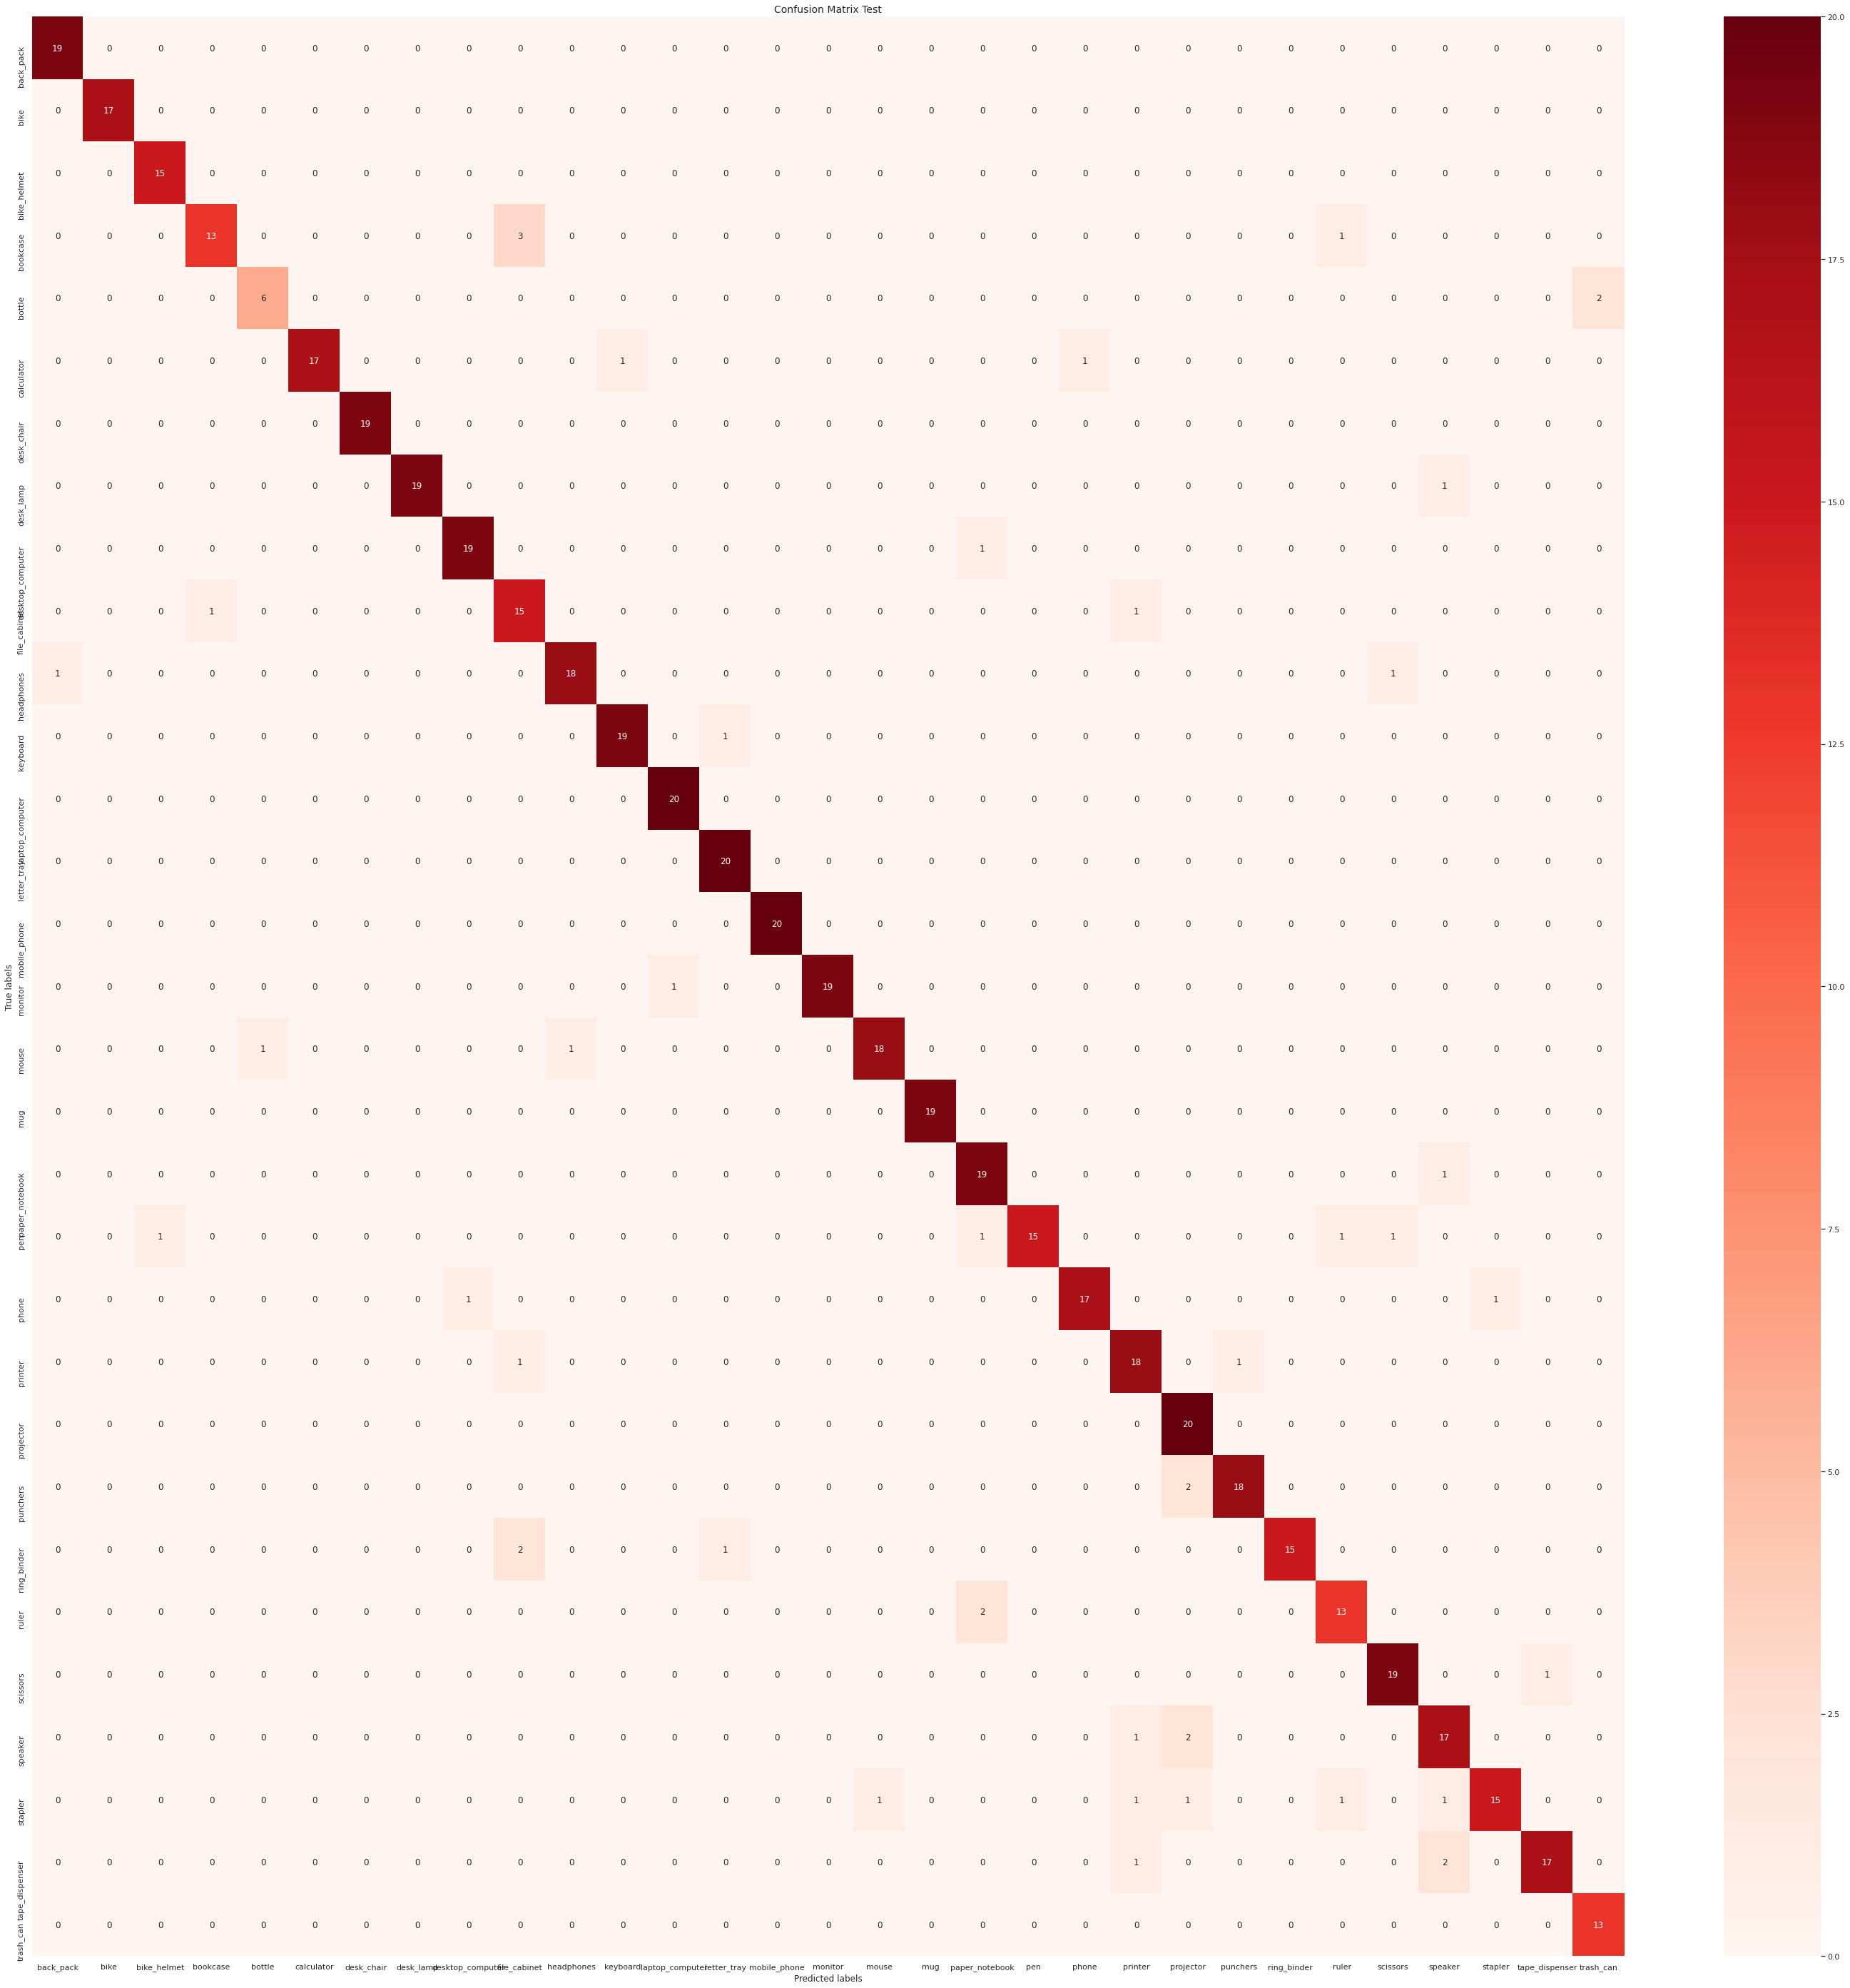

In [25]:
# fungsi confusion matrix
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    return accuracy, precision, f1Score

img_width=150; img_height=150
batch_size=64

VALIDATION_DIR = '/content/drive/MyDrive/dataset/splitted_modern-office-31/val'

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,                                                             
                                                              target_size=(img_height, img_width),
                                                              class_mode=None,
                                                              shuffle=False
                                                             )
predictions = model.predict(validation_generator, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_names = validation_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(50,50))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(31,31)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [ ]:
# k-fold configuration
n_splits = 5

# fix random seed f or reproducibility
seed = 7
np.random.seed(seed)

In [ ]:

    kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    kf.get_n_splits(train_generator)

    acc_scores = list()

    for fold, (train_index, test_index) in enumerate(kf.split(train_generator)):
        print('\n Fold %d' % (fold))

        X_tr, X_v = train_generator[train_index], train_generator[test_index]
        y_tr, y_v = y_train[train_index], y_train[test_index]
        # build the model
        model = model_cnn(num_classes)
        # fit model
        model.fit(
            X_tr,
            y_tr,
            epochs=epochs,
            validation_data=(X_v, y_v),
            verbose=2,
            batch_size=batch_size,
            callbacks=callbacks,
            shuffle=True
        )

        acc = model.evaluate(X_v, y_v, verbose=0)
        acc_scores.append(acc[1])

        print('Fold %d: Accuracy %.2f%%' % (fold, acc[1] * 100))